In [ ]:
%run MUSE_spaxel_fit.py FCC177

In [ ]:
%whos
%who_ls


## Start Here

In [1]:
galaxy_name = "FCC177"

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.io import ascii, fits
from astropy.wcs import WCS, utils, wcs
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
import pandas as pd
from tqdm import tqdm
from photutils import CircularAperture
from IPython.display import display
from MUSE_Models import PNe_residuals_3D, PNe_spectrum_extractor, PNextractor, PSF_residuals_3D, robust_sigma
from PNLF import open_data, reconstructed_image, completeness
import yaml
import sep
from photutils import CircularAperture
import scipy as sp
from scipy.stats import norm, chi2
from scipy import stats
from ppxf_gal_L import ppxf_L_tot
from astroquery.vizier import Vizier

# look into Pandas_profiling and cufflinks

%config InlineBackend.figure_format = 'retina'

In [3]:
# functions
# Open Fits file and assign to raw_data

RAW_DIR = "/local/tspriggs/Fornax_data_cubes/"+galaxy_name
DATA_DIR = "galaxy_data/"+galaxy_name+"_data/"
EXPORT_DIR = "exported_data/"+galaxy_name+"/"
PLOT_DIR = "Plots/"+galaxy_name+"/"+galaxy_name

hdulist = fits.open(DATA_DIR+galaxy_name+"_residuals_list.fits")
hdr = hdulist[0].header
wavelength = np.exp(hdulist[1].data)
    
x_data = hdr["XAXIS"]
y_data = hdr["YAXIS"]

n_pixels = 9    # minicube FOV in pixels
c = 299792458.0 # speed of light

coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]
x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])


# Load in data files for galaxy, from spaxel by spaxel fit

In [4]:
# Pull out the 1D flux data from 1D fits to do radial comparison

gauss_1D_A = np.load(EXPORT_DIR+galaxy_name+"_gauss_A_cen.npy")
A_rN_plot = np.load(EXPORT_DIR+galaxy_name+"_A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load(EXPORT_DIR+galaxy_name+"_rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)

#PNe_1D_flux_data = np.array([PNextractor(x, y, n_pixels, Flux_1D_cube, dim=1.0) for x,y in zip(x_PNe,y_PNe)])
#PNe_1D_A_rN_data = np.array([PNextractor(x, y, n_pixels, A_rN_plot_shape, dim=1.0) for x,y in zip(x_PNe,y_PNe)])

In [5]:
with open("galaxy_info.yaml", "r") as yaml_data:
    galaxy_info = yaml.load(yaml_data, Loader=yaml.FullLoader)
    
galaxy_data = galaxy_info[galaxy_name]

emission_dict = galaxy_data["emissions"]

#D = galaxy_data["Distance"]
gal_vel = galaxy_data["velocity"]
z = gal_vel*1e3 / c

gal_mask_params = galaxy_data["gal_mask"]
star_mask_params = galaxy_data["star_mask"]

# SEP - Source Detection

65


<Figure size 1440x1440 with 0 Axes>

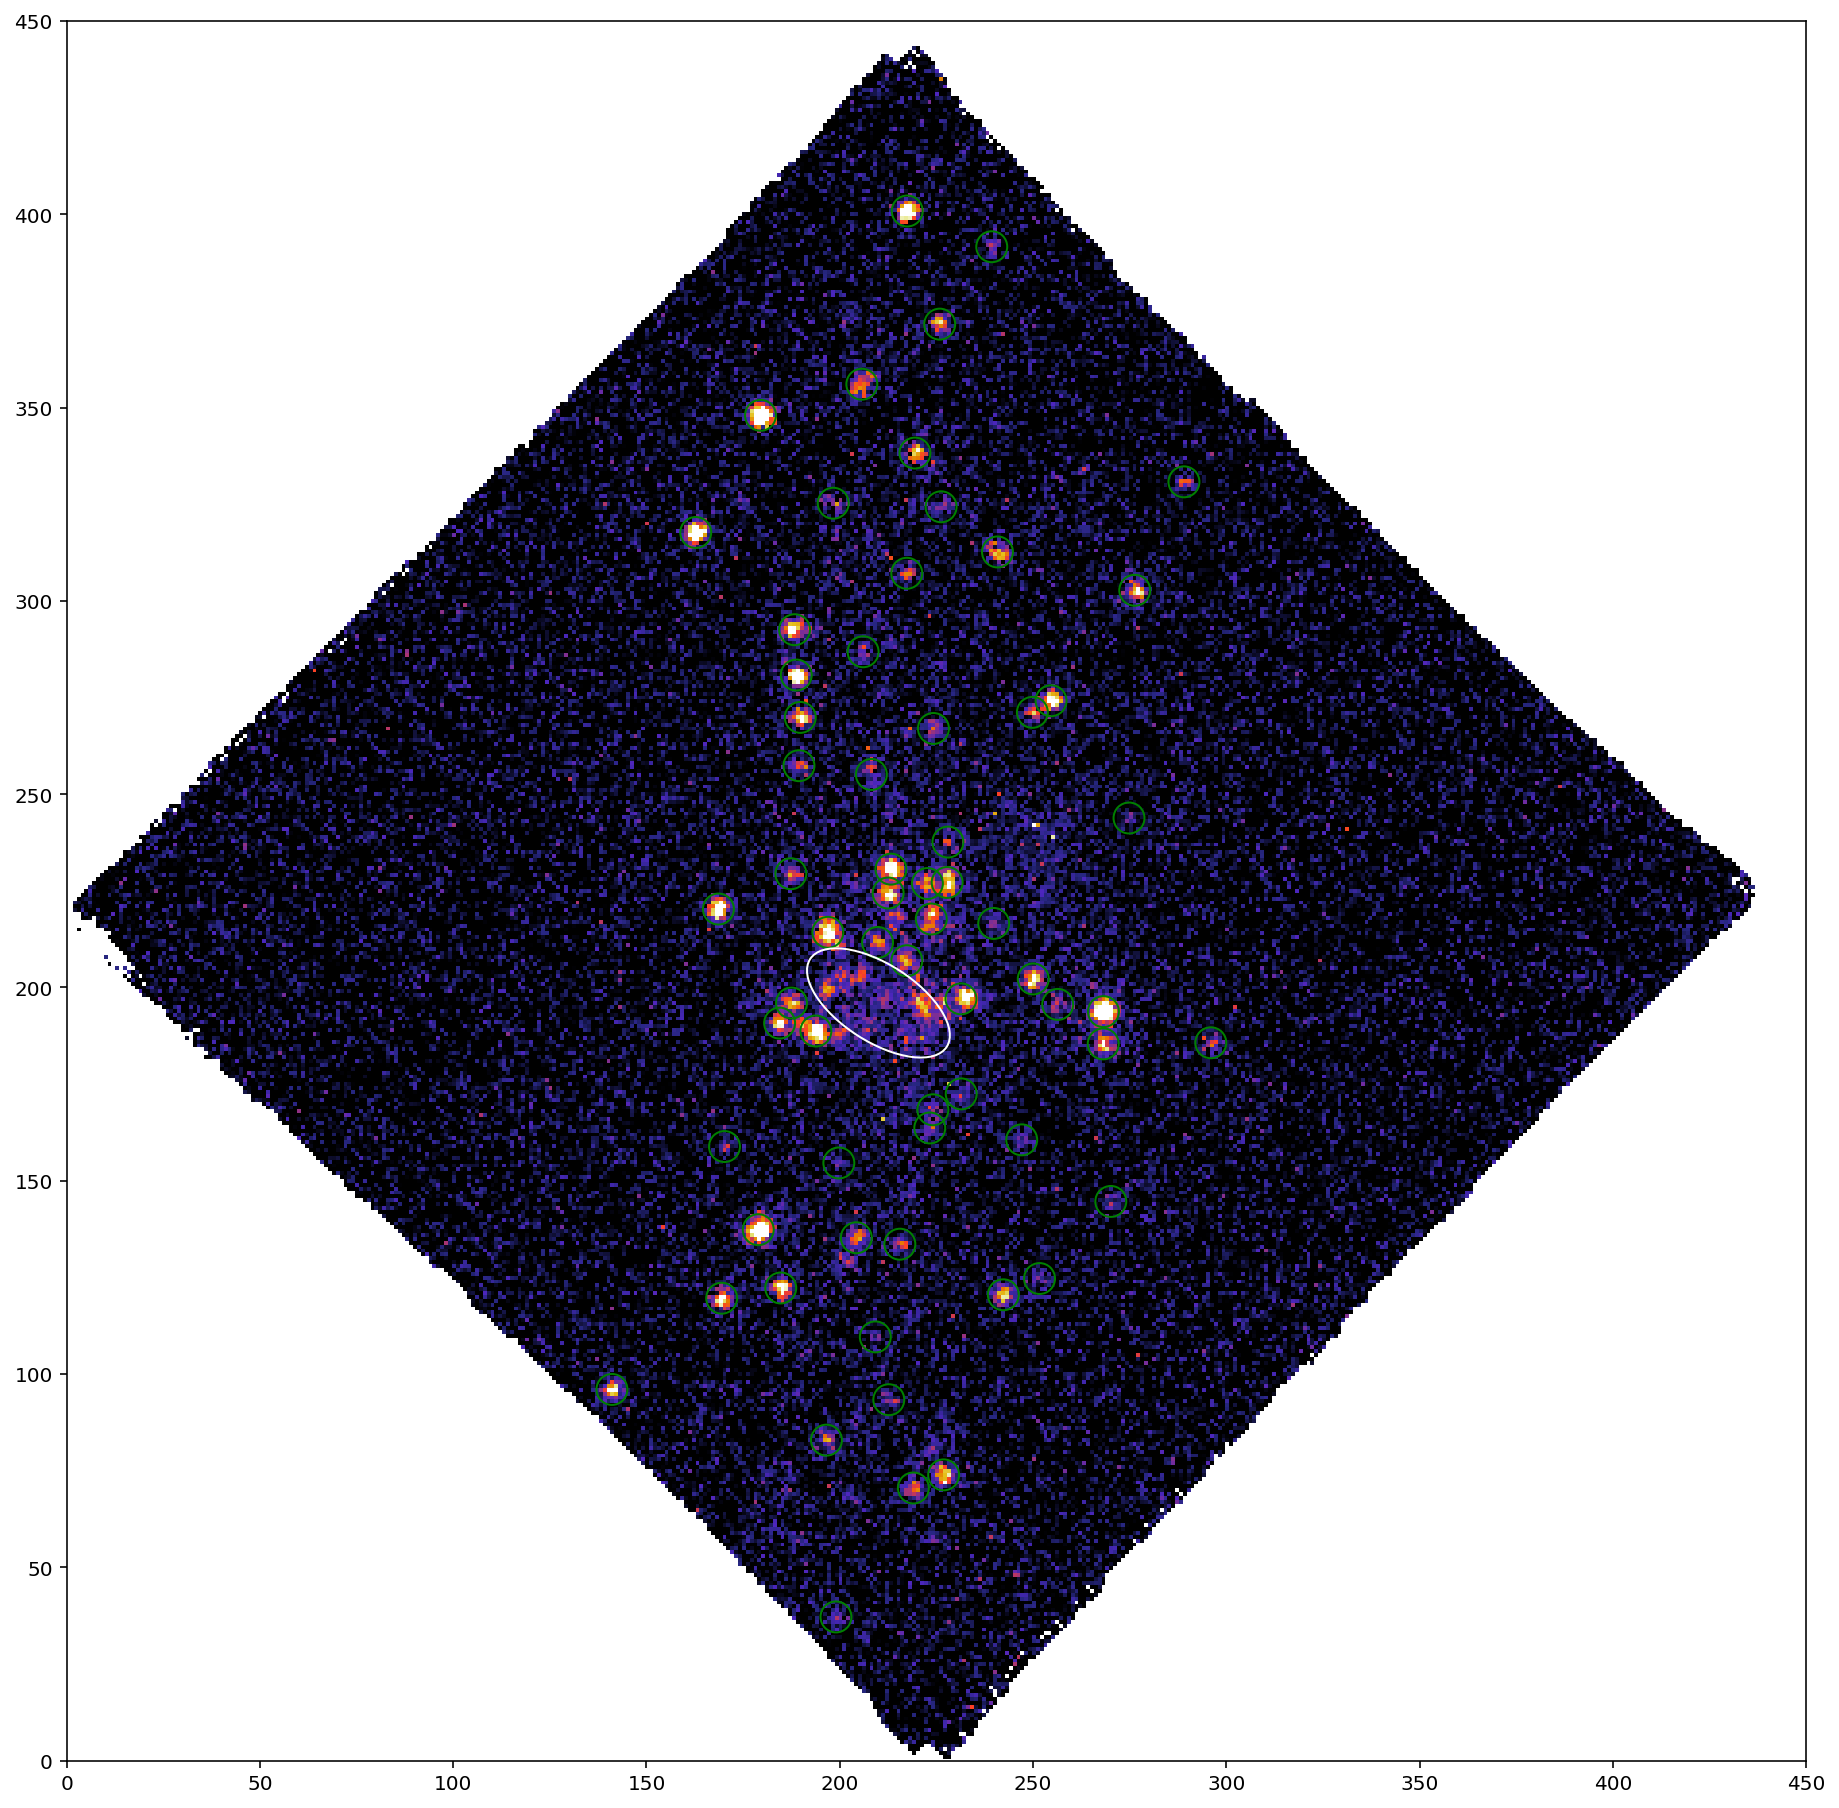

In [6]:
# new FCC167 - [237,200,150,70,0.12]

A_rN_plot_shape[A_rN_plot_shape == A_rN_plot_shape[0,0]] = 0.0
plt.figure(figsize=(20,20))

Y, X = np.mgrid[:y_data, :x_data]
xe, ye, length, width, alpha = [210,196,42,20,1.]#gal_mask_params

elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1    

star_mask = np.sum([(Y - yc)**2 + (X - xc)**2 <= rc**2 for xc,yc,rc in star_mask_params],0).astype(bool)

objects = sep.extract(A_rN_plot_shape, thresh=2.0, clean=True, mask=elip_mask_gal+star_mask,)# filter_type="matched", minarea=7)
x_sep = objects["x"]
y_sep = objects["y"]

positions = (x_sep, y_sep)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8.)
#plt.imshow(Flux_1D_cube, origin="lower", cmap="CMRmap", vmax=100)
apertures.plot(color="green")

plt.xlim(0,450)
plt.ylim(0,450)

ax = plt.gca()
elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white")
ax.add_artist(elip_gal)

sep_x_y_list = [[x,y] for x,y in zip(x_sep, y_sep)]
print(len(x_sep))

#np.save(EXPORT_DIR+galaxy_name+"_PNe_x_y_list", sep_x_y_list)

In [7]:
x_y_list = np.load(EXPORT_DIR+galaxy_name+"_PNe_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

PNe_spectra = np.array([PNe_spectrum_extractor(x, y, n_pixels, hdulist[0].data, x_data, wave=wavelength) for x,y in zip(x_PNe, y_PNe)])

#save residual minicubes
# residual_hdu = fits.PrimaryHDU(PNe_spectra)
# wavelenth_residual = fits.ImageHDU(wavelength)
# hdu_to_write = fits.HDUList([residual_hdu, wavelenth_residual])
# hdu_to_write.writeto("exported_data/"+galaxy_name+"/"+galaxy_name+"_residuals_PNe_minicubes.fits", overwrite=True)

PNe_df = pd.DataFrame(columns=("PNe number", "Ra (J2000)", "Dec (J2000)", "V (km/s)", "m 5007", "M 5007", "[OIII] Flux", "M 5007 error","A/rN", "rad D", "redchi", "Filter"))
PNe_df["PNe number"] = np.arange(0,len(x_PNe)) # PNe numbers
PNe_df["Filter"] = "Y"

# Objective Residual Cube
obj_residual_cube = fits.open(EXPORT_DIR+galaxy_name+"_resids_obj.fits")

# Data Residual Cube
data_residual_cube = fits.open(EXPORT_DIR+galaxy_name+"_resids_data.fits")


def uncertainty_cube_construct(data, x_P, y_P, n_pix):
    data[data == np.inf] = 0.01
    extract_data = np.array([PNe_spectrum_extractor(x, y, n_pix, data, x_data, wave=wavelength) for x,y in zip(x_P, y_P)])
    array_to_fill = np.zeros((len(x_P), n_pix*n_pix, len(wavelength)))
    for p in np.arange(0, len(x_P)):
        list_of_std = np.abs([robust_sigma(dat) for dat in extract_data[p]])
        array_to_fill[p] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]
  
    return array_to_fill

error_cube = uncertainty_cube_construct(data_residual_cube[0].data, x_PNe, y_PNe, n_pixels)
obj_error_cube = uncertainty_cube_construct(obj_residual_cube[0].data, x_PNe, y_PNe, n_pixels)

In [8]:
# # save models for Marc
# models_hdu = fits.PrimaryHDU(model_spectra_list)
# wavelenth_models = fits.ImageHDU(wavelength)
# hdu_to_write = fits.HDUList([models_hdu, wavelenth_models])
# hdu_to_write.writeto("exported_data/"+galaxy_name+"/"+galaxy_name+"_3D_models_PNe.fits", overwrite=True)


In [9]:
PNe_multi_params = Parameters()

def gen_params(wave=5007, FWHM=4.0, FWHM_err=0.1, beta=2.5, beta_err=0.3, LSF=2.81, em_dict=None, vary_LSF=False, vary_PSF=False):
    # loop through emission dictionary to add different element parameters 
    for em in em_dict:
        #Amplitude params for each emission
        PNe_multi_params.add('Amp_2D_{}'.format(em), value=emission_dict[em][0], min=0.00001, max=1e5, expr=emission_dict[em][1])
        #Wavelength params for each emission
        if emission_dict[em][2] == None:
            PNe_multi_params.add("wave_{}".format(em), value=wave, min=wave-15., max=wave+15.)
        else:
            PNe_multi_params.add("wave_{}".format(em), expr=emission_dict[em][2].format(z))
    
    PNe_multi_params.add("x_0", value=((n_pixels//2.) +1), min=((n_pixels//2.) +1)-3, max=((n_pixels//2.) +1)+3)
    PNe_multi_params.add("y_0", value=((n_pixels//2.) +1), min=((n_pixels//2.) +1)-3, max=((n_pixels//2.) +1)+3)
    PNe_multi_params.add("LSF", value=LSF, vary=vary_LSF, min=LSF-1, max=LSF+1)
    PNe_multi_params.add("M_FWHM", value=FWHM, min=FWHM - FWHM_err, max=FWHM + FWHM_err, vary=vary_PSF)
    PNe_multi_params.add("beta", value=beta, min=beta - beta_err, max=beta + beta_err, vary=vary_PSF)   
    PNe_multi_params.add("Gauss_bkg",  value=0.1, vary=True)#1, min=-200, max=500)
    PNe_multi_params.add("Gauss_grad", value=0.0001, vary=True)#1, min=-2, max=2)
    
# storage setup
total_Flux = np.zeros((len(x_PNe),len(emission_dict)))
A_2D_list = np.zeros((len(x_PNe),len(emission_dict)))
F_xy_list = np.zeros((len(x_PNe), len(emission_dict), len(PNe_spectra[0])))
moff_A = np.zeros((len(x_PNe),len(emission_dict)))
model_spectra_list = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
mean_wave_list = np.zeros((len(x_PNe),len(emission_dict)))
residuals_list = np.zeros(len(x_PNe))
list_of_fit_residuals = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
chi_2_r = np.zeros((len(x_PNe)))

# error lists
moff_A_err = np.zeros((len(x_PNe), len(emission_dict)))
x_0_err = np.zeros((len(x_PNe), len(emission_dict)))
y_0_err = np.zeros((len(x_PNe), len(emission_dict)))
mean_wave_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_bkg_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_grad_err = np.zeros((len(x_PNe), len(emission_dict)))

list_of_x = np.zeros(len(x_PNe))
list_of_y = np.zeros(len(x_PNe))
Gauss_bkg = np.zeros(len(x_PNe))
Gauss_grad = np.zeros(len(x_PNe))

def run_minimiser(parameters):
    for PNe_num in tqdm(np.arange(0, len(x_PNe))):
        #progbar(int(PNe_num)+1, len(x_PNe), 40)
        useful_stuff = []        
        PNe_minimizer     = lmfit.Minimizer(PNe_residuals_3D, PNe_multi_params, fcn_args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num, emission_dict, useful_stuff), nan_policy="propagate")
        multi_fit_results = PNe_minimizer.minimize()
        total_Flux[PNe_num] = np.sum(useful_stuff[1][1],1) * 1e-20
        list_of_fit_residuals[PNe_num] = useful_stuff[0]
        A_2D_list[PNe_num]  = useful_stuff[1][0]
        F_xy_list[PNe_num]  = useful_stuff[1][1]
        model_spectra_list[PNe_num] = useful_stuff[1][3]
        moff_A[PNe_num]  = [multi_fit_results.params["Amp_2D_{}".format(em)] for em in emission_dict]
        mean_wave_list[PNe_num]     = [multi_fit_results.params["wave_{}".format(em)] for em in emission_dict]   
        chi_2_r[PNe_num]    = multi_fit_results.redchi
        list_of_x[PNe_num]  = multi_fit_results.params["x_0"]
        list_of_y[PNe_num]  = multi_fit_results.params["y_0"]
        Gauss_bkg[PNe_num]  = multi_fit_results.params["Gauss_bkg"]
        Gauss_grad[PNe_num] = multi_fit_results.params["Gauss_grad"]
        #save errors
        moff_A_err[PNe_num]     = [multi_fit_results.params["Amp_2D_{}".format(em)].stderr for em in emission_dict]
        mean_wave_err[PNe_num]  = [multi_fit_results.params["wave_{}".format(em)].stderr for em in emission_dict]
        x_0_err[PNe_num]        = multi_fit_results.params["x_0"].stderr
        y_0_err[PNe_num]        = multi_fit_results.params["y_0"].stderr
        Gauss_bkg_err[PNe_num]  = multi_fit_results.params["Gauss_bkg"].stderr
        Gauss_grad_err[PNe_num] = multi_fit_results.params["Gauss_grad"].stderr

    # Signal to noise and Magnitude calculations
    list_of_rN = np.array([robust_sigma(PNe_res) for PNe_res in list_of_fit_residuals])
    PNe_df["A/rN"] = A_2D_list[:,0] / list_of_rN # Using OIII amplitude   
    
    # chi square analysis
    gauss_list, redchi, Chi_sqr = [], [], []
    for p in range(len(x_PNe)):
        PNe_n = np.copy(PNe_spectra[p])
        flux_1D = np.copy(F_xy_list[p][0])
        A_n = ((flux_1D) / (np.sqrt(2*np.pi) * (galaxy_data["LSF"]/ 2.35482)))
    
        def gaussian(x, amplitude, mean, FWHM, bkg, grad, z):
            stddev = FWHM / 2.35482
            return ((bkg + grad*x) + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
                    (np.abs(amplitude)/2.85) * np.exp(- 0.5 * (x - (mean - 47.9399*(1+z)))** 2 / (stddev**2.)))
    
        list_of_gauss = [gaussian(wavelength, A, mean_wave_list[p][0], galaxy_data["LSF"], Gauss_bkg[p], Gauss_grad[p], z) for A in A_n]
    
        for kk in range(len(PNe_n)):
            temp = np.copy(list_of_gauss[kk])
            idx  = np.where(PNe_n[kk] == 0.0)[0]
            temp[idx] = 0.0
            PNe_n[kk,idx] = 1.0
            list_of_gauss[kk] = np.copy(temp)
        rN   = robust_sigma(PNe_n - list_of_gauss)
        res  = PNe_n - list_of_gauss
        Chi2 = np.sum((res**2)/(rN**2))
        s    = np.shape(PNe_n)
        redchi.append(Chi2/ ((len(wavelength) * n_pixels**2) - multi_fit_results.nvarys))
        gauss_list.append(list_of_gauss)
        Chi_sqr.append(Chi2)
        
    PNe_df['Chi2']   = Chi_sqr
    PNe_df["redchi"] = redchi
    
    # velocity
    de_z_means = np.array(mean_wave_list[:,0] / (1 + z)) # de redshift OIII wavelength position
    
    PNe_df["V (km/s)"] = (c * (de_z_means - 5006.77) / 5006.77) / 1000.    
        
    PNe_df["[OIII] Flux"] = total_Flux[:,0] #store total OIII 5007 line flux
        
    if "hb" in emission_dict:
        PNe_df["[OIII]/Hb"] = PNe_df["[OIII] Flux"] / total_Flux[:,2] # store [OIII]/Hb ratio

    if "ha" in emission_dict:
        PNe_df["Ha Flux"] = total_Flux[:, 1]
    
    PNe_df["m 5007"] = -2.5 * np.log10(PNe_df["[OIII] Flux"].values) - 13.74


In [10]:
print("Running fitter")

gen_params(wave=5006.77*(1+z), FWHM=galaxy_data["FWHM"], beta=galaxy_data["beta"], LSF=galaxy_data["LSF"], em_dict=emission_dict)
    
run_minimiser(PNe_multi_params)

  0%|          | 0/65 [00:00<?, ?it/s]

Running fitter


100%|██████████| 65/65 [00:23<00:00,  2.78it/s]


## The Great Filter

62
62


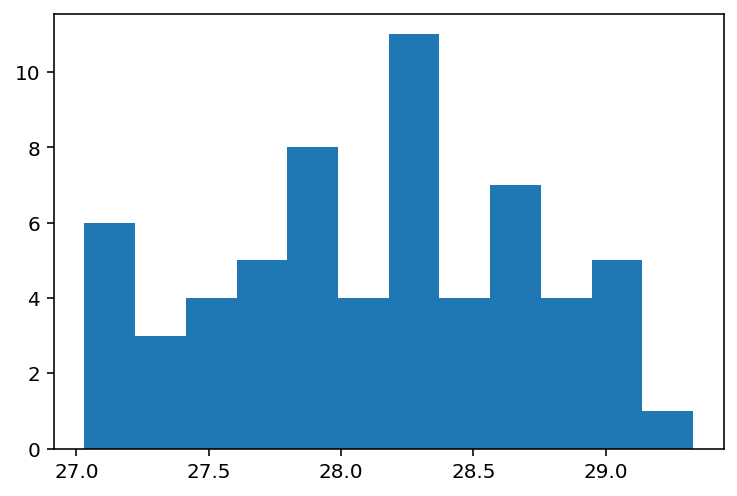

In [11]:
PNe_df["Filter"] = "Y"
PNe_df.loc[PNe_df["A/rN"]<3.0, "Filter"] = "N"
print(len(PNe_df["Filter"].loc[PNe_df["Filter"]=="Y"]))
#PNe_df.loc[PNe_df["m 5007"]<26.65, "Filter"] = "N"
# reduced Chi sqr cut
#redchi_med = np.median(PNe_df["Chi2"].values)
#chi_mid = PNe_df["Chi2"].median()
#chi_std = robust_sigma(PNe_df["Chi2"].values)
#lower_chi = chi_mid - 3*chi_std
#upper_chi = chi_mid + 3*chi_std
#PNe_df.loc[((PNe_df["Chi2"]>=upper_chi) | (PNe_df["Chi2"]<=lower_chi)), "Filter"] = "N" # set Filter to N for PNe who's reduced chi square stat is outside 3 sigma. #&( PNe_df["A/rN"]<5.

upper_chi = chi2.ppf(0.9973, (9*9*len(wavelength))-6) # 3 sigma = 0.9973
PNe_df.loc[PNe_df["Chi2"]>=upper_chi, "Filter"] = "N" 

# sorted_chi2 = np.sort(PNe_df["Chi2"].values)
# chi2.pdf(sorted_chi2, (len(wavelength) * n_pixels**2)-6)
# upper_chi = sorted_chi2[np.argmax(chi2.pdf(sorted_chi2, (len(wavelength) * n_pixels**2)-6))] + 600
# PNe_df.loc[PNe_df["Chi2"]>=upper_chi, "Filter"] = "N" 

# redchi_mid = 1
# redchi_std = robust_sigma(PNe_df["redchi"].values)
# lower_redchi = 0.9#redchi_mid - 3*chi_redstd
# upper_redchi = 1.1#redchi_mid + 3*chi_redstd
# PNe_df.loc[((PNe_df["redchi"]>=upper_redchi) | (PNe_df["redchi"]<=lower_redchi)), "Filter"] = "N" # set Filter to N for PNe who's reduced chi square stat is outside 3 sigma. #&( PNe_df["A/rN"]<5.

## FCC167
if galaxy_name == "FCC167":
    PNe_df.loc[PNe_df["PNe number"]==29, "Filter"] = "N" # Over luminous PNe
    PNe_df.loc[PNe_df["PNe number"]==15, "Filter"] = "N" # Potential HII region
    PNe_df.loc[PNe_df["PNe number"]==8, "Filter"] = "N"  # Double reading from source
## FCC219
# elif galaxy_name == "FCC219":
#     PNe_df.loc[PNe_df["PNe number"]==11, "Filter"] = "N"
elif galaxy_name == "FCC193":
    PNe_df.loc[PNe_df["PNe number"]==143, "Filter"] = "N" 
    PNe_df.loc[PNe_df["PNe number"]==141, "Filter"] = "N" 
    PNe_df.loc[PNe_df["PNe number"]==84, "Filter"] = "N"
    PNe_df.loc[PNe_df["PNe number"]==77, "Filter"] = "Y" 
    PNe_df.loc[PNe_df["PNe number"]==94, "Filter"] = "Y" 
#elif galaxy_name == "FCC147":
    #PNe_df.loc[PNe_df["PNe number"]==41, "Filter"] = "N"
# elif galaxy_name == "FCC249":
#     PNe_df.loc[PNe_df["PNe number"]==2, "Filter"] = "N"
elif galaxy_name == "FCC276":
    PNe_df.loc[PNe_df["PNe number"]==20, "Filter"] = "N" # Overly bright object, sets D=15Mpc, could be overlap/super-position of two.
    PNe_df.loc[PNe_df["PNe number"]==40, "Filter"] = "Y"
    PNe_df.loc[PNe_df["PNe number"]==79, "Filter"] = "Y"
    PNe_df.loc[PNe_df["PNe number"]==85, "Filter"] = "Y"
# elif galaxy_name == "FCC184":
#     PNe_df.loc[PNe_df["PNe number"]==15, "Filter"] = "N"
#     PNe_df.loc[PNe_df["PNe number"]==35, "Filter"] = "N"
elif galaxy_name == "FCC301":
    PNe_df.loc[PNe_df["PNe number"]==14, "Filter"] = "N"
    PNe_df.loc[PNe_df["PNe number"]==16, "Filter"] = "N"
elif galaxy_name == "FCC255":
    PNe_df.loc[PNe_df["PNe number"]==32, "Filter"] = "N"



    

print(len(PNe_df["Filter"].loc[PNe_df["Filter"]=="Y"]))
plt.hist(PNe_df["m 5007"].loc[PNe_df["Filter"]=="Y"], bins=12);
plt.show()

In [11]:
PNe_df.nsmallest(8, "m 5007")

PNe number Ra (J2000) Dec (J2000)    V (km/s)     m 5007 M 5007  \
25          25        NaN         NaN -112.087842  27.030088    NaN   
37          37        NaN         NaN  -96.016472  27.052467    NaN   
30          30        NaN         NaN -117.900350  27.116378    NaN   
27          27        NaN         NaN  -91.178744  27.135028    NaN   
60          60        NaN         NaN -204.214570  27.198400    NaN   
13          13        NaN         NaN  -80.935815  27.203351    NaN   
38          38        NaN         NaN -101.246462  27.291421    NaN   
36          36        NaN         NaN -134.590269  27.334206    NaN   

     [OIII] Flux M 5007 error       A/rN rad D    redchi Filter          Chi2  
25  4.919995e-17          NaN  12.774314   NaN  1.006407      Y  15238.015741  
37  4.819624e-17          NaN  12.646999   NaN  1.003851      Y  15199.303719  
30  4.544108e-17          NaN  12.505955   NaN  1.008027      Y  15262.531299  
27  4.466722e-17          NaN  21.595366   NaN  0.999157      Y  15128.243294  
60  4.213471e-17          NaN  19.490983   NaN  0.991688      Y  15015.146773  
13  4.194300e-17          NaN  16.721799   NaN  1.006245      Y  15235.549371  
38  3.867511e-17          NaN   7.587325   NaN  1.032050      Y  15626.275636  
36  3.718072e-17          NaN   8.939305   NaN  0.991153      Y  15007.052395

In [90]:
def Moffat_err(Moff_A, FWHM, beta, x_0, y_0):
        gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
        rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
        F_OIII_xy_dist = Moff_A * (1 + rr_gg)**(-beta)
    
        return np.sum(F_OIII_xy_dist*1e-20)
    

mean_flux = np.ones(65)
flux_err  = np.ones(65)
mean_m5007 = np.ones(65)
m5007_err = np.ones(65)
for n in np.arange(0,len(x_PNe)):
    Moff_A_dist = np.abs(np.random.normal(moff_A[n][0], moff_A_err[n][0],200))
    FWHM_dist = np.abs(np.random.normal(galaxy_data["FWHM"], galaxy_data["FWHM_err"], 200))
    beta_dist = np.abs(np.random.normal(galaxy_data["beta"], galaxy_data["beta_err"], 200))
    x_0_dist = np.abs(np.random.normal(list_of_x[n], x_0_err[n][0], 200))
    y_0_dist = np.abs(np.random.normal(list_of_y[n], y_0_err[n][0], 200))
    
    flux_array = np.array([Moffat_err(Moff_A_dist[i], FWHM_dist[i], beta_dist[i], x_0_dist[i], y_0_dist[i]) for i in range(0,200)])

    mean_flux[n], flux_err[n] = norm.fit(flux_array)
    mean_m5007[n], m5007_err[n] = norm.fit(-2.5*np.log10(flux_array)-13.72)

mean_m5007[25]

26.996460667630686

# Error analysis

In [112]:
moff_A[0][0]

46.394630109958705

In [119]:
moff_A[:,0]

array([ 46.39463011,  68.42248235,  89.96908388,  80.28435004,
        49.9154114 ,  70.89456028,  46.26902705,  91.57462426,
        81.49272527, 117.14479906,  35.00151847,  66.3309757 ,
       105.21447287, 201.96880809,  28.49534781,  44.3466307 ,
        36.393544  ,  39.62982122,  70.43325835,  70.51624672,
        53.42367676,  41.3061746 ,  47.38737798, 117.27351276,
       116.5495051 , 237.48855465,  80.38282427, 215.01743162,
       102.98665044,  49.73216777, 218.60764495, 139.81904726,
       133.56800277, 151.46090496, 156.99558136,  71.53577862,
       179.6959941 , 232.94338312, 186.54031668, 145.4454017 ,
       172.14383522,  60.04701332,  13.07883702,  51.05480781,
        72.55851739,  68.02261347, 100.8685045 ,  91.3923502 ,
       113.29312101, 132.16325322,  53.19491311, 105.14611204,
        72.66460628,  80.59427653,  83.64514186, 121.5016792 ,
        46.66382513,  56.73427365,  39.01457659, 116.39050775,
       203.5776623 ,  83.3455641 ,  77.942908  ,  35.27

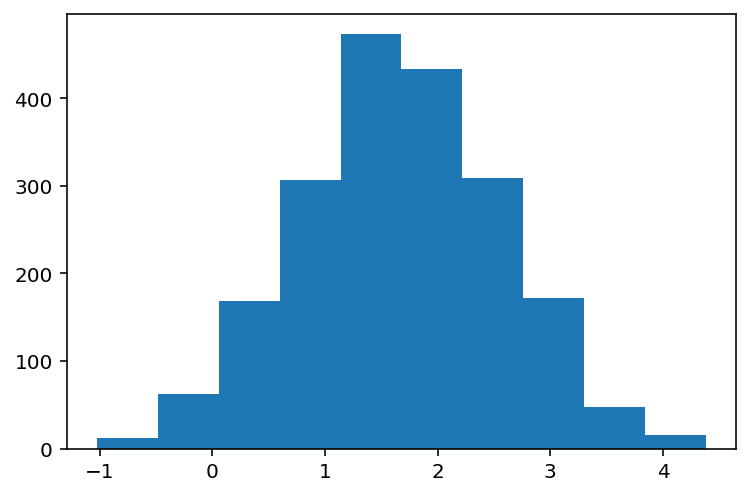

In [182]:
beta_dist = np.random.normal(galaxy_data["beta"], galaxy_data["beta_err"], 2000)

plt.hist(beta_dist);

47.2514099827188
52.39208921927931
46.90873900603456
48.24990992312952


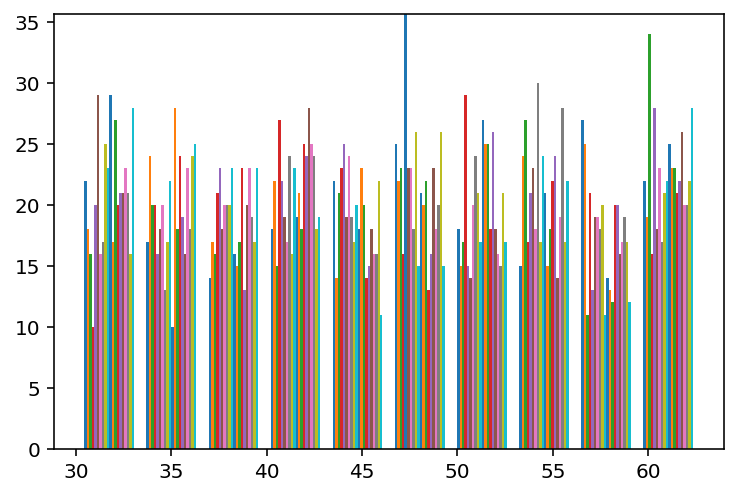

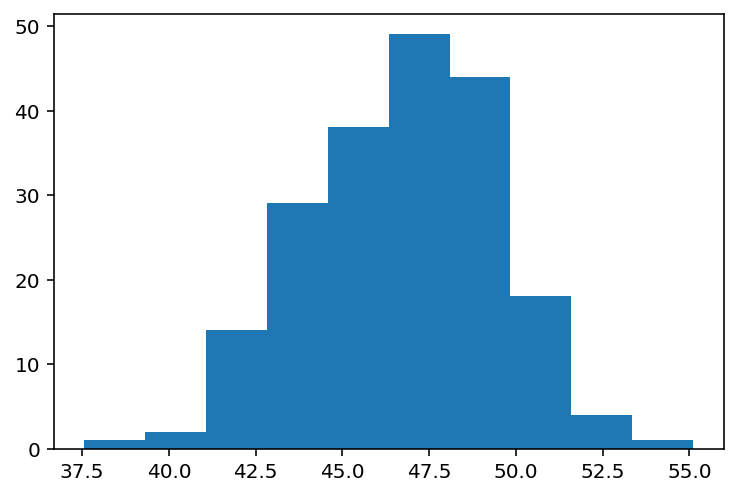

In [157]:
from astropy.stats import bootstrap
from astropy.utils import NumpyRNGContext


bootarr = np.linspace(start=moff_A[0][0]-moff_A[0][1], stop=moff_A[0][0]+moff_A[0][1], num=20)

with NumpyRNGContext(1):
    Moff_A_dist = bootstrap(bootarr, 200)
plt.hist(Moff_A_dist);
plt.axvline(np.median(Moff_A_dist))
print(np.median(Moff_A_dist))
print(np.percentile(Moff_A_dist, 68))
# Moff_A_dist
#         Moff_A_dist = np.abs(np.random.normal(moff_A[n][0], moff_A_err[n][0],n_sim))
#         FWHM_dist = np.abs(np.random.normal(galaxy_data["FWHM"], galaxy_data["FWHM_err"], n_sim))
#         beta_dist = np.abs(np.random.normal(galaxy_data["beta"], galaxy_data["beta_err"], n_sim))
Moff_A_dist = np.abs(np.random.normal(moff_A[0][0], moff_A_err[0][0], 200))
plt.figure()
plt.hist(Moff_A_dist)
print(np.median(Moff_A_dist))
print(np.percentile(Moff_A_dist, 68))

#         y_0_dist = np.abs(np.random.normal(list_of_y[n], y_0_err[n][0], n_sim))

In [234]:
def Moffat_err(Moff_A, FWHM, beta, x_0, y_0):
    if beta <0.01:
        beta = 0.01
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
    F_OIII_xy_dist = Moff_A * (1 + rr_gg)**(-beta)
    
    return np.sum(F_OIII_xy_dist*1e-20)
    
def error_sim(n_sim, n_PNe):
    mean_flux = np.ones(n_PNe)
    flux_err  = np.ones(n_PNe)
    mean_m5007 = np.ones(n_PNe)
    m5007_err = np.ones(n_PNe)
    for n in np.arange(0,len(x_PNe)):
        Moff_A_dist = np.random.normal(moff_A[n][0], moff_A_err[n][0],n_sim)
        FWHM_dist = np.random.normal(galaxy_data["FWHM"], galaxy_data["FWHM_err"], n_sim)
        beta_dist = np.abs(np.random.normal(galaxy_data["beta"], galaxy_data["beta_err"], n_sim))
        x_0_dist = np.random.normal(list_of_x[n], x_0_err[n][0], n_sim)
        y_0_dist = np.random.normal(list_of_y[n], y_0_err[n][0], n_sim)
        
        flux_array = [Moffat_err(Moff_A_dist[i], FWHM_dist[i], beta_dist[i], x_0_dist[i], y_0_dist[i]) for i in range(0,n_sim)]
#         flux_array = [Moffat_err(Moff_A_dist[i], galaxy_data["FWHM"], galaxy_data["beta"], x_0_dist[i], y_0_dist[i]) for i in range(0,n_sim)]

        mean_flux[n] = np.median(flux_array)
        flux_err[n] = mean_flux[n] - np.median([np.percentile(flux_array, 16), np.percentile(flux_array, 84)])
        #norm.fit(flux_array)
                
        mean_m5007[n] = np.median(-2.5*np.log10(flux_array)-13.72)
        m5007_err[n]  = mean_m5007[n] - np.median([np.percentile((-2.5*np.log10(flux_array)-13.72), 16),
                                   np.percentile((-2.5*np.log10(flux_array)-13.72), 84)])

    return mean_flux, flux_err, mean_m5007, m5007_err

mean_flux, PNe_df["Flux error"], mean_m5007, PNe_df["m 5007 error"] = error_sim(5000, len(x_PNe))

## Show F_err in percentage terms
PNe_df["F[OIII] err percent"] = (PNe_df["Flux error"] / PNe_df["[OIII] Flux"])*100

## Distance estimate with error

In [235]:
p_n = int(PNe_df.loc[PNe_df["Filter"]=="Y"].nsmallest(1, "m 5007").index.values)
flux = PNe_df["[OIII] Flux"].iloc[p_n]
flux_err = PNe_df["Flux error"].iloc[p_n]
m = PNe_df["m 5007"].iloc[p_n]
m_err = PNe_df["m 5007 error"].iloc[p_n]
print("PNe: ", p_n)

M_star = -4.52
M_star_err = 0.08
D_diff_eq = 0.2 * np.log(10) * (10**(0.2*(m + 4.52 - 25)))

Dist_est = 10.**(((m + 4.52) -25.) / 5.)#17.54
Dist_err = np.sqrt((D_diff_eq**2 * m_err**2) + ((-D_diff_eq)**2 * M_star_err**2))

print("Distance Estimate from PNLF: ", "{:.3f}".format(Dist_est), "+/-{0:.4f}".format(Dist_err),"Mpc")


dM =  5. * np.log10(Dist_est) + 25.
dM_diff_eq = 5/(np.log(10) * Dist_est)
dM_err = np.abs(dM_diff_eq)*Dist_err


# testing
#Dist_est = 18.79
#dM = 5. * np.log10(Dist_est) + 25.
#

print("dM = {:.3f}".format(dM),"+/- {:.3f}".format(dM_err))

PNe_df["M 5007"] = PNe_df["m 5007"] - dM

PNe:  25
Distance Estimate from PNLF:  20.418 +/-0.9304 Mpc
dM = 31.550 +/- 0.099


### FCC083
PNe:  35
Distance Estimate from PNLF:  17.968 +/-0.7035 Mpc
dM = 31.273 +/- 0.085

### FCC119
PNe:  9
Distance Estimate from PNLF:  19.833 +/-0.8531 Mpc
dM = 31.487 +/- 0.093

### FCC143
PNe:  3
Distance Estimate from PNLF:  17.540 +/-1.4830 Mpc
dM = 31.220 +/- 0.184

### FCC147
PNe:  42
Distance Estimate from PNLF:  18.908 +/-0.7964 Mpc
dM = 31.383 +/- 0.091
 
### FCC161
PNe:  54
Distance Estimate from PNLF:  19.875 +/-0.7740 Mpc
dM = 31.492 +/- 0.085

### FCC167
PNe:  129
Distance Estimate from PNLF:  18.739 +/-0.7677 Mpc
dM = 31.364 +/- 0.089

### FCC177
PNe:  25
Distance Estimate from PNLF:  20.418 +/-0.9304 Mpc
dM = 31.550 +/- 0.099

### FCC182
PNe:  9
Distance Estimate from PNLF:  20.835 +/-1.1226 Mpc
dM = 31.594 +/- 0.117

### FCC184
PNe:  31
Distance Estimate from PNLF:  22.106 +/-0.8859 Mpc
dM = 31.723 +/- 0.087

### FCC190
PNe:  7
Distance Estimate from PNLF:  23.327 +/-0.9003 Mpc
dM = 31.839 +/- 0.084

### FCC193
PNe:  77
Distance Estimate from PNLF:  19.231 +/-0.7412 Mpc
dM = 31.420 +/- 0.084

### FCC219
PNe:  5
Distance Estimate from PNLF:  17.907 +/-0.7694 Mpc
dM = 31.265 +/- 0.093

### FCC249
PNe:  3
Distance Estimate from PNLF:  20.574 +/-0.8374 Mpc
dM = 31.567 +/- 0.088

### FCC255
PNe:  2
Distance Estimate from PNLF:  22.057 +/-0.8748 Mpc
dM = 31.718 +/- 0.086

### FCC276
PNe:  44
Distance Estimate from PNLF:  20.171 +/-0.8133 Mpc
dM = 31.524 +/- 0.088

### FCC277
PNe:  11
Distance Estimate from PNLF:  21.499 +/-0.9022 Mpc
dM = 31.662 +/- 0.091

### FCC301
PNe:  15
Distance Estimate from PNLF:  22.724 +/-1.0056 Mpc
dM = 31.782 +/- 0.096

### FCC310
PNe:  42
Distance Estimate from PNLF:  21.867 +/-0.9073 Mpc
dM = 31.699 +/- 0.090

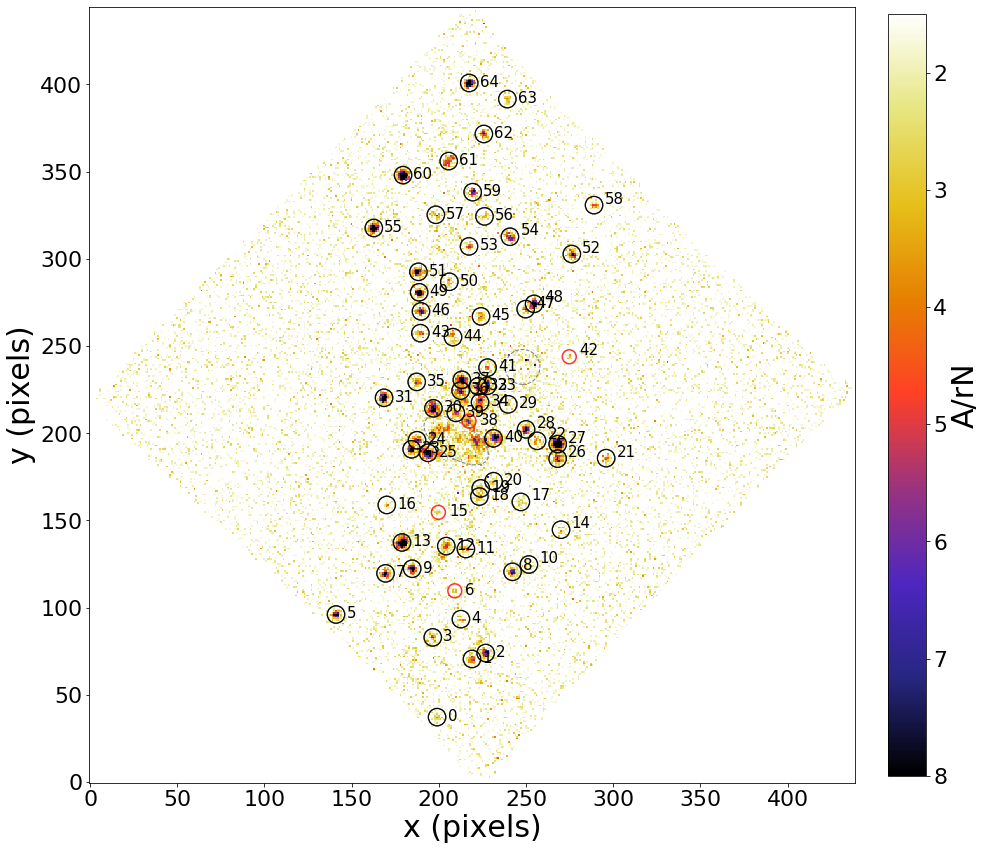

In [12]:
plt.figure(figsize=(15,15))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap_r",  vmin=1.5, vmax=8)
#plt.imshow(Flux_1D_cube, origin="lower", cmap="CMRmap",  vmin=10, vmax=150)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=30)
cb.ax.tick_params(labelsize=22)
cb.ax.invert_yaxis()


plt.xlabel("x (pixels)", fontsize=30)
plt.ylabel("y (pixels)", fontsize=30)

plt.tick_params(labelsize = 22)

Y, X = np.mgrid[:y_data, :x_data]
xe, ye, length, width, alpha = gal_mask_params

if galaxy_name=="FCC219":
    plt.ylim(0,440)
    plt.xlim(0,440)
elif galaxy_name=="FCC193":
    plt.ylim(250,)
    plt.xlim(0,350)
elif galaxy_name=="FCC161":
    plt.xlim(0,450)
elif galaxy_name=="FCC147":
    plt.xlim(230,)
    plt.ylim(0,320)
elif galaxy_name=="FCC083":
    plt.xlim(0,370)
    plt.ylim(0,370)
elif galaxy_name=="FCC310":
    plt.xlim(0,410)
    plt.ylim(100,)
elif galaxy_name=="FCC276":
    plt.xlim(310,)
elif galaxy_name=="FCC184":
    plt.xlim(0,450)
    plt.ylim(0,450)

elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="grey", ls="--")
ax.add_artist(elip_gal)

for star in star_mask_params:
    ax.add_artist(Circle((star[0], star[1]), radius=star[2], fill=False, color="grey", ls="--"))



for i, item in enumerate(x_y_list):
    if PNe_df.iloc[i].Filter == "Y":
        ax = plt.gca()
        circ = plt.Circle((item[0],item[1]),5, color="black",lw=1.2, fill=False, alpha=0.8)
        ax.add_artist(circ)
    elif PNe_df.iloc[i].Filter == "N":
        ax = plt.gca()
        circ = plt.Circle((item[0],item[1]),4, color="red",lw=1.5, fill=False, alpha=0.8)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(i, (item[0]+6, item[1]-2), color="black", size=15)
    else:
        ax.annotate(i, (item[0]+6, item[1]+1), color="black", size=15)

        
# for i in contamination:
#     ax = plt.gca()
#     circ = plt.Circle((x_PNe[i],y_PNe[i]),6, color="r",lw=1.0, fill=False, alpha=0.7)
#     ax.add_artist(circ)
    
#plt.axvline(190)
#plt.axhline(110)
#plt.savefig(PLOT_DIR+"_A_rN_circled.png", bbox_inches='tight')
#plt.savefig(PLOT_DIR+"_A_rN_circled.pdf", bbox_inches='tight')
#plt.savefig(PLOT_DIR+"_Flux_circled.pdf", bbox_inches='tight')

In [25]:
x_PNe[74]

169.23762761712644

## Pixel array size experiment

In [ ]:
# n_pix_dist = 31
n_range = np.arange(11,22,2)
store_here = np.ones(len(n_range))
for i, n_pix_dist in enumerate(n_range):
    coordinates = [(n,m) for n in range(n_pix_dist) for m in range(n_pix_dist)]
    x_fit = np.array([item[0] for item in coordinates])
    y_fit = np.array([item[1] for item in coordinates])
    
    n_sim = 10000
    Moff_A_dist = np.random.normal(moff_A[40][0], moff_A_err[40][0],n_sim)
    FWHM_dist = np.random.normal(4.06, 0.018, n_sim)
    beta_dist = np.random.normal(3.41, 0.167, n_sim)
    x_0_dist = np.random.normal(list_of_x[40], x_0_err[40][0], n_sim)
    y_0_dist = np.random.normal(list_of_y[40], y_0_err[40][0], n_sim)
    
    def Moffat_err(Moff_A, FWHM, beta, x_0, y_0):
        gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
        rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
        F_OIII_xy_dist = Moff_A * (1 + rr_gg)**(-beta)
    
    
        return np.sum(F_OIII_xy_dist*1e-20)
    
    flux_array = [Moffat_err(Moff_A_dist[i], FWHM_dist[i], beta_dist[i], x_0_dist[i], y_0_dist[i]) for i in range(0,n_sim)]
    plt.hist(flux_array)
    plt.axvline(PNe_df["[OIII] Flux"].iloc[40])
    #plt.xlim(3.6e-17, 4.2e-17)
    #print(PNe_df["[OIII] Flux"].iloc[40])
    #print(PNe_df["m 5007"].iloc[40])
    mu_f, std_f = norm.fit(flux_array)
    #print(mu, (std/mu)*100,"%")
    plt.axvline(mu_f, c="r")
    
    mu, std = norm.fit(-2.5*np.log10(flux_array)-13.72)
    #print(mu, std)
    store_here[i] = mu_f

print(np.abs((-2.5*np.log10(store_here.max()) - 13.74)  -  (-2.5*np.log10(store_here[1]) - 13.74)))

plt.figure()
plt.plot(n_range, store_here)
plt.axvline(n_pixels)
# Correction for n_pixel and flux variation from fit

In [53]:
np.sum((PNe_spectra[2] - model_spectra_list[2])**2 / error_cube[2]**2)

15817.571044637256

## Integrated spectrum with fit

PNe number                      55
Ra (J2000)                     NaN
Dec (J2000)                    NaN
V (km/s)                  -137.681
m 5007                     27.7572
M 5007                         NaN
[OIII] Flux            2.51831e-17
M 5007 error                   NaN
A/rN                       13.2559
rad D                          NaN
redchi                      1.0046
Filter                           Y
Chi2                       15210.7
Flux error                       1
m 5007 error                     1
F[OIII] err percent    3.97091e+18
Name: 55, dtype: object


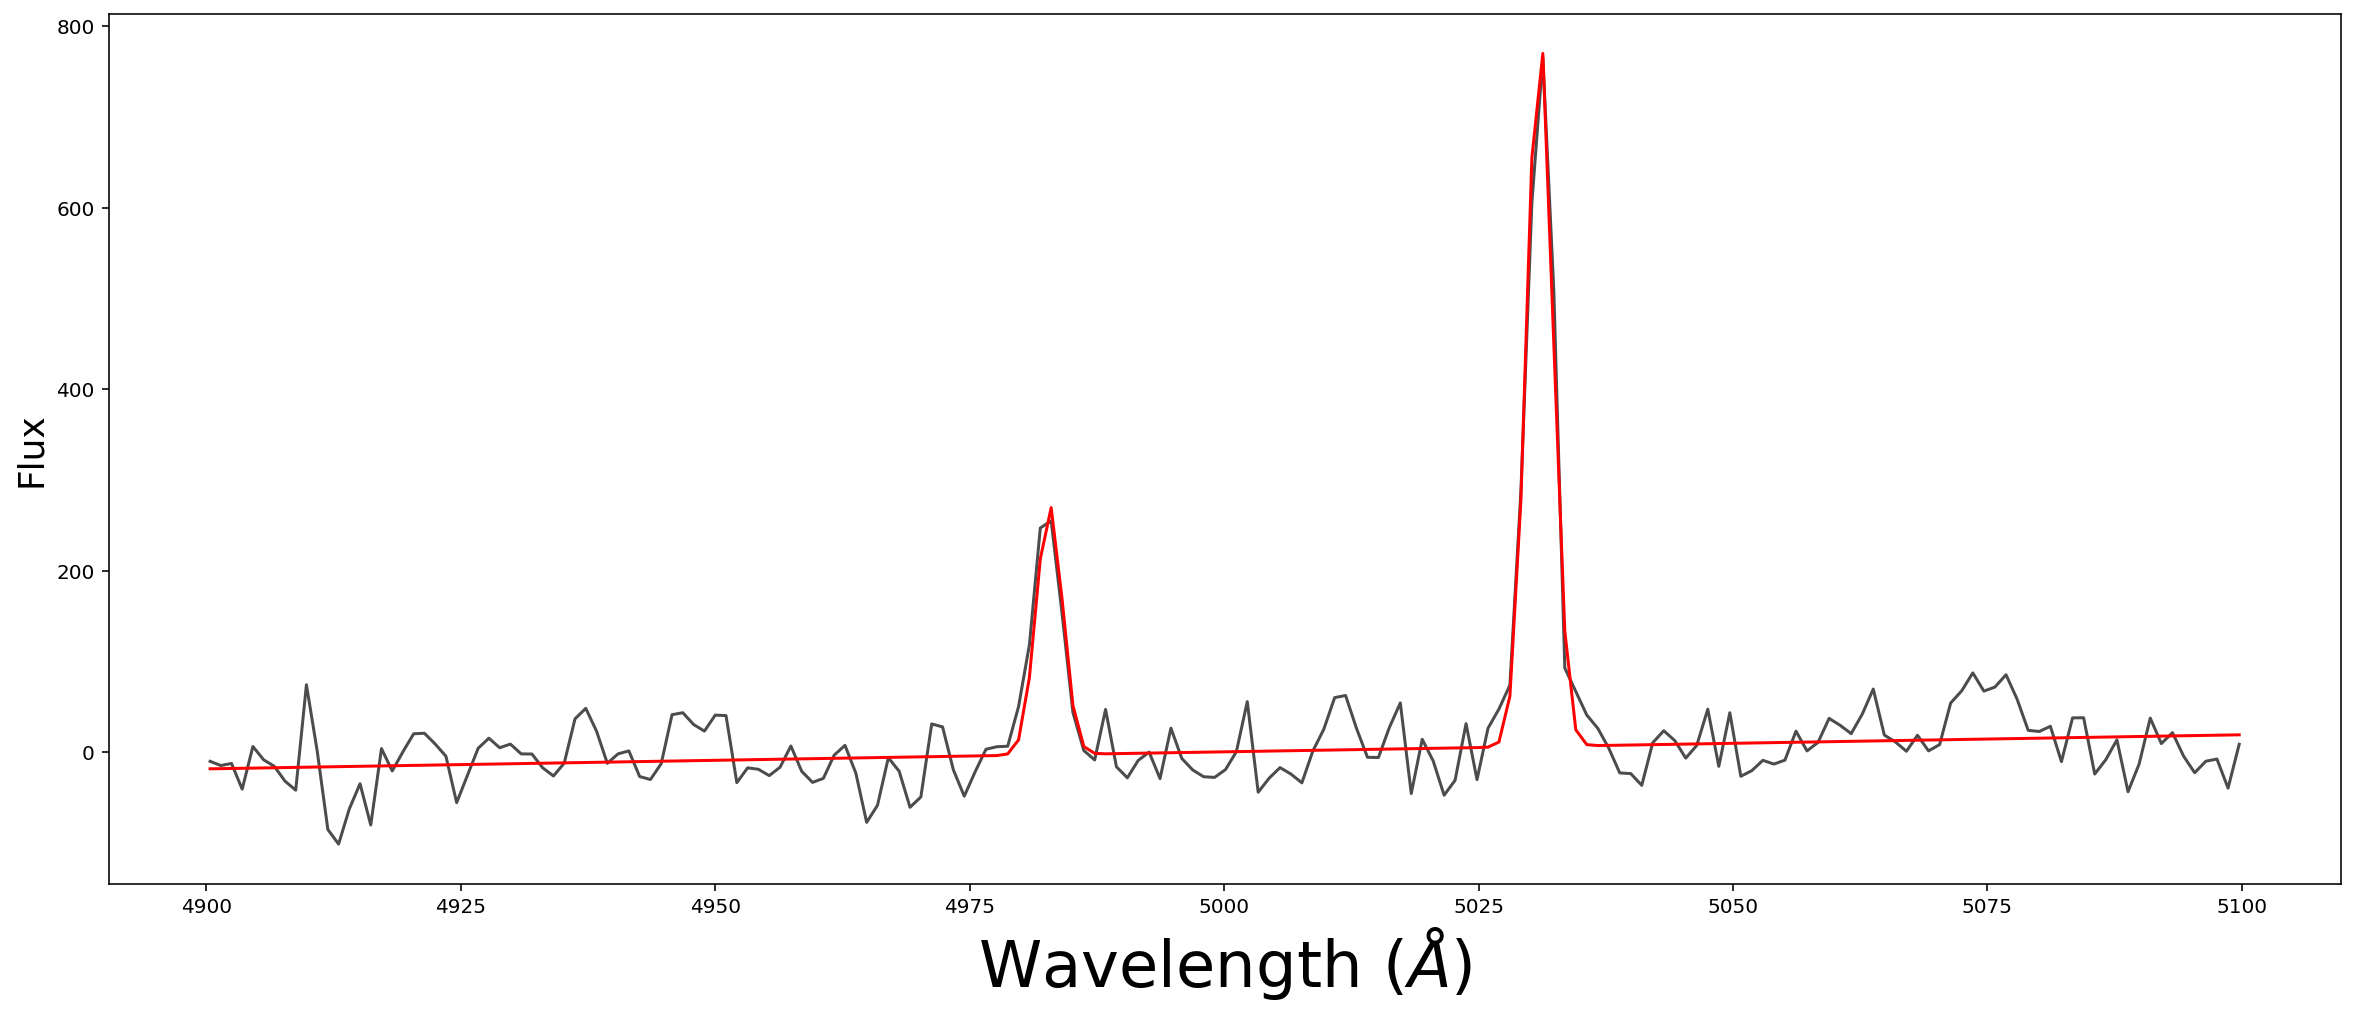

In [49]:
p =55

print(PNe_df.loc[p])

plt.figure(figsize=(20,8))
plt.plot(wavelength, np.sum(PNe_spectra[p],0), alpha=0.7, c="k")

plt.plot(wavelength, np.sum(model_spectra_list[p],0), c="r")
plt.xlabel("Wavelength ($\AA$)", fontsize=32)
plt.ylabel("Flux", fontsize=18);
#plt.ylim(-1000,3500);
#plt.axvline(5042)
#plt.xlim(4900,5100)
#plt.axvline(5039)
#plt.axvline(5033)
#plt.savefig(PLOT_DIR+f"_integrated_PNe_{p}_fit.png")

In [12]:
upper_chi

15547.340219191157

## Spaxel by spaxel with individual fits

In [ ]:
p = 15
PNe_n = PNe_spectra[p]
flux_1D = F_xy_list[p][0]
A_n = ((flux_1D) / (np.sqrt(2*np.pi) * 1.19))

def gaussian(x, amplitude, mean, stddev, bkg, grad, z):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
            (np.abs(amplitude)/2.85) * np.exp(- 0.5 * (x - (mean - 47.9399*(1+z)))** 2 / (stddev**2.)))

list_of_gauss = [gaussian(wavelength, A, mean_wave_list[p][0], 1.19, Gauss_bkg[p], Gauss_grad[p], z) for A in A_n]

fig = plt.figure(figsize=(80,40))

ax = fig.add_subplot(1,1,1)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)


for i, spec in enumerate(PNe_n):
    ax1 = fig.add_subplot(n_pixels,n_pixels,i+1)
    fig.subplots_adjust(wspace=0.25, hspace=0.3)
    ax1.plot(wavelength, spec, c="k")
    ax1.plot(wavelength, list_of_gauss[i], c="r", alpha=1.0)
    ax1.tick_params(labelsize = 14, pad=8)
    ax1.set_xlim(4900,5100)
    ax1.set_ylim(-25, 100)

    
ax.set_ylabel("Flux Density ($10^{-20}$ $erg s^{-1}$ $cm^{-2}$ $\AA^{-1}$ $arcsec^{-2}$)", fontsize=40, labelpad=30)
ax.set_xlabel("Wavelength ($\AA$)", fontsize=50, labelpad=30);

#plt.savefig(PLOT_DIR"_"+f"{p}"+"_spaxel_by_spaxel.pdf", bbox_inches='tight')
#plt.savefig(PLOT_DIR"_"+f"{p}"+"_spaxel_by_spaxel.png", bbox_inches='tight')

## [OIII] / Ha   (+[NII]) - OLD

In [18]:
y_idx = PNe_df.loc[PNe_df["Filter"]=="Y"].index.values
n_idx = PNe_df.loc[PNe_df["Filter"]=="N"].index.values

Text(0.5, 0, '$M_{5007}$')

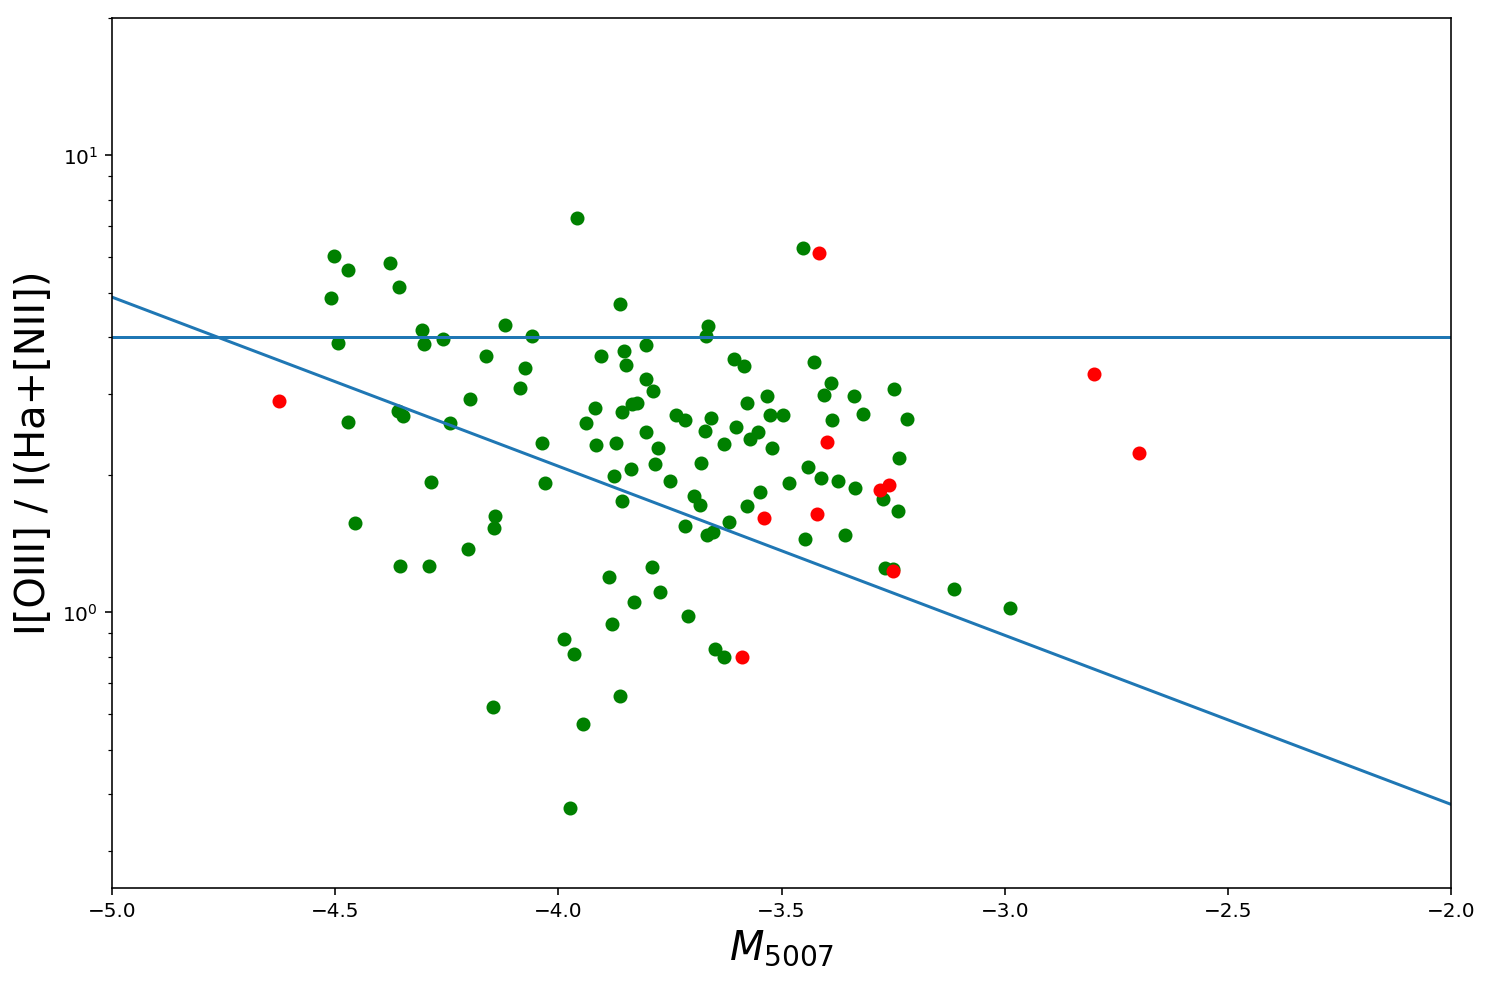

In [15]:
em_ratios = np.load("exported_data/FCC167/gandalf/emission_ratios.npy")
OIII_by_Ha, OIII_by_Ha_plus_NII, NII_by_Ha, OIII_by_SII = em_ratios

PNe_df["OIII/Ha"] = OIII_by_Ha
PNe_df["OIII/Ha+NII"] = OIII_by_Ha_plus_NII
PNe_df["NII/Ha"] = NII_by_Ha
PNe_df["OIII/SII"] = OIII_by_SII

plt.figure(figsize=(12,8))
plt.yscale("log")
plt.scatter(PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"], OIII_by_Ha_plus_NII[y_idx], c="g")
plt.scatter(PNe_df["M 5007"].loc[PNe_df["Filter"]=="N"], OIII_by_Ha_plus_NII[n_idx], c="r")

plt.axhline(4)
plt.ylim(0.25,20)
plt.xlim(-5,-2)
x = np.arange(-5, -2,0.001)
plt.plot(x, 10**((-0.37 * x) - 1.16))
plt.ylabel("I[OIII] / I(Ha+[NII])", fontsize="20")
plt.xlabel("$M_{5007}$", fontsize="20")
# plt.savefig("Plots/FCC167/[OIII]Ha+NII.png")

# LOSV work

# Scatter points for measured PNe velocity

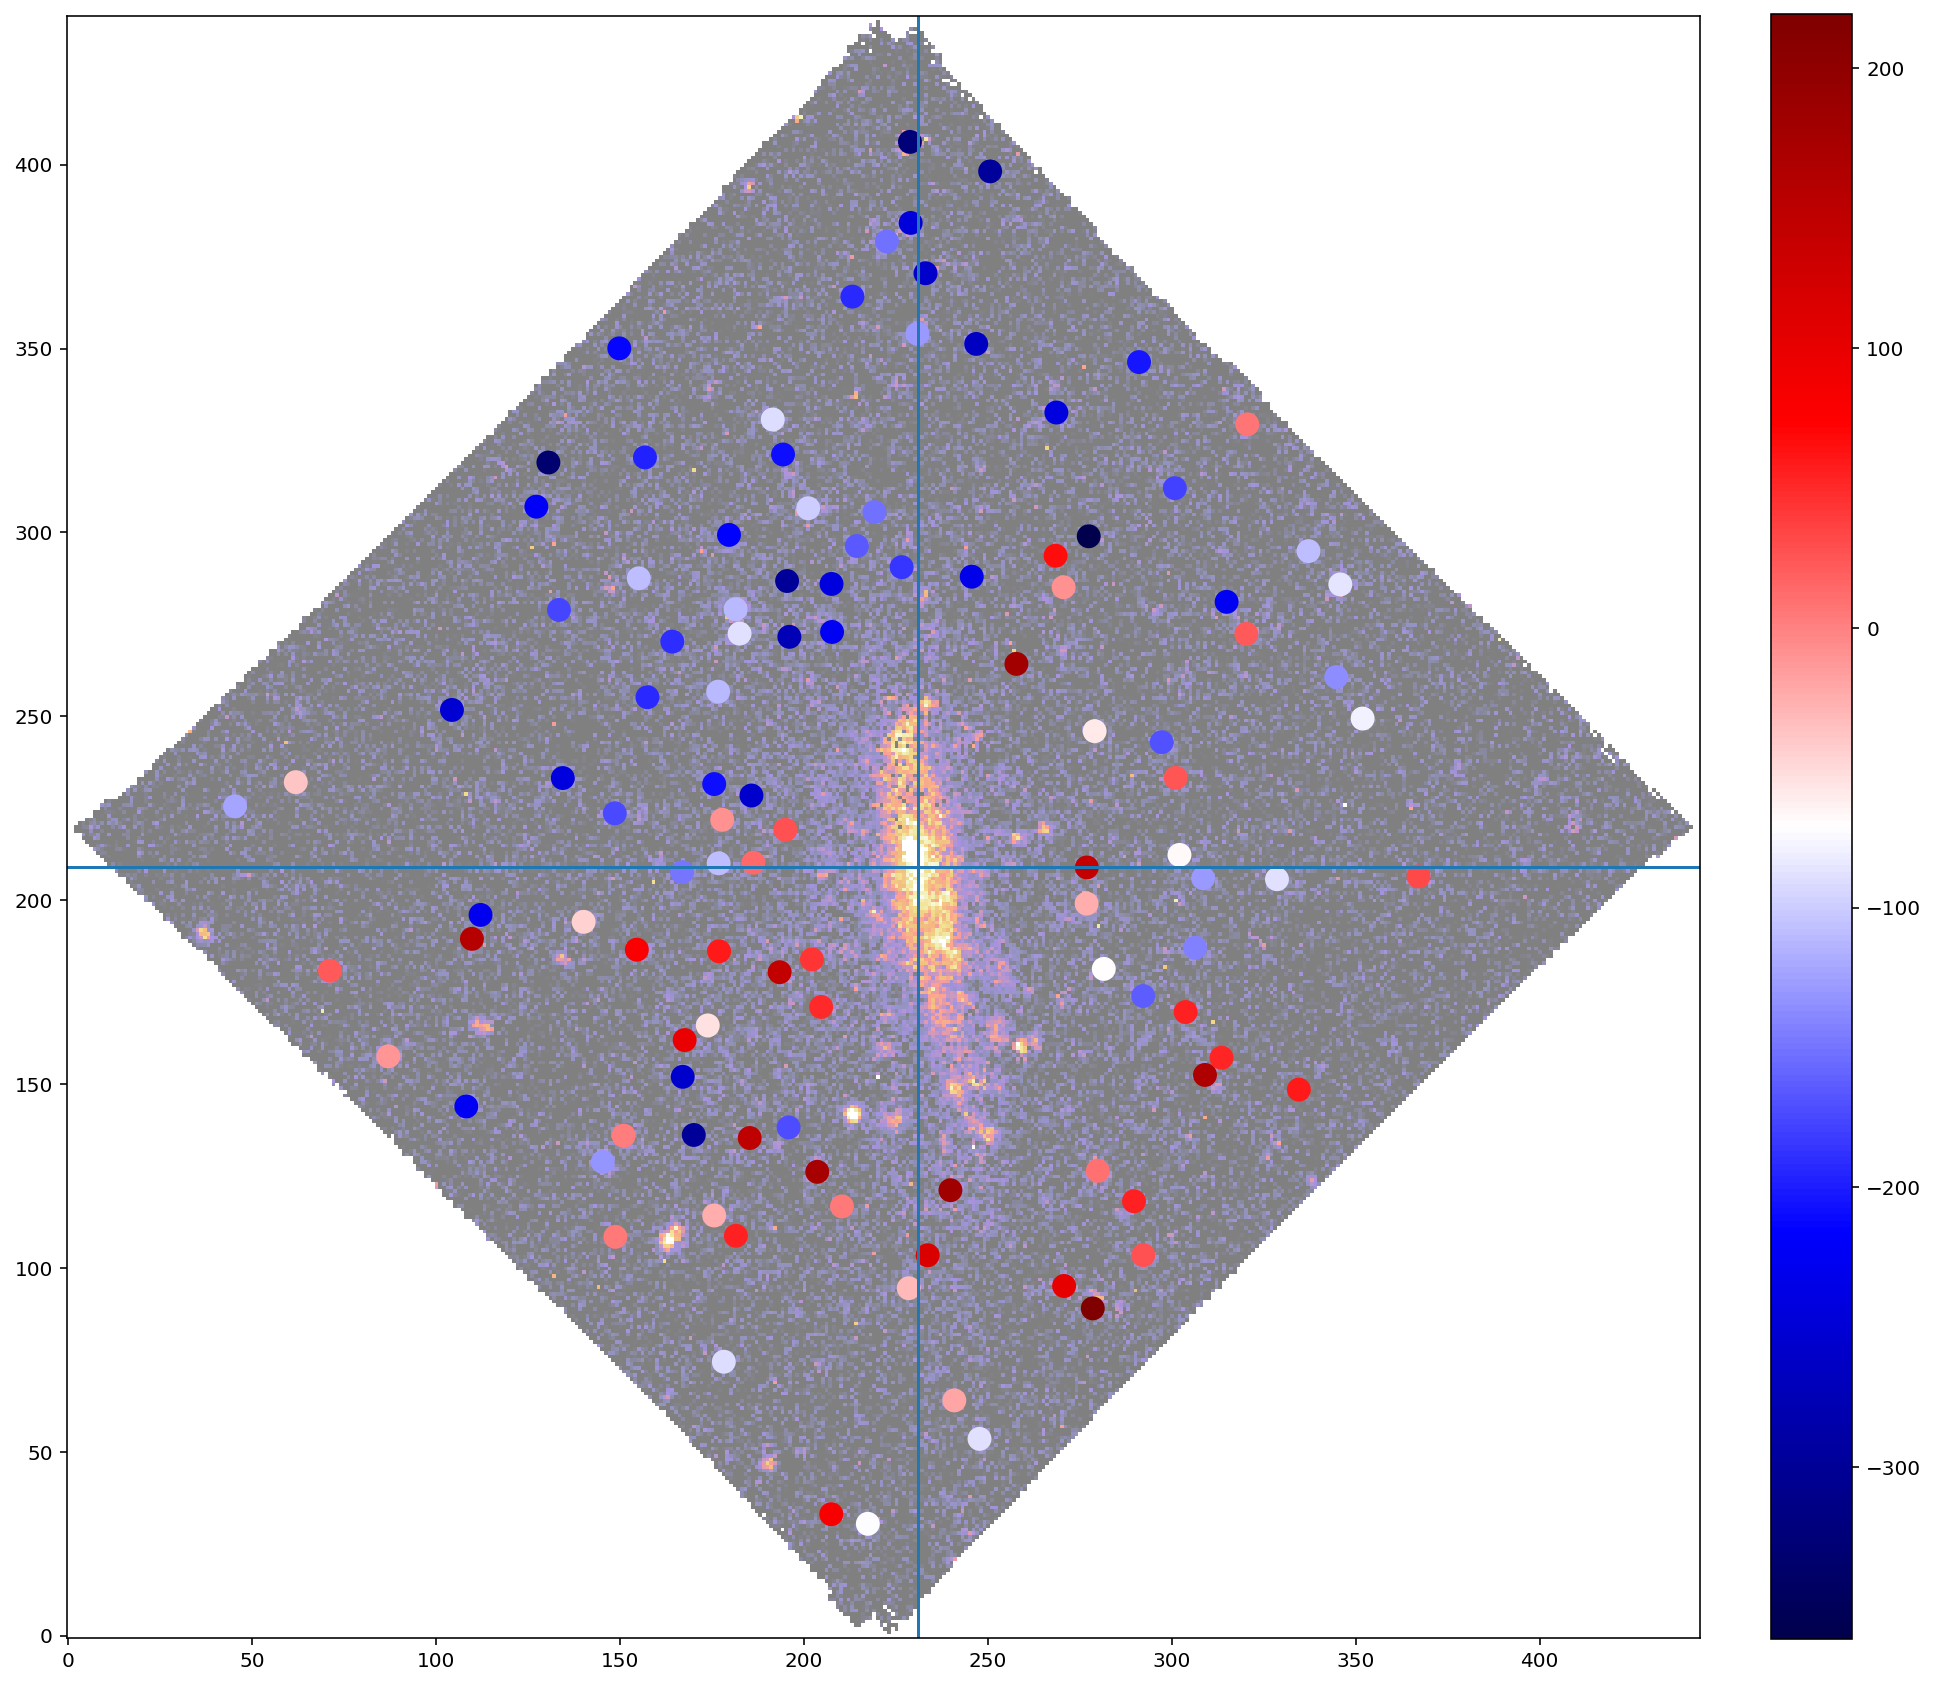

In [77]:
# Scatter plot the x y locations of PNe, colour coding them with their velocity
# ind=PNe_df.loc[PNe_df["Filter"]=="Y"].index
ind=PNe_df.loc[(PNe_df["Filter"]=="Y")].index


positions = (x_PNe[ind], y_PNe[ind])
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8., alpha=0.5)
plt.scatter(x_PNe[ind], y_PNe[ind], c=PNe_df["V (km/s)"].loc[PNe_df["Filter"]=="Y"], cmap="seismic", s=120)
# plt.scatter(x_PNe, y_PNe, c=PNe_df["m 5007"], cmap="inferno_r", s=120)
if galaxy_name=="FCC219":
    plt.ylim(0,440)
    plt.xlim(0,440)
elif galaxy_name=="FCC193":
    plt.ylim(250,)
    plt.xlim(0,350)
elif galaxy_name == "FCC276":
    plt.xlim(310,)
cb = plt.colorbar(fraction=0.0455, pad=0.04)
# cb.set_label("$V_{[OIII]} \ (km \ s^{-1}$)", fontsize=20)
#plt.savefig(PLOT_DIR"PNe_velocity_dist_map.pdf")

plt.axhline(209)
plt.axvline(231)

In [45]:
hdulist_ppxf = fits.open(DATA_DIR+galaxy_name+"center_ppxf_SPAXELS.fits")
v_star, s_star = hdulist_ppxf[1].data.V, hdulist_ppxf[1].data.SIGMA

print(np.median(v_star))

1804.5223675832533


In [82]:
## Velocity from files

hdulist_table = fits.open(DATA_DIR+galaxy_name+"center_table.fits")
X_star, Y_star = hdulist_table[1].data.XBIN, hdulist_table[1].data.YBIN
flux_star = hdulist_table[1].data.FLUX

idx = flux_star.argmax()
X_star, Y_star = X_star-X_star[idx], Y_star-Y_star[idx]

hdulist_ppxf = fits.open(DATA_DIR+galaxy_name+"center_ppxf_SPAXELS.fits")
v_star, s_star = hdulist_ppxf[1].data.V, hdulist_ppxf[1].data.SIGMA

cond = np.sqrt( (X_star)**2 + (Y_star)**2 ) <= 5.0
vsys = np.median(v_star[cond])
v_star = v_star-vsys

f_ind = PNe_df.loc[PNe_df["Filter"]=="Y"].index
if galaxy_name == "FCC167":
    gal_x_c = 231
    gal_y_c = 208
elif galaxy_name == "FCC219":
    gal_x_c = 190
    gal_y_c = 110
elif galaxy_name == "FCC193":
    gal_x_c = 170
    gal_y_c = 405

xpne, ypne = (x_PNe[f_ind]-gal_x_c)*0.2, (y_PNe[f_ind]-gal_y_c)*0.2

# Estimating the velocity dispersion of the PNe along the LoS
def sig_PNe(X_star,Y_star,v_stars,sigma,x_PNe,y_PNe,vel_PNe):

    d_PNe_to_skin = np.zeros(len(x_PNe))
    Vs_PNe = np.ones(len(x_PNe)) # Velocity of the closest star
    Ss_PNe = np.ones(len(x_PNe)) # Sigma for each PNe
    i_skin_PNe = []

    """ To estimate the velocity dispersion for PNe we need to
    extract the sigma of the closest stars for each PNe """

    for i in range(len(x_PNe)):
        r_tmp = np.sqrt((X_star-x_PNe[i])**2+(Y_star-y_PNe[i])**2)
        d_PNe_to_skin[i] = min(r_tmp)
        i_skin_PNe.append(r_tmp.argmin())

    Vs_PNe  = v_stars[i_skin_PNe]
    Ss_PNe  = sigma[i_skin_PNe]
    rad_PNe = np.sqrt(x_PNe**2+y_PNe**2)
    k = np.where(d_PNe_to_skin > 1.0)

    return rad_PNe, (vel_PNe-Vs_PNe)/Ss_PNe, k

rad_PNe, vel_ratio, k  = sig_PNe(X_star, Y_star, v_star, s_star, xpne, ypne, PNe_df["V (km/s)"].loc[PNe_df["Filter"]=="Y"])


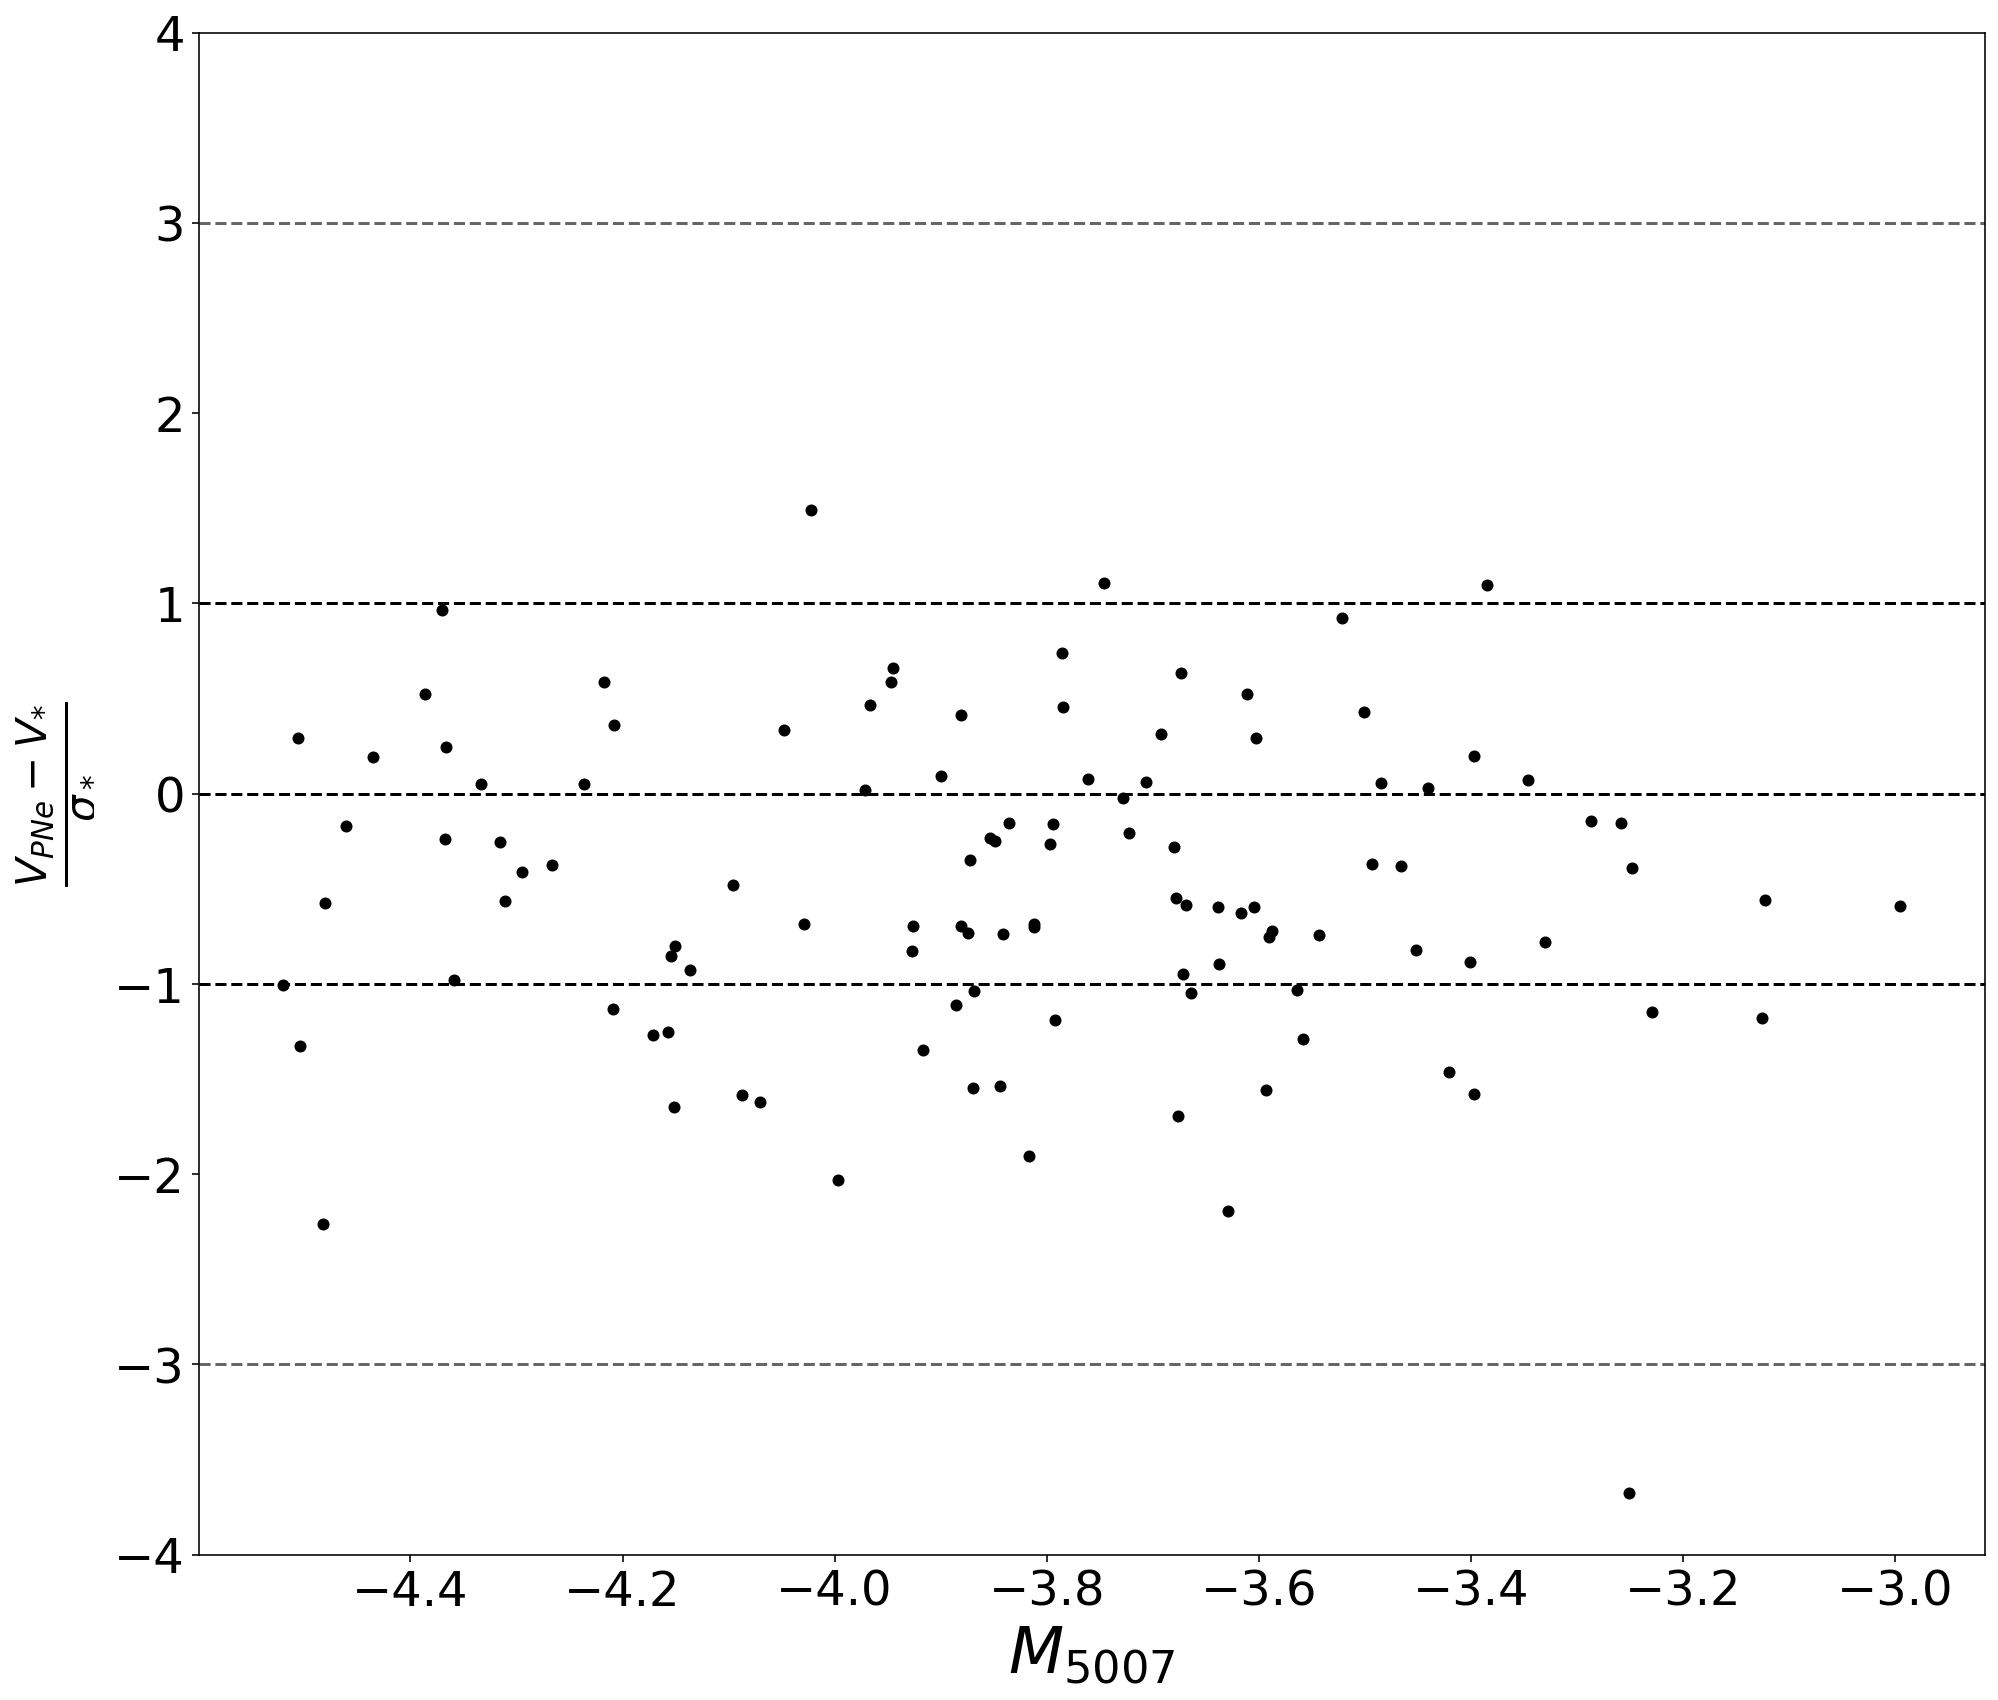

In [83]:
plt.figure(44, figsize=(16,14))
plt.clf()
plt.scatter(PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"], vel_ratio, s=25, c="k")
plt.xlabel("$M_{5007}$", fontsize=32)
plt.ylabel(r"$\frac{V_{PNe} - V_{*}}{\sigma_*}$", fontsize=30, labelpad=10)
plt.axhline(y=1, c="k", ls="dashed")
plt.axhline(y=3, c="k", ls="dashed", alpha=0.6)
plt.axhline(y=0, c="k", ls="dashed")
plt.axhline(y=-1, c="k", ls="dashed")
plt.axhline(y=-3, c="k", ls="dashed", alpha=0.6)
plt.ylim(-4,4)
plt.tick_params(labelsize = 24)
#plt.savefig(PLOT_DIR"_velocity_plot.pdf", bbox_inches='tight')

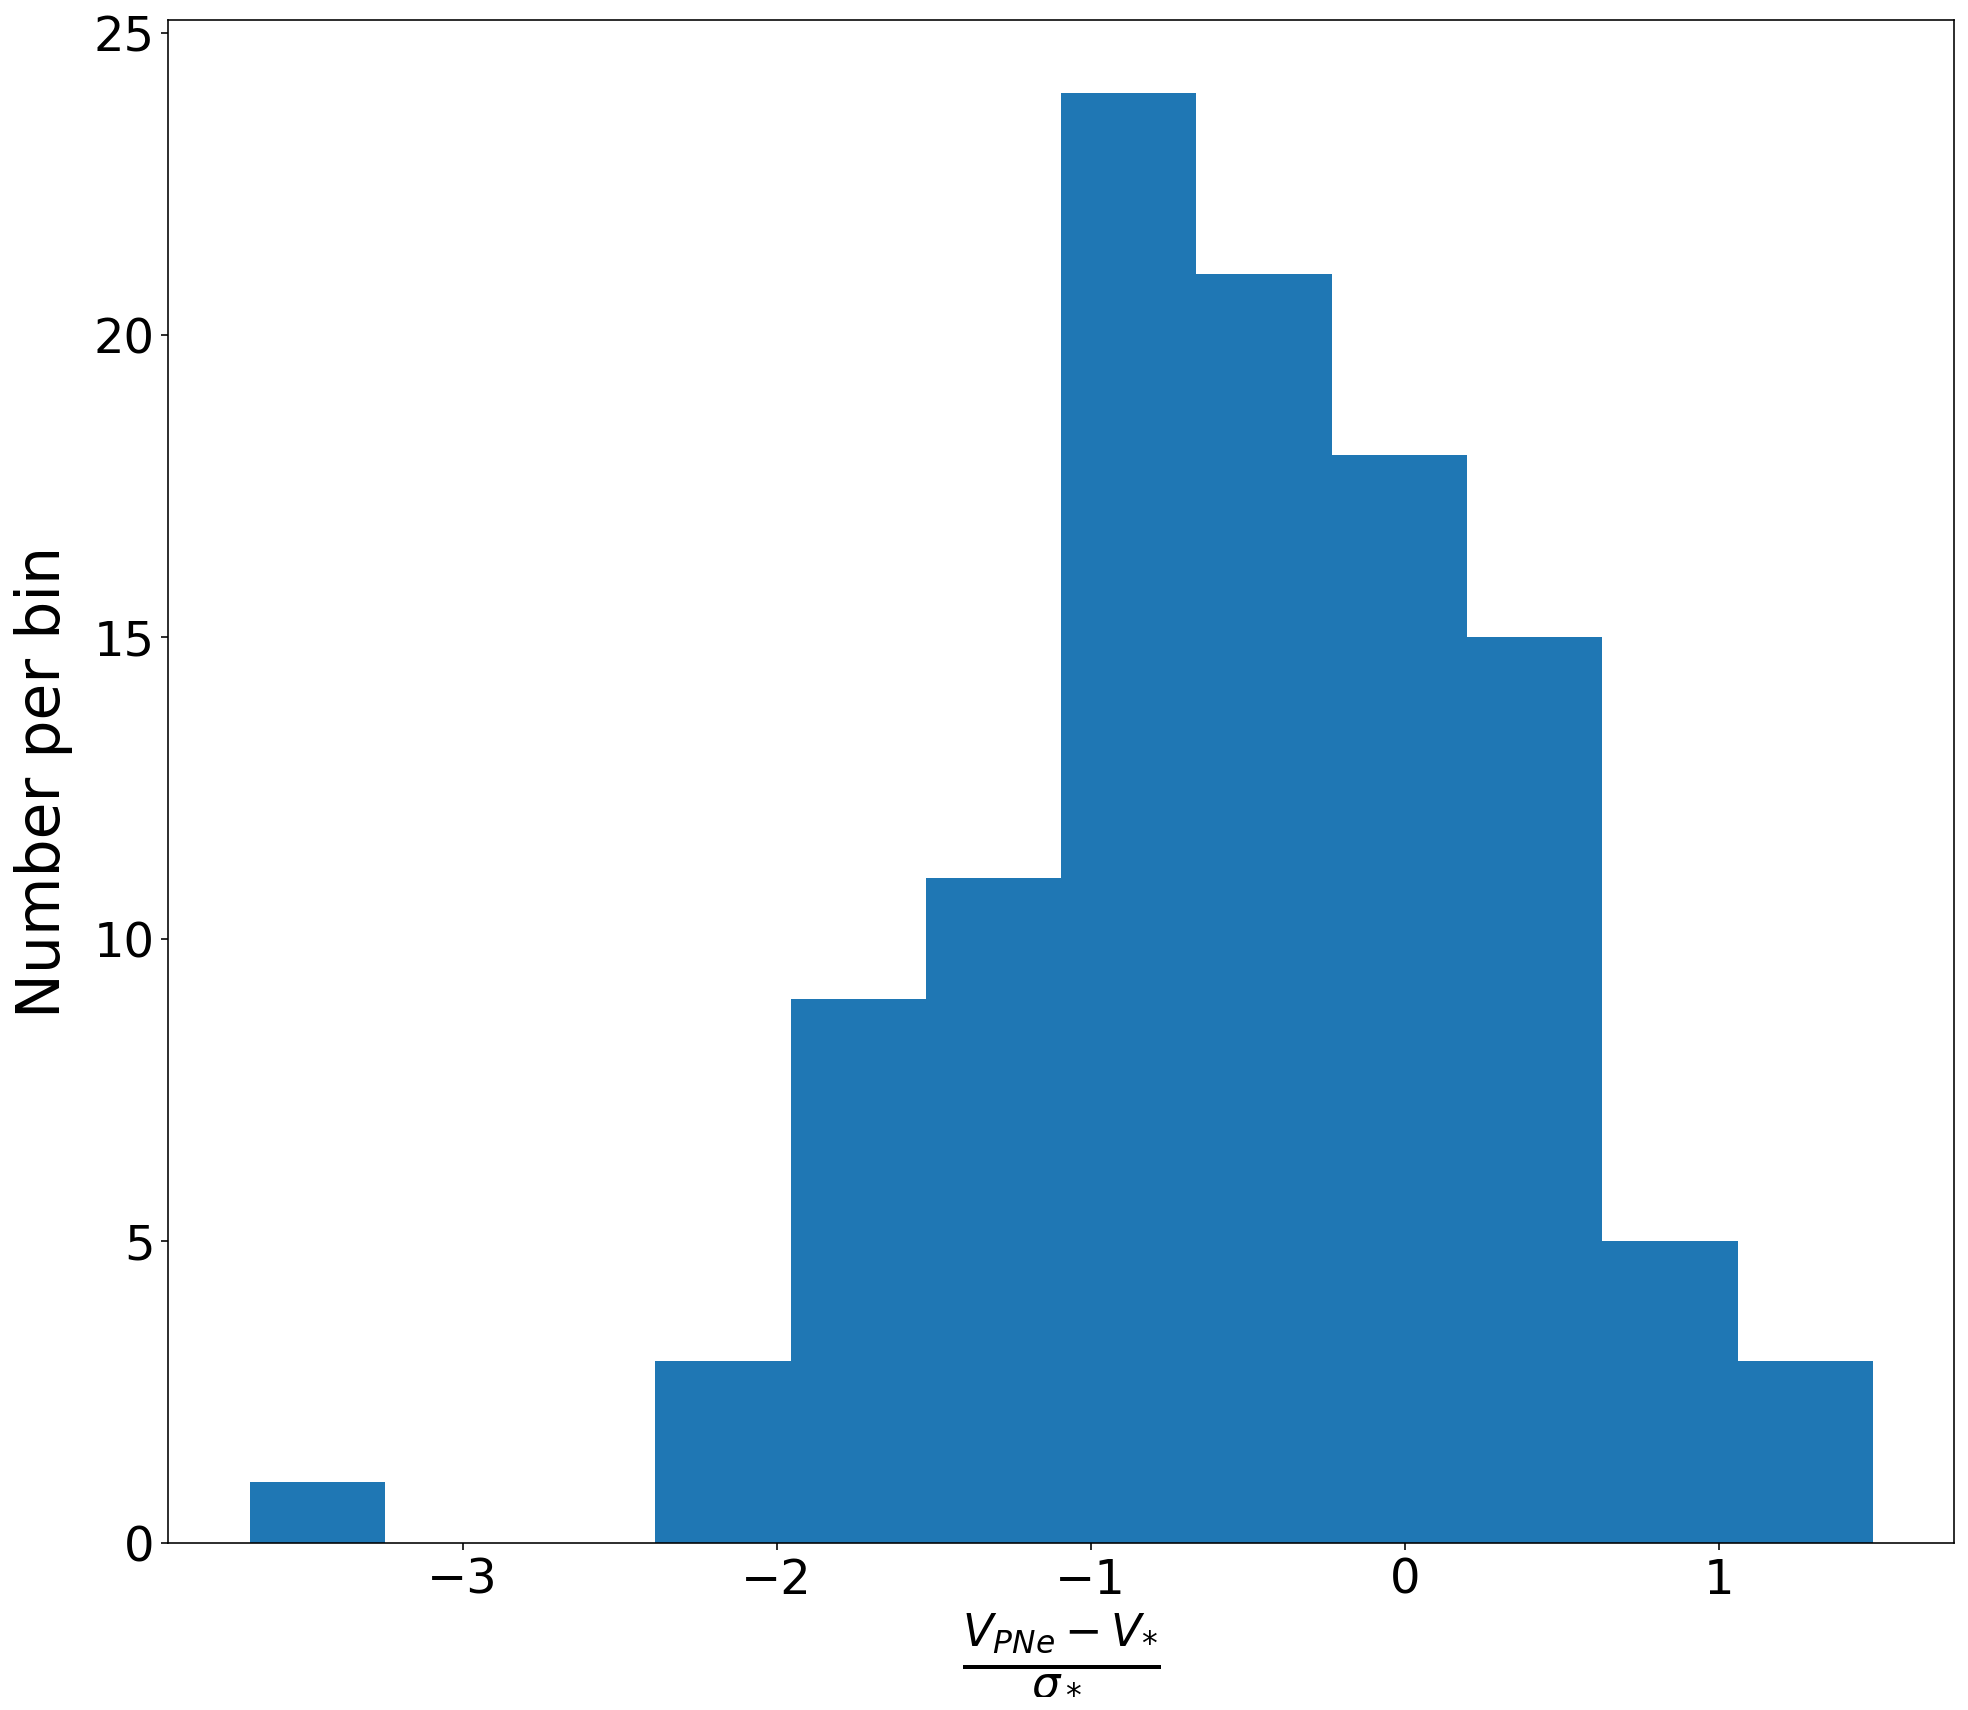

In [84]:
plt.figure(44, figsize=(16,14))
plt.clf()
plt.hist(vel_ratio[f_ind], bins=12)
plt.xlabel(r"$\frac{V_{PNe} - V_{*}}{\sigma_*}$", fontsize=32)
plt.ylabel("Number per bin", fontsize=30, labelpad=10)
plt.tick_params(labelsize = 24)
#plt.xlim(-3,3)
#plt.ylim(0,50)
#plt.savefig(PLOT_DIR"_velocity_plot.pdf", bbox_inches='tight')

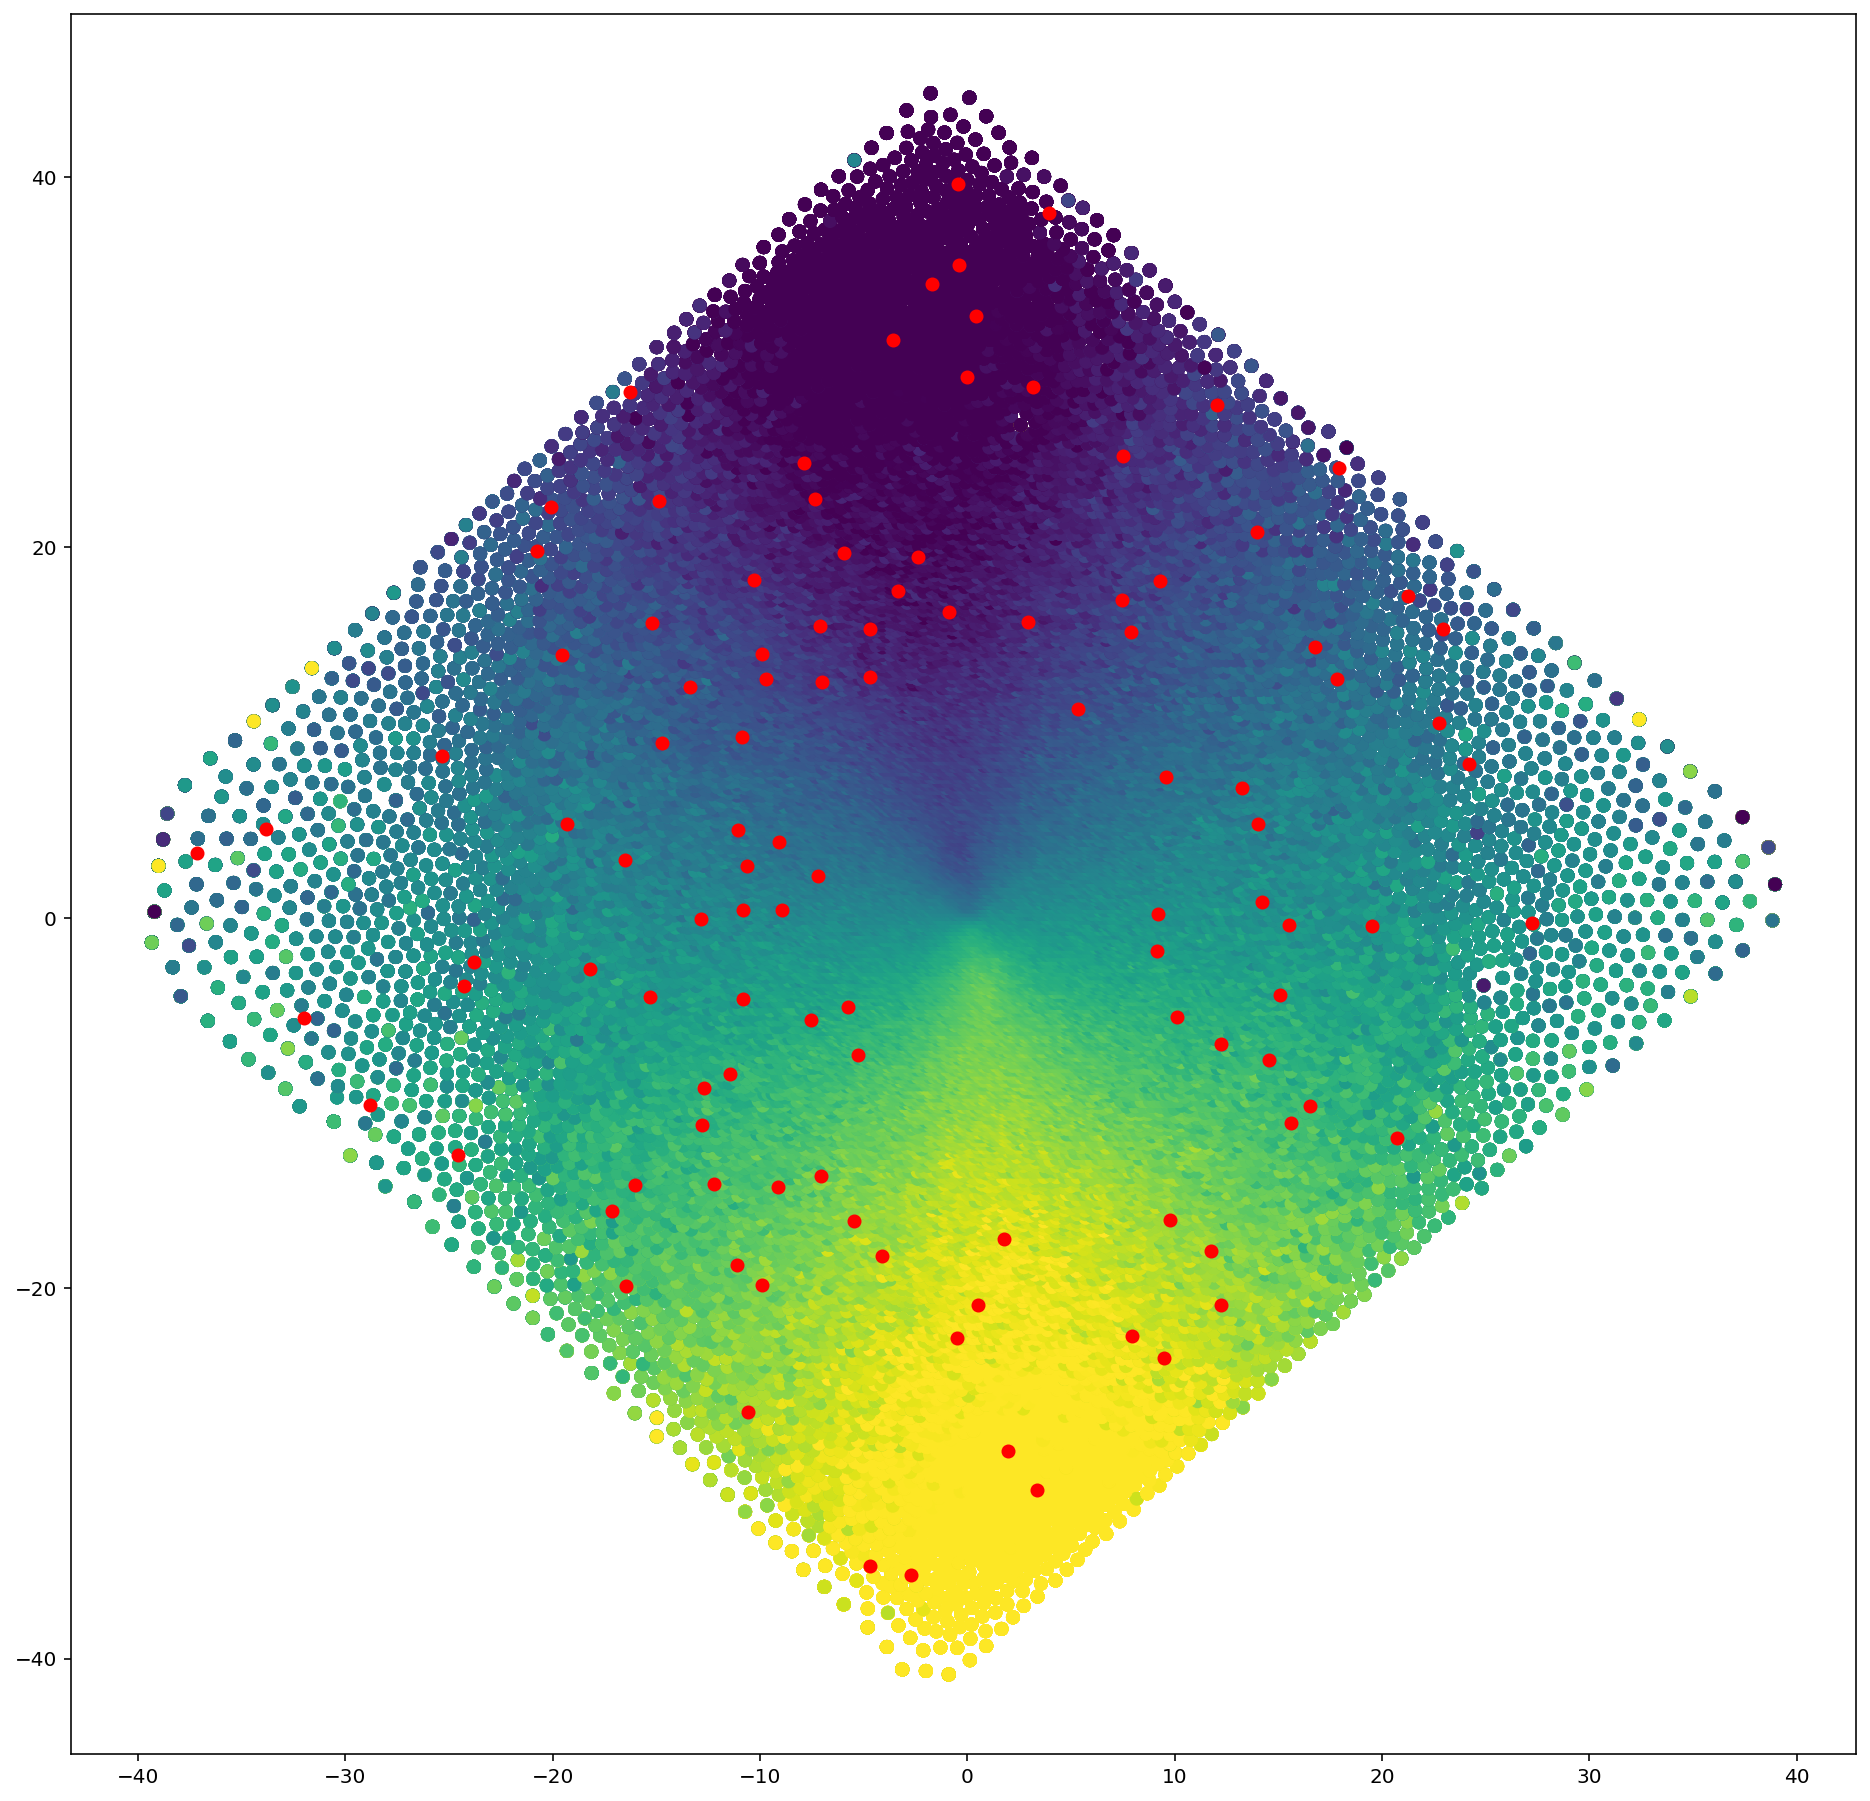

In [81]:
plt.figure(figsize=(16,16))
plt.scatter(X_star, Y_star, c=v_star, vmin=-150, vmax=150)
plt.scatter(xpne,ypne,c="r")
#plt.colorbar()

## Table setup for Marc

In [17]:
## Tables for Marc
y_idx = PNe_df.loc[PNe_df["Filter"]=="Y"].index.values
n_idx = PNe_df.loc[PNe_df["Filter"]=="N"].index.values

tab_all = Table([PNe_df["PNe number"].values, 
                 PNe_df["A/rN"].values, 
                 PNe_df["Chi2"].values, 
                 A_2D_list[:,0], x_PNe, y_PNe, objects["peak"], mean_wave_list[:,0]], 
                names=("PNe #","fit A/rN", "Chi2", "A", "x", "y", "SEP A/rN", "best_fit_wave"))

tab_filter = Table([PNe_df["PNe number"].loc[PNe_df["Filter"]=="Y"], 
                    PNe_df["A/rN"].loc[PNe_df["Filter"]=="Y"].values, 
                    PNe_df["Chi2"].loc[PNe_df["Filter"]=="Y"].values, A_2D_list[y_idx,0], x_PNe[y_idx], y_PNe[y_idx], 
                    objects["peak"][y_idx], mean_wave_list[y_idx,0]], 
                   names=("PNe #","fit A/rN", "Chi2", "A", "x", "y", "SEP A/rN", "best_fit_wave"))

ascii.write(tab_all, EXPORT_DIR+galaxy_name+"_SEP_all_data_Table.dat", overwrite=True)
ascii.write(tab_filter, EXPORT_DIR+galaxy_name+"_SEP_filtered_data_Table.dat", overwrite=True)

# PSF determination

In [25]:
PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 94].nlargest(20, "A/rN")

PNe number Ra (J2000) Dec (J2000)    V (km/s)     m 5007    M 5007  \
158         158        NaN         NaN  -76.757871  27.217941 -4.180849   
98           98        NaN         NaN    0.123334  27.231494 -4.167297   
103         103        NaN         NaN -179.470159  27.190021 -4.208769   
57           57        NaN         NaN   64.653550  27.116738 -4.282052   
125         125        NaN         NaN  -61.323970  26.949387 -4.449403   
65           65        NaN         NaN  -67.943802  27.566218 -3.832573   
77           77        NaN         NaN -112.711999  26.878790 -4.520000   
88           88        NaN         NaN -197.803910  27.724338 -3.674452   
33           33        NaN         NaN   15.049048  27.434653 -3.964137   
22           22        NaN         NaN -211.404704  27.802269 -3.596521   
43           43        NaN         NaN -165.122946  27.887703 -3.511087   
68           68        NaN         NaN  -71.186430  27.273656 -4.125134   
93           93        NaN         NaN    2.270017  27.817196 -3.581594   
14           14        NaN         NaN -123.959381  27.771991 -3.626800   
167         167        NaN         NaN  -95.272100  27.969034 -3.429757   
151         151        NaN         NaN   17.361527  28.031705 -3.367086   
162         162        NaN         NaN  -98.498647  27.965850 -3.432940   
66           66        NaN         NaN  -75.037274  27.178032 -4.220759   
123         123        NaN         NaN -116.392616  27.568931 -3.829860   
31           31        NaN         NaN   27.625281  27.994611 -3.404179   

      [OIII] Flux M 5007 error       A/rN rad D    redchi Filter  \
158  4.138314e-17          NaN  23.895437   NaN  1.011015      Y   
98   4.086979e-17          NaN  23.218542   NaN  0.994067      Y   
103  4.246114e-17          NaN  23.039426   NaN  1.011659      Y   
57   4.542602e-17          NaN  22.671266   NaN  0.996318      Y   
125  5.299624e-17          NaN  18.698140   NaN  1.004156      Y   
65   3.002707e-17          NaN  15.512575   NaN  0.996031      Y   
77   5.655667e-17          NaN  14.026463   NaN  1.031918      Y   
88   2.595761e-17          NaN  12.793817   NaN  0.999712      Y   
33   3.389523e-17          NaN  12.540202   NaN  1.009667      Y   
22   2.415974e-17          NaN  12.519539   NaN  0.989357      Y   
43   2.233155e-17          NaN  12.037015   NaN  0.998974      Y   
68   3.931312e-17          NaN  11.901239   NaN  1.027454      Y   
93   2.382986e-17          NaN  11.518132   NaN  0.990160      Y   
14   2.484298e-17          NaN  11.500523   NaN  1.000616      Y   
167  2.071984e-17          NaN  11.397971   NaN  0.996475      Y   
151  1.955772e-17          NaN  10.989792   NaN  0.994724      Y   
162  2.078069e-17          NaN  10.825201   NaN  1.022708      Y   
66   4.293262e-17          NaN  10.754055   NaN  1.013945      Y   
123  2.995213e-17          NaN  10.753061   NaN  1.010890      Y   
31   2.023744e-17          NaN  10.621349   NaN  0.998024      Y   

             Chi2    Flux error  m 5007 error  F[OIII] err percent  
158  15225.885437  7.956394e-19      0.020864             1.922617  
98   14970.649326  8.102569e-19      0.021507             1.982532  
103  15235.578250  8.667399e-19      0.022151             2.041255  
57   15004.549480  8.941149e-19      0.021370             1.968288  
125  15122.589034  1.122852e-18      0.022989             2.118738  
65   15000.232709  6.831380e-19      0.024696             2.275074  
77   15540.682073  1.334599e-18      0.025606             2.359756  
88   15055.669126  6.640055e-19      0.027762             2.558038  
33   15205.591553  8.644687e-19      0.027665             2.550414  
22   14899.723091  6.031553e-19      0.027091             2.496531  
43   15044.551642  5.806296e-19      0.028213             2.600042  
68   15473.456189  1.006244e-18      0.027753             2.559564  
93   14911.813386  6.066882e-19      0.027639             2.545916  
14   15069.276133  6.459368e-19   

[27 60 13 55]
FWHM:  3.760337089560501 +/- 0.05336596564518078 (1.42%)
Beta:  1.657454315131963 +/- 0.08947043058843103 (5.40%)
LSF:  3.018684130136468 +/- 0.024314435547096665 (0.81%)




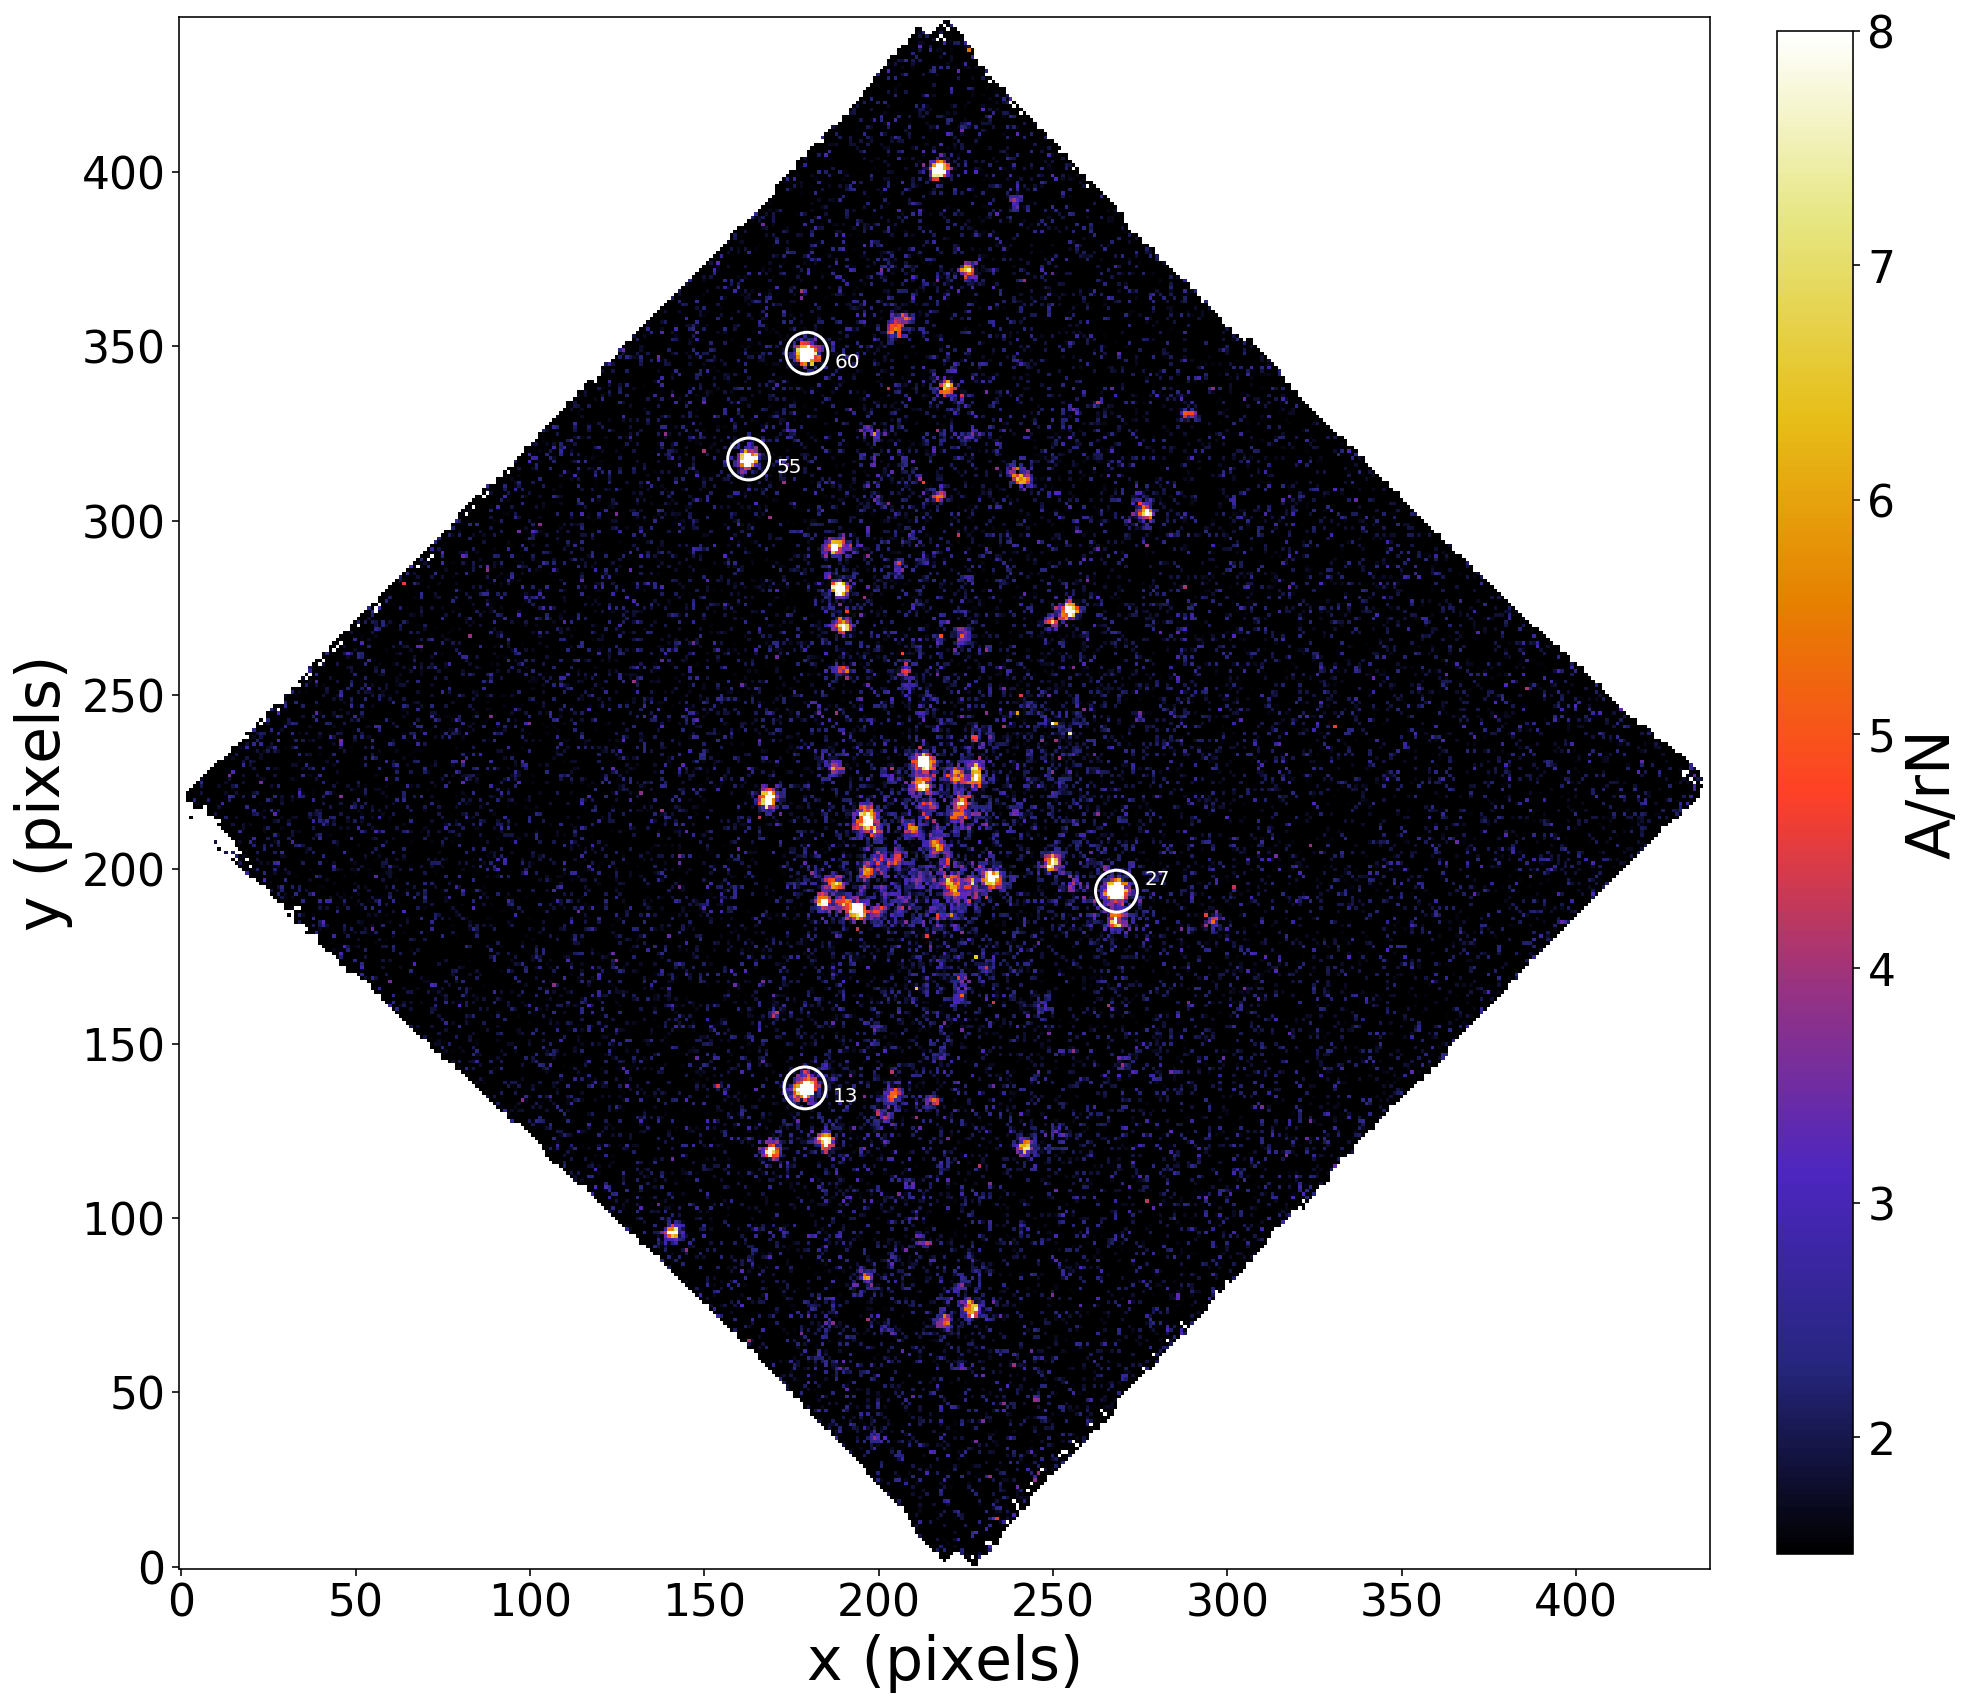

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 163
    # data points      = 60588
    # variables        = 19
    chi-square         = 681347.023
    reduced chi-square = 11.2491047
    Akaike info crit   = 146659.439
    Bayesian info crit = 146830.664
[[Variables]]
    moffat_amp_000:  217.555357 +/- 3.35018604 (1.54%) (init = 200)
    x_000:           3.81602157 +/- 0.02725523 (0.71%) (init = 4.5)
    y_000:           4.03773747 +/- 0.02748190 (0.68%) (init = 4.5)
    wave_000:        5031.81042 +/- 0.01804348 (0.00%) (init = 5033.341)
    gauss_bkg_000:   0 (fixed)
    gauss_grad_000:  0 (fixed)
    moffat_amp_001:  205.917041 +/- 3.28337539 (1.59%) (init = 200)
    x_001:           3.78750892 +/- 0.02953651 (0.78%) (init = 4.5)
    y_001:           4.48364912 +/- 0.02914345 (0.65%) (init = 4.5)
    wave_001:        5029.91419 +/- 0.01940381 (0.00%) (init = 5033.341)
    gauss_bkg_001:   0 (fixed)
    gauss_grad_001:  0 (fixed)
    moffat_amp_002:  201

In [29]:
### Single Run PSF Fitter
#sel_PNe = PNe_df.nsmallest(4, "m 5007").index.values
if galaxy_name == "FCC083":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[(PNe_df["PNe number"] != 40) & (PNe_df["PNe number"] != 60)].nlargest(5, "A/rN").index.values#.loc[PNe_df["PNe number"] != 38].
elif galaxy_name == "FCC119":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(1, "A/rN").index.values
elif galaxy_name == "FCC143":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(1, "A/rN").index.values
elif galaxy_name == "FCC147":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[(PNe_df["PNe number"] != 42)&(PNe_df["PNe number"] != 4)].nlargest(3, "A/rN").index.values
    #sel_PNe = [43,64,19,12,6]
elif galaxy_name == "FCC161":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(7, "A/rN").index.values#.loc[PNe_df["PNe number"] != 38].
elif galaxy_name == "FCC167":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(10, "A/rN").index.values
elif galaxy_name == "FCC177":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(4, "A/rN").index.values
elif galaxy_name == "FCC182":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] !=9].nlargest(3, "A/rN").index.values
    sel_PNe = [6,0,8]
elif galaxy_name == "FCC184":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] !=29].nlargest(3, "A/rN").index.values
#     sel_PNe = [ 8, 71, 67]
elif galaxy_name == "FCC190":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(7, "A/rN").index.values
elif galaxy_name == "FCC193":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 94].nlargest(6, "A/rN").index.values
elif galaxy_name == "FCC219":
    sel_PNe = [58]#PNe_df.loc[PNe_df["Filter"]=="Y"].loc[(PNe_df["PNe number"] != 48) & (PNe_df["PNe number"] != 26)].nlargest(5, "A/rN").index.values
elif galaxy_name == "FCC249":
#     sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(2, "A/rN").index.values
    sel_PNe = [1,19,3]
elif galaxy_name == "FCC255":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(5, "A/rN").index.values
elif galaxy_name == "FCC276":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(6, "A/rN").index.values#.loc[PNe_df["PNe number"] != 21]
elif galaxy_name == "FCC277":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(5, "A/rN").index.values
elif galaxy_name == "FCC301":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 15].nlargest(5, "A/rN").index.values
elif galaxy_name == "FCC310":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[(PNe_df["PNe number"] != 42)].nlargest(7, "A/rN").index.values

#sel_PNe = PNe_df.loc[PNe_df["PNe number"] != 1].nlargest(10, "A/rN").index.values

# sel_PNe = [2,6]#[43,19,12,6]
print(sel_PNe)

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = obj_error_cube[sel_PNe]
PSF_params = Parameters()

def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.01)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.1, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.1, max=n_pixels)
    PSF_params.add("wave_{:03d}".format(n), value=mean, min=mean-15., max=mean+15.)
    PSF_params.add("gauss_bkg_{:03d}".format(n),  value=0.000, vary=False)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.000, vary=False)


for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5006.77*(1+z))    
    
PSF_params.add('FWHM', value=4.0,  min=0.01, vary=True)
PSF_params.add("beta", value=2.5,  min=0.01, vary=True) 
PSF_params.add("LSF",  value=2.81,)# min=0.01, vary=True)

PSF_results = minimize(PSF_residuals_3D, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, z), nan_policy="propagate")

print("FWHM: ", PSF_results.params["FWHM"].value, "+/-", PSF_results.params["FWHM"].stderr, "({:3.2f}%)".format((PSF_results.params["FWHM"].stderr / PSF_results.params["FWHM"].value)*100) )
print("Beta: ", PSF_results.params["beta"].value, "+/-", PSF_results.params["beta"].stderr, "({:3.2f}%)".format((PSF_results.params["beta"].stderr / PSF_results.params["beta"].value)*100) )
print("LSF: " , PSF_results.params["LSF"].value , "+/-", PSF_results.params["LSF"].stderr,  "({:3.2f}%)".format((PSF_results.params["LSF"].stderr  / PSF_results.params["LSF"].value)*100)  )
print("\n")

# Plot locations of PNe used for PSF
plt.figure(figsize=(15,15))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap",  vmin=1.5, vmax=8)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=30)
cb.ax.tick_params(labelsize=22)

plt.xlabel("x (pixels)", fontsize=30)
plt.ylabel("y (pixels)", fontsize=30)

plt.tick_params(labelsize = 22)

#plt.xlim(0,450)
#plt.ylim(0,450)

for (i, item), n in zip(enumerate(x_y_list[sel_PNe]), sel_PNe):
    ax = plt.gca()
    circ = plt.Circle((item[0],item[1]),6, color="white",lw=1.5, fill=False)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(n, (item[0]+8, item[1]-4), color="white", size=10)
    else:
        ax.annotate(n, (item[0]+8, item[1]+2), color="white", size=10)

plt.show()
print(report_fit(PSF_results, show_correl=False))


# PNLF

/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/PNLF.py:65: RuntimeWarning: invalid value encountered in less
  image[image<0] = 0
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/PNLF.py:121: RuntimeWarning: divide by zero encountered in true_divide
  ratio_counter_cen[i] = (np.nansum(image[((a / Noise_mask_cen) > peak)])/np.nansum(image)).astype(np.float128)
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/PNLF.py:121: RuntimeWarning: invalid value encountered in greater
  ratio_counter_cen[i] = (np.nansum(image[((a / Noise_mask_cen) > peak)])/np.nansum(image)).astype(np.float128)


Number of PNe from PNLF:  181.38676601676724 +/- 15.440666916498214


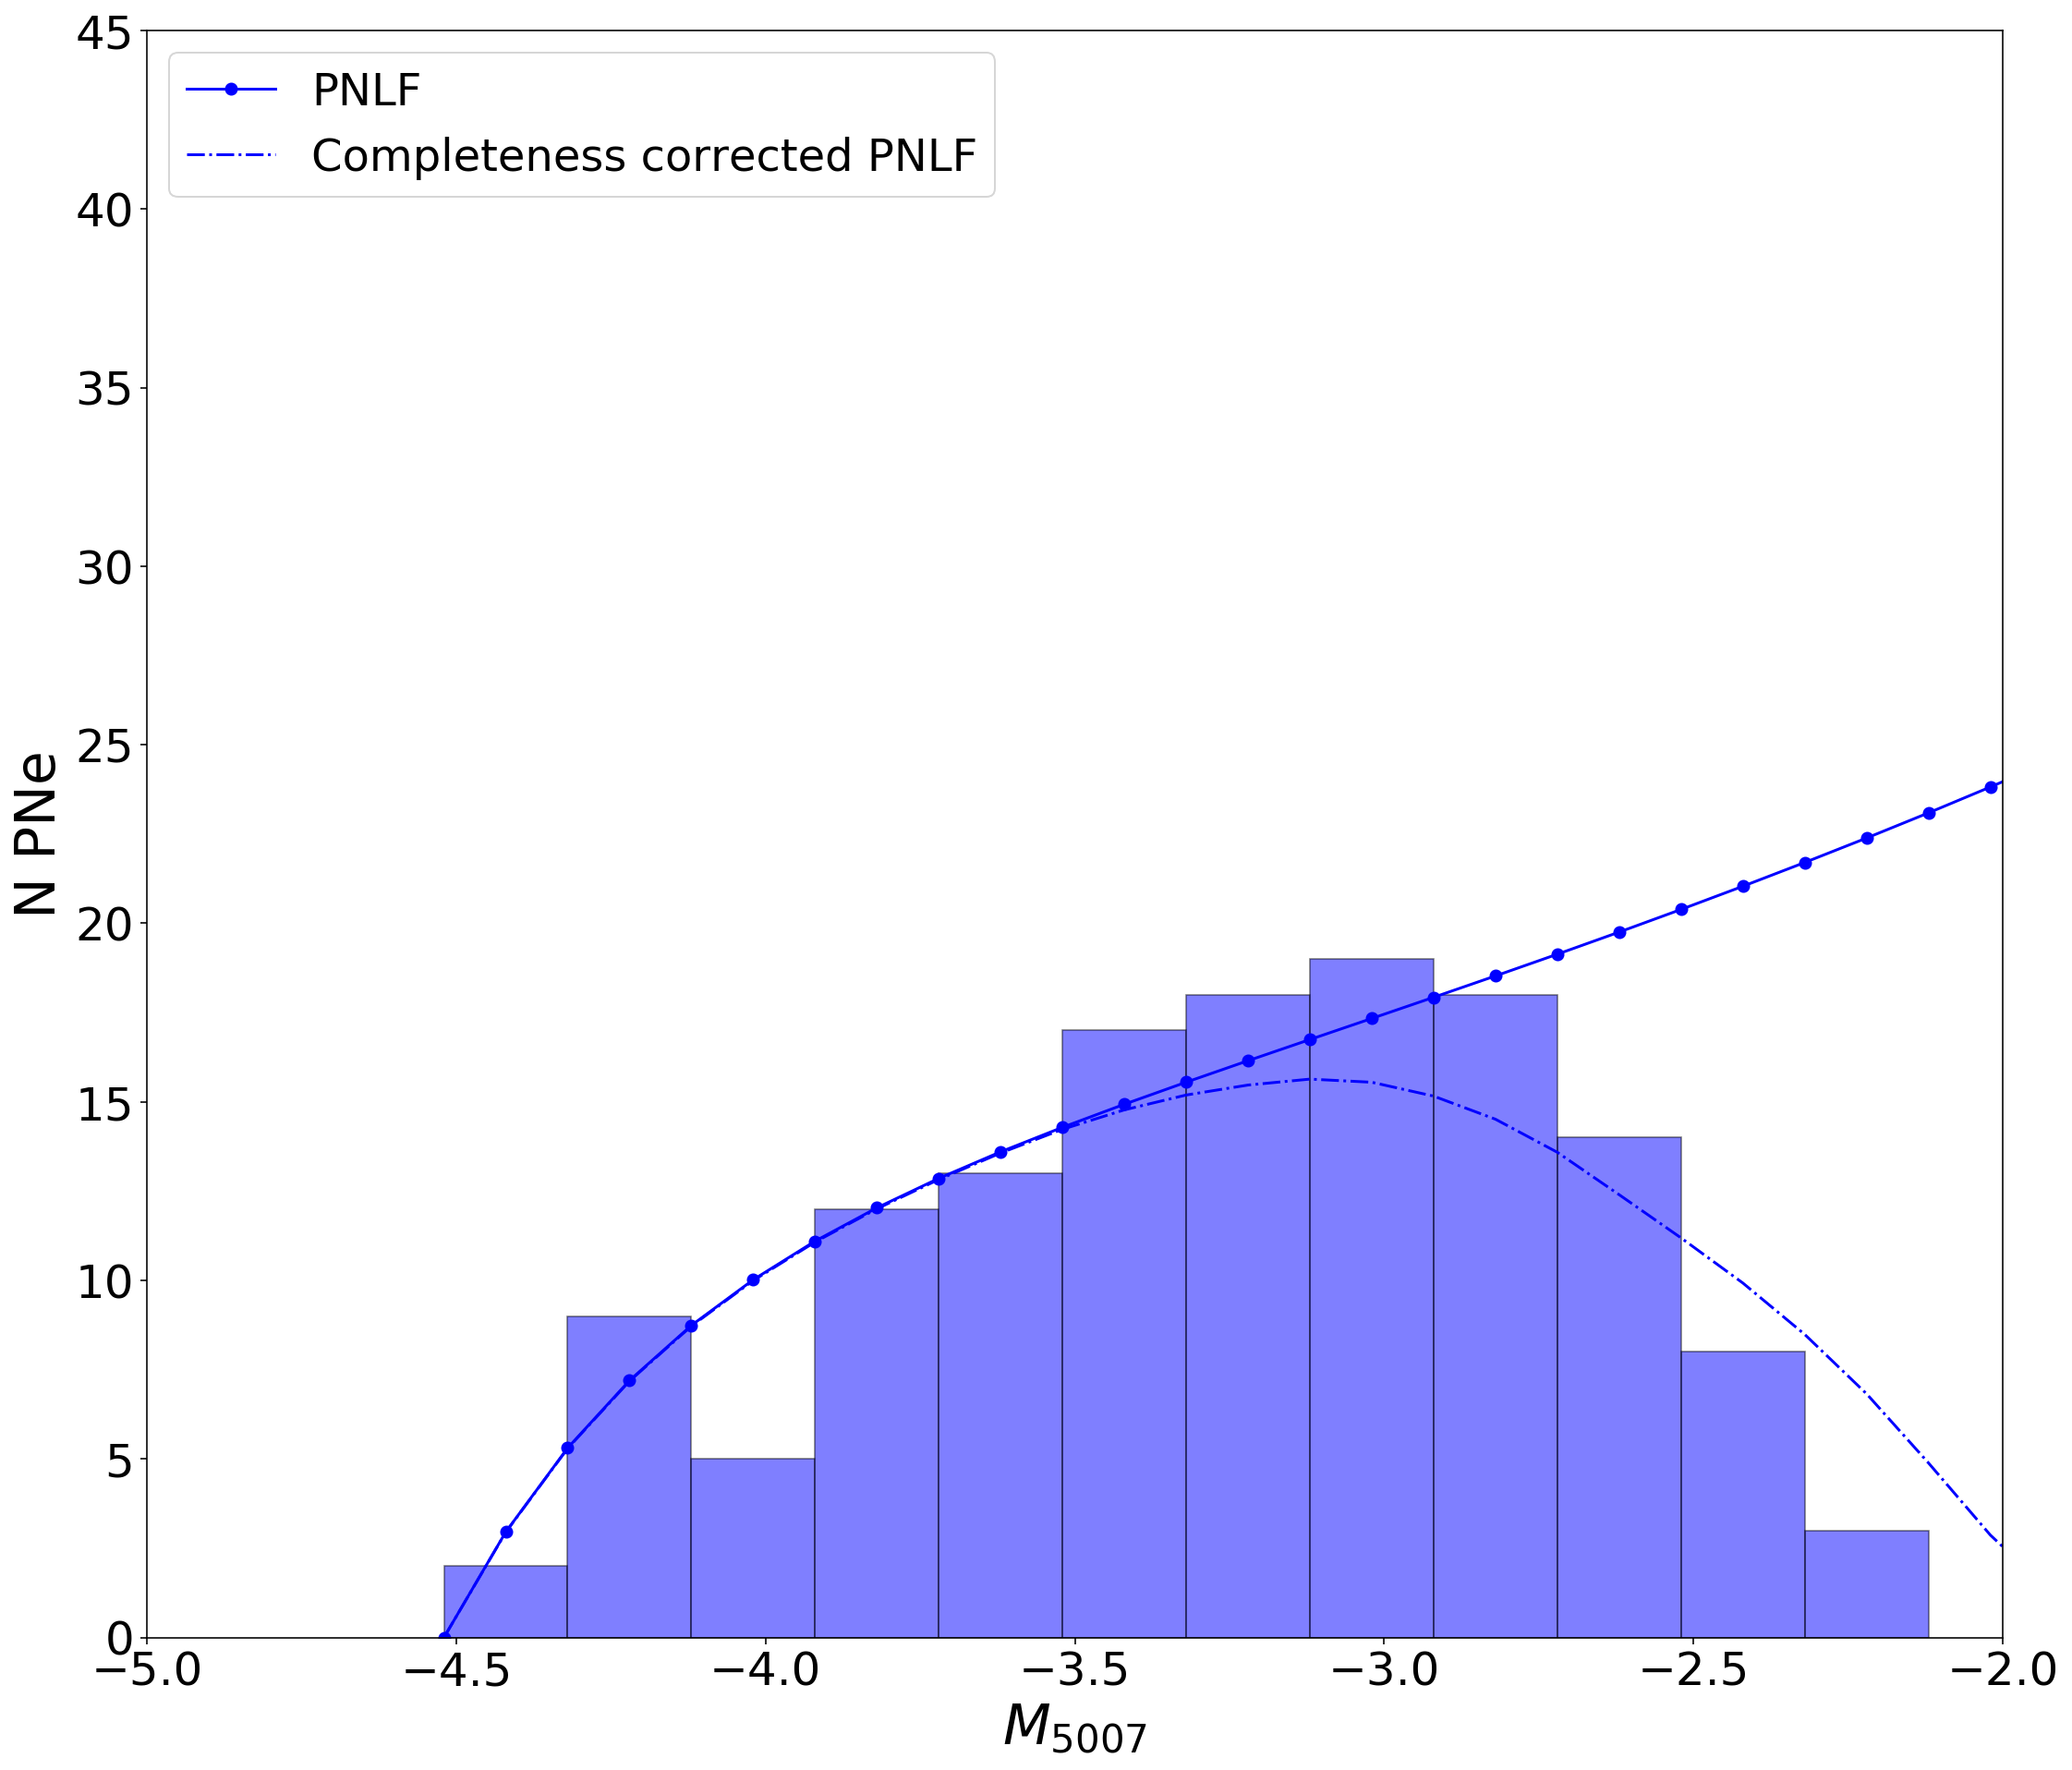

In [31]:
x_data_cen, y_data_cen, map_cen, aux = open_data(galaxy_name)

image, wave = reconstructed_image(galaxy_name)
image = image.reshape([y_data_cen,x_data_cen])

# mag = PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"].values
mag = PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"].values

# Total PNLF
PNLF, PNLF_corr, Abs_M = completeness(galaxy_name, mag, PNe_multi_params, Dist_est, image, peak=3.0,
                                      gal_mask_params=gal_mask_params, star_mask_params=star_mask_params, 
                                      c1=0.307, z=z ) # Estimating the completeness for the central pointing # Dist_est
# #PNLF_plus, PNLF_corr_plus, Abs_M_plus = completeness(galaxy_name, mag, PNe_multi_params, D_est_plus, image, 2.75, mask=True ) # Estimating the completeness for the central pointing
#PNLF_min, PNLF_corr_min, Abs_M_min = completeness(galaxy_name, mag, PNe_multi_params, D_est_plus, image, 2.75, mask=True ) # Estimating the completeness for the central pointing
# PNLF, PNLF_corr, apps_m = completeness(galaxy_name, mag, PNe_multi_params, Dist_est, image, peak=3.,
#                                       gal_mask_params_params=gal_mask_params, star_mask_params_params=star_mask_params, 
#                                       mask=True, c1=0.307, z=z)


# Getting the normalisation
total_norm = np.sum(np.abs(PNLF_corr))*abs(Abs_M[1]-Abs_M[0])
#total_norm_plus = np.sum(PNLF_corr_plus)*abs(Abs_M_plus[1]-Abs_M_plus[0])
#total_norm_min = np.sum(PNLF_corr_min)*abs(Abs_M_min[1]-Abs_M_min[0])

# Scaling factor
scal = len(mag)/total_norm
#scal_plus = len(mag)/total_norm_plus
#scal_min = len(mag)/total_norm_min

# Constraining to -2.0 in magnitude
idx = np.where(Abs_M <= np.min(mag)+2.0)
# Total number of PNe
tot_N_PNe = np.sum(PNLF_corr[idx]*scal)*abs(Abs_M[1]-Abs_M[0])
#tot_N_PNe_plus = np.sum(PNLF_corr_plus[idx]*scal_plus)*abs(Abs_M_plus[1]-Abs_M_plus[0])
#tot_N_PNe_min = np.sum(PNLF_corr_min[idx]*scal_min)*abs(Abs_M_min[1]-Abs_M_min[0])

plt.figure(figsize=(18,16))
#plt.figure(figsize=(12,10))
binwidth = 0.2
hist = plt.hist(mag, bins=np.arange(min(mag), max(mag) + binwidth, binwidth), edgecolor="black", linewidth=0.8, alpha=0.5, color='blue')

ymax = max(hist[0])

plt.plot(Abs_M, PNLF*scal*binwidth, '-', color='blue', marker="o", label="PNLF")
plt.plot(Abs_M, PNLF_corr*scal*binwidth,'-.', color='blue', label="Completeness corrected PNLF")

plt.xlabel('$M_{5007}$', fontsize=30)
plt.ylabel('N PNe', fontsize=30)
#plt.yticks(np.arange(0,ymax+4, 5))

plt.xlim(-5.0,-2.0); plt.ylim(0,45);
#plt.xlim(26.0,30.0); plt.ylim(0,45);

plt.tick_params(labelsize = 25)

#plt.axvline(PNe_df["m 5007"].loc[PNe_df["Filter"]=="Y"].values.min() - 31.63)
plt.legend(loc=2, fontsize=24)
#plt.savefig(PLOT_DIR"_PNLF.pdf", bbox_inches='tight')
#plt.savefig(PLOT_DIR"_PNLF.png", bbox_inches='tight')

step = Abs_M[1]-Abs_M[0]
N_PNe = np.sum(PNLF[:25]*scal*step)
print("Number of PNe from PNLF: ", N_PNe, "+/-", (1/np.sqrt(len(PNe_df.loc[PNe_df["Filter"]=="Y"])))*N_PNe)

## L_Bol using pPXF

In [94]:
PNe_df.loc[15]

PNe number                      15
Ra (J2000)                     NaN
Dec (J2000)                    NaN
V (km/s)                  0.288553
m 5007                     26.7287
M 5007                       -4.52
[OIII] Flux              6.494e-17
M 5007 error                   NaN
A/rN                       10.9901
rad D                          NaN
redchi                     1.00797
Filter                           Y
Chi2                       23099.7
Flux error             2.36268e-18
m 5007 error             0.0394588
F[OIII] err percent        3.63826
Name: 15, dtype: object

100%|██████████| 95985/95985 [00:16<00:00, 5923.44it/s]


Collapsing cube now....
Cube has been collapsed...


/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/ppxf_gal_L.py:149: RuntimeWarning: divide by zero encountered in true_divide
  templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/ppxf_gal_L.py:149: RuntimeWarning: invalid value encountered in true_divide
  templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates


Best Fit:       Vel     sigma        h3        h4
 comp. 0:       490       204    -0.008    -0.004
chi2/DOF: 3.007
method = capfit; Jac calls: 18; Func calls: 367; Status: 2
Nonzero Templates: 3 / 636
Formal errors:
     dV    dsigma   dh3      dh4
 2.5e+02 3.2e+02    0.85    0.57
Elapsed time in PPXF: 487.41 s
24247540796.246853


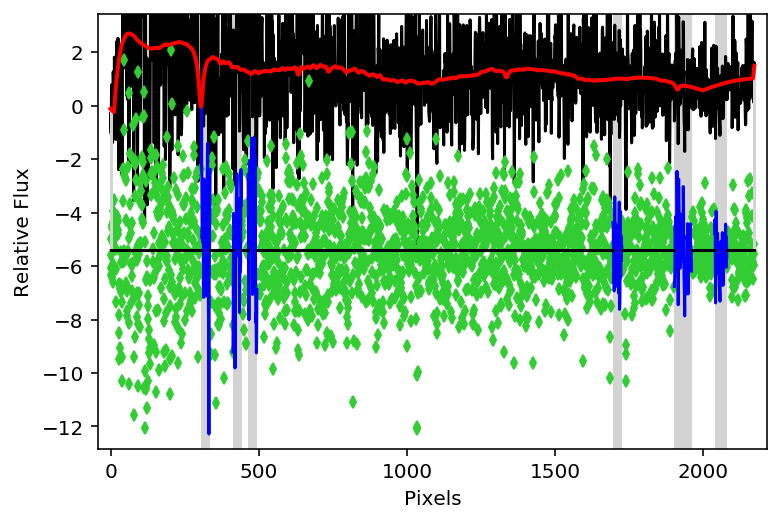

In [8]:

raw_data_cube = RAW_DIR+"center.fits" # read in raw data cube

xe, ye, length, width, alpha = gal_mask_params

orig_hdulist = fits.open(raw_data_cube)
raw_data_cube = np.copy(orig_hdulist[1].data)
h1 = orig_hdulist[1].header
s = np.shape(orig_hdulist[1].data)
Y, X = np.mgrid[:s[1], :s[2]]
elip_mask = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1    

# Now mask the stars
star_mask_sum = np.sum([(Y - yc)**2 + (X - xc)**2 <= rc**2 for xc,yc,rc in star_mask_params],0).astype(bool)
    
    
total_mask = ((np.isnan(orig_hdulist[1].data[1,:,:])==False) & (elip_mask==False) & (star_mask_sum==False))
indx_mask = np.where(total_mask==True)

good_spectra = np.zeros((s[0], len(indx_mask[0])))

for i, (y, x)  in enumerate(zip(tqdm(indx_mask[0]), indx_mask[1])):
    good_spectra[:,i] = raw_data_cube[:,y,x]

print("Collapsing cube now....")    
    
gal_lin = np.nansum(good_spectra, 1)
        
print("Cube has been collapsed...")
dM = 5*np.log10(galaxy_df.loc[galaxy_df["Galaxy"]==galaxy_name, "lit D"].values[0]) +25


L_bol = ppxf_L_tot(int_spec=gal_lin, header=h1, redshift=z, vel=gal_vel, dist_mod=dM)

print(L_bol)

In [ ]:
galaxy_name= "FCC143"
dM = 5*np.log10(galaxy_df.loc[galaxy_df["Galaxy"]==galaxy_name, "lit D"].values[0]) +25
file_name = "/local/tspriggs/Fornax_data_cubes/"+galaxy_name+"center.fits"
# file_name = DATA_DIR+galaxy_name+"center.fits"
galaxy_df = pd.read_csv("exported_data/galaxy_dataframe.csv")


dM = 5*np.log10(galaxy_df.loc[galaxy_df["Galaxy"]==galaxy_name, "lit D"].values[0]) +25
L_bol = ppxf_L_tot(file=file_name, gal_mask_params_params=gal_mask_params, star_mask_params_params=star_mask_params, 
                       redshift=z, vel=gal_vel, dist_mod=dM) #mask=True

print(f"calculated Luminosity of {galaxy_namme} is: {L_bol} L_sol")

In [ ]:
# Print N PNe used after filter and distance values
print(galaxy_name)
n_p = len(PNe_df.loc[PNe_df["Filter"]=="Y"])
print(f"N PNe used:      {n_p}")
print(f"PNLF N:          {N_PNe}")
print(f"L_bol of:        {L_bol}")
print(f"Distance of:     {Dist_est} +/- {Dist_err}")
print(f"Distance Mod of: {dM} +/- {dM_err}")


In [3]:
PNe_df.nsmallest(2, "m 5007")

PNe number    Ra (J2000)    Dec (J2000)    V (km/s)     m 5007  \
25          25  03h36m47.77s  -34d44m25.10s -112.087842  27.030088   
37          37  03h36m47.46s  -34d44m16.72s  -96.016472  27.052467   

    m 5007 error    M 5007   [OIII] Flux M 5007 error       A/rN    redchi  \
25           NaN -4.520000  4.919995e-17          NaN  12.774314  1.016210   
37           NaN -4.497621  4.819624e-17          NaN  12.646999  1.018684   

   Filter          Chi2  Flux error  F[OIII] err percent  
25      Y  15386.432982         NaN                  NaN  
37      Y  15423.887444         NaN                  NaN

In [1]:
%run PNe_fitting.py FCC177


100%|██████████| 65/65 [00:24<00:00,  2.70it/s]
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/MUSE_Models.py:119: RuntimeWarning: invalid value encountered in true_divide
  u2 = (d/(9.0*mad))**2  # c = 9
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/MUSE_Models.py:120: RuntimeWarning: invalid value encountered in less
  good = u2 < 1.0
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/MUSE_Models.py:124: RuntimeWarning: invalid value encountered in double_scalars
  sigma = np.sqrt(num/(den*(den - 1.0)))  # see note in above reference
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/PNLF.py:65: RuntimeWarning: invalid value encountered in less
  image[image<0] = 0
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/PNLF.py:121: RuntimeWarning: divide by zero encountered in true_divide
  ratio_counter_cen[i] = (np.nansum(image[((a / Noise_mask_cen) > peak)])/np.nansum(image)).astype(np.float128)
/auto/data/tspriggs/Jupyterlab_dir/Github

Collapsing cube now....
Cube has been collapsed...


/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/ppxf_gal_L.py:149: RuntimeWarning: divide by zero encountered in true_divide
  templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/ppxf_gal_L.py:149: RuntimeWarning: invalid value encountered in true_divide
  templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates


Best Fit:       Vel     sigma        h3        h4
 comp. 0:      1589        63     0.018     0.014
chi2/DOF: 0.001573
method = capfit; Jac calls: 4; Func calls: 82; Status: 2
Nonzero Templates: 6 / 636
Formal errors:
     dV    dsigma   dh3      dh4
     6.9      14   0.087    0.15
Elapsed time in PPXF: 110.74 s


<Figure size 1800x1600 with 1 Axes>

<Figure size 640x480 with 1 Axes>

Number of PNe after A/rN cut:  61
Number of PNe after A/rN and Reduced chi-square cuts:  61
File saved: exported_data/FCC177/FCC177_table.txt
File saved: exported_data/FCC177/FCC177_table_latex.txt
N PNe used:      61
PNLF N:          88.62172559838548
L_bol of:        3382178825.0720367
Distance of:     20.418209600472053 +/- 0.8889532028454817
Distance Mod of: 31.550088288478957 +/- 0.09453999107176597


In [167]:
def galaxy_df_input(gal_name, PNe_N, PNLF_N, L_bol, R, sigma, metal_M_H, metal_Mg_Fe, age,
                    D_PNLF=np.nan, D_PNLF_err=np.nan, dM_PNLF=np.nan, dM_PNLF_err=np.nan, lit_D=np.nan,
                    FUV=np.nan, FUV_err=np.nan, NUV=np.nan, NUV_err=np.nan, V=np.nan, V_err=np.nan, 
                    R_err=np.nan, B=np.nan, B_err=np.nan, m5007=np.nan, m5007_err=np.nan, lit_Lbol=np.nan, lit_PNLF_N=np.nan):
    
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "D PNLF"]      = D_PNLF
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "D PNLF err"]  = D_PNLF_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "dM PNLF"]     = dM_PNLF
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "dM PNLF err"] = dM_PNLF_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "PNe N"]       = PNe_N
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "PNLF N"]      = PNLF_N
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Lbol"]        = L_bol
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Rmag"]        = R
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Rmag err"]    = R_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "sigma"]       = sigma
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "M/H"]         = metal_M_H
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Mg/Fe"]       = metal_Mg_Fe
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "age"]         = age
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "FUV"]         = FUV
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "FUV err"]     = FUV_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "NUV"]         = NUV
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "NUV err"]     = NUV_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Vmag"]        = V
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Vmag err"]    = V_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Bmag"]        = B
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Bmag err"]    = B_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "m 5007"]      = m5007
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "m 5007 err"]  = m5007_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "lit D"]       = lit_D
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "lit Lbol"]    = lit_Lbol
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "lit PNLF N"]  = lit_PNLF_N




galaxy_df = pd.DataFrame(columns=("Galaxy", "D PNLF", "D PNLF err", "dM PNLF", "dM PNLF err", "PNe N", "PNLF N", "N err", "Lbol", "lit Lbol",
                                  "alpha2.5", "alpha2.5 err", "age", "lit D", "FUV", "FUV err", "NUV", "NUV err", "Vmag", "Vmag err", 
                                  "Rmag", "Rmag err", "Bmag", "Bmag err", "B-V", "sigma", "M/H", "Mg/Fe", "m 5007", "m 5007 err"))

F3D_galaxies = ["FCC083", "FCC143", "FCC147","FCC161", "FCC167", "FCC177","FCC182", "FCC184", "FCC190", 
                "FCC193", "FCC219", "FCC249", "FCC255", "FCC276","FCC277", "FCC301", "FCC310" ]

galaxy_df["Galaxy"] = F3D_galaxies

# FCC083
galaxy_df_input("FCC083", PNe_N=58, PNLF_N=98.1, L_bol=4_723_812_743.977792, lit_Lbol=4_851_065_531.00737, R=10.84, 
                sigma=103, metal_M_H = -0.20, metal_Mg_Fe=0.26, age=13.2,
                D_PNLF=19.100, D_PNLF_err=0.7636, dM_PNLF=31.405, dM_PNLF_err=0.087, lit_D = 19.23, lit_PNLF_N=98.2,
                m5007=26.753, m5007_err=0.028, FUV=np.nan, )

# FCC143 - Lbol returns nan
galaxy_df_input("FCC143", PNe_N=14, PNLF_N=16.5, L_bol=np.nan, R=12.66, 
                sigma=62, metal_M_H=-0.18, metal_Mg_Fe=0.18, age=12.6,
                D_PNLF=17.54, D_PNLF_err=1.468, dM_PNLF=31.220, dM_PNLF_err=0.182, lit_D = 17.54,
                m5007=27.579, m5007_err=0.09)

# FCC147
galaxy_df_input("FCC147", PNe_N=62, PNLF_N=107.9, L_bol=5_452_276_307.090713, lit_Lbol=6_134_382_862.249334, R=10.50, 
                sigma=131, metal_M_H=0.04, metal_Mg_Fe=0.23, age=13.5,
                D_PNLF=18.908, D_PNLF_err=0.7948, dM_PNLF=31.383, dM_PNLF_err=0.091, lit_D = 20.51, lit_PNLF_N=127.3,
                m5007=26.863, m5007_err=0.042)


# FCC161
galaxy_df_input("FCC161", PNe_N=101, PNLF_N=166.6, L_bol=8_652_146_412.916874, lit_Lbol=6815479441.900765, R=10.47, 
                sigma=96, metal_M_H=-0.13, metal_Mg_Fe=0.20, age=12.9,
                D_PNLF=19.875, D_PNLF_err=0.774, dM_PNLF=31.492, dM_PNLF_err=0.085, lit_D = 17.7, lit_PNLF_N=133.3,
                m5007=26.972, m5007_err=0.028)

# FCC167
galaxy_df_input("FCC167", PNe_N=111, PNLF_N=326.5, L_bol=14_427_704_839.93206, lit_Lbol=14370550120.932693, R=9.27, 
                sigma=143, metal_M_H=0.09, metal_Mg_Fe=0.20, age=13.5,
                D_PNLF=18.739, D_PNLF_err=0.769, dM_PNLF=31.363, dM_PNLF_err=0.0891, lit_D = 18.62, lit_PNLF_N=312.7,
                m5007=26.842, m5007_err=0.045)
# FCC177
galaxy_df_input("FCC177", PNe_N=61, PNLF_N=88.6, L_bol=3_382_178_825.0720367, R=11.80, 
                sigma=42, metal_M_H=-0.14, metal_Mg_Fe=0.11, age=9.8,
                D_PNLF=20.42, D_PNLF_err=0.889, dM_PNLF=31.55, dM_PNLF_err=0.095, lit_D=19.86)


# FCC182
galaxy_df_input("FCC182", PNe_N=9, PNLF_N=22.3, L_bol=1_315_240_986.0419338, lit_Lbol=915469188.4100325, R=13.58,
                sigma=39, metal_M_H=-0.22, metal_Mg_Fe=0.11, age=12.6,
                D_PNLF=23.1, D_PNLF_err=1.003, dM_PNLF=31.818, dM_PNLF_err=0.094, lit_D = 19.41, lit_PNLF_N=15.4,
                m5007=27.082, m5007_err=0.049)


# FCC184
galaxy_df_input("FCC184", PNe_N=66, PNLF_N=114.3, L_bol=7_715_931_157.012327, lit_Lbol=5785886952.923201, R=10.00, 
                sigma=143, metal_M_H=0.21, metal_Mg_Fe=0.19, age=13.2,
                D_PNLF=22.106, D_PNLF_err=0.8851, dM_PNLF=31.723, dM_PNLF_err=0.087, lit_D = 19.14)

    
# FCC190
galaxy_df_input("FCC190", PNe_N=17, PNLF_N=32.6, L_bol=2_745_235_179.9273033, lit_Lbol=2029120876.275461, R=12.26, 
                sigma=75, metal_M_H=-0.13, metal_Mg_Fe=0.16, age=12.9,
                D_PNLF=23.327, D_PNLF_err=0.900, dM_PNLF=31.839, dM_PNLF_err=0.084, lit_D = 20.14, lit_PNLF_N=26.2,
                m5007=27.319, m5007_err=0.025)   

# FCC193
galaxy_df_input("FCC193", PNe_N=142, PNLF_N=184.4, L_bol=5_143_867_027.38786, lit_Lbol=5369365945.888745, R=10.69, 
                sigma=95, metal_M_H=-0.09, metal_Mg_Fe=0.13, age=11.7,
                D_PNLF=19.23, D_PNLF_err=0.74, dM_PNLF=31.42, dM_PNLF_err=0.084, lit_D = 19.23, lit_PNLF_N=187.9,
                FUV=18.66, FUV_err=0.04, NUV=16.73, NUV_err=0.01,
                m5007=26.879, m5007_err=0.021)

# FCC219
galaxy_df_input("FCC219", PNe_N=69, PNLF_N=166.9, L_bol=12_405_974_972.815886, lit_Lbol=13682820566.074028, R=8.57, 
                sigma=154, metal_M_H=0.14, metal_Mg_Fe=0.18, age=11.7,
                D_PNLF=17.907, D_PNLF_err=0.7694, dM_PNLF=31.265, dM_PNLF_err=0.093, lit_D = 18.79, lit_PNLF_N=166.,
                m5007=26.745, m5007_err=0.036)


# FCC249
galaxy_df_input("FCC249", PNe_N=9, PNLF_N=33.5, L_bol=3_811_992_310.5510464, lit_Lbol=3346355920.280593, R=12.07, 
                sigma=104, metal_M_H=-0.26, metal_Mg_Fe=0.24, age=13.5,
                D_PNLF=21.945, D_PNLF_err=0.904, dM_PNLF=31.71, dM_PNLF_err=0.089, lit_D = 23.12, lit_PNLF_N=33.,
                FUV=19.796, FUV_err=0.162, NUV=17.73, NUV_err=0.051, V=12.59, V_err=0.08,
                m5007=27.076, m5007_err=0.033, B=13.56,)

# FCC255
galaxy_df_input("FCC255", PNe_N=37, PNLF_N=67.6, L_bol=np.nan, R=12.57, 
                sigma=38, metal_M_H=-0.17, metal_Mg_Fe=0.1, age=4.6,
                D_PNLF=22.057, D_PNLF_err=0.875, dM_PNLF=31.718, dM_PNLF_err=0.086, lit_D = 19.77,
                m5007=27.164, m5007_err=0.030, B=13.86)


# FCC276
galaxy_df_input("FCC276", PNe_N=71, PNLF_N=142.2, L_bol=6_210_993_786.253646, lit_Lbol=6038307972.658742, R=10.15, 
                sigma=123, metal_M_H=-0.25, metal_Mg_Fe=0.20, age=13.8,
                D_PNLF=20.171, D_PNLF_err=0.8133, dM_PNLF=31.524, dM_PNLF_err=0.088, lit_D = 19.95, lit_PNLF_N=138.9,
                m5007=27.004, m5007_err=0.033)

# FCC277
galaxy_df_input("FCC277", PNe_N=25, PNLF_N=48.5, L_bol=1_527_225_178.28261, lit_Lbol=1383814378.4746728, R=12.34, 
                D_PNLF=21.499, D_PNLF_err=0.902, dM_PNLF=31.662, dM_PNLF_err=0.091, lit_D = 20.51, lit_PNLF_N=42.3,
                sigma=80, metal_M_H=-0.34, metal_Mg_Fe=0.11, age=11.7, FUV=20.283, FUV_err=0.229,
                NUV=17.962, NUV_err=0.052, B=13.77)


#FCC301
galaxy_df_input("FCC301", PNe_N=23, PNLF_N=59.9, L_bol=780_482_935.1944906, R=12.65, 
                sigma=49, metal_M_H=-0.38, metal_Mg_Fe=0.09, age=10.2,
                D_PNLF=22.724, D_PNLF_err=1.0056, dM_PNLF=31.782, dM_PNLF_err=0.096, lit_D =16.29,
                m5007=27.262, m5007_err=0.048, B=14.08)

# FCC310
galaxy_df_input("FCC310", PNe_N=43, PNLF_N=85.2, L_bol=2_801_704_154.348238, lit_Lbol=2278553565.2250648, R=11.81, 
                sigma=48, metal_M_H=-0.30, metal_Mg_Fe=0.14, age=12.0,
                D_PNLF=21.867, D_PNLF_err=0.9073, dM_PNLF=31.699, dM_PNLF_err=0.09, lit_D=19.77, lit_PNLF_N=70.0,
                m5007=27.179, m5007_err=0.038, B=13.52)



galaxy_df["N err"]  = (1/(galaxy_df["PNe N"]**(1/2)))*galaxy_df["PNLF N"]
galaxy_df["alpha2.5"] = np.log10((galaxy_df["PNLF N"]/galaxy_df["Lbol"]).astype(float))
# galaxy_df["alpha2.5"] = np.log10((galaxy_df["lit PNLF N"]/galaxy_df["lit Lbol"]).astype(float))
galaxy_df["alpha2.5 err"] =  galaxy_df["alpha2.5"] - np.log10(((galaxy_df["PNLF N"]+galaxy_df["N err"])/galaxy_df["Lbol"]).astype(float))


viz_Bai_15 = Vizier(columns=["AsyFUV", "e_AsyFUV", "AsyNUV", "e_AsyNUV", "Bmag", "e_Bmag", "B-V"])

F3D_tables_15 = []
for f in galaxy_df["Galaxy"].values:#F3D_galaxies:
    F3D_tables_15.append(viz_Bai_15.query_object(f, catalog="J/ApJS/220/6/uvgal"))

for i, t in enumerate(F3D_tables_15):
    if len(t) == 0:
        continue
    else:
        galaxy_df.loc[i, "FUV"]      = np.float64(t[0][0]["AsyFUV"]) 
        galaxy_df.loc[i, "FUV err"]  = np.float64(t[0][0]["e_AsyFUV"])
        galaxy_df.loc[i, "NUV"]      = np.float64(t[0][0]["AsyNUV"])
        galaxy_df.loc[i, "NUV err"]  = np.float64(t[0][0]["e_AsyNUV"])
        galaxy_df.loc[i, "Bmag"]     = np.float64(t[0][0]["Bmag"])
        galaxy_df.loc[i, "Vmag err"] = np.float64(t[0][0]["e_Bmag"])
        galaxy_df.loc[i, "B-V"]      = np.float64(t[0][0]["B-V"])

galaxy_df["Vmag"]    = galaxy_df["Bmag"] - galaxy_df["B-V"]
galaxy_df["FUV-V"]   = galaxy_df["FUV"]  - galaxy_df["Vmag"]
galaxy_df["FUV-B"]   = galaxy_df["FUV"]  - galaxy_df["Bmag"]
galaxy_df["FUV-NUV"] = galaxy_df["FUV"]  - galaxy_df["NUV"]
galaxy_df["FUV-R"]   = galaxy_df["FUV"]  - galaxy_df["Rmag"]



# save galaxy_df to fits for safe keeping
galaxy_df.to_csv("exported_data/galaxy_dataframe.csv")
#with open("exported_data/galaxy_dataframe.csv", mode="a") as file:
#    galaxy_df.to_csv(file, header=False)

##### Buzzoni data
list_of_B_g = ["205", "221", "224", "1316", "1344", "1399", "3031", "3115",
                 "3377", "3379", "3384", "4374", "4382", "4406", "4477", "4486",
                 "4594", "4649", "4697", "5128"]

Buzzoni_UV_m_V = [1.19,4.50, 3.51, 5.0, 2.05, 3.43, 3.86, 3.9, 3.55, 4.22, 3.72, 3.42, 2.04, 2.24, 3.41]
Buzzoni_log_a  = np.array([-6.88, -6.77, -6.94, -7.5, -6.75, -7.30, -6.8, -6.59, -6.43, -6.77, -6.42, -6.77, -6.7, -6.89, -7.16, -7.10, -6.66, -7.22, -6.82, -6.3])

Buzzoni_tables_15 = []
for g in list_of_B_g:
    Buzzoni_tables_15.append(viz_Bai_15.query_object("NGC"+g, catalog="J/ApJS/220/6/uvgal"))

B_FUV = np.ones(len(Buzzoni_tables_15))
B_FUV_err = np.ones_like(B_FUV)
B_Bmag = np.ones_like(B_FUV)
B_Vmag_err = np.ones_like(B_FUV)
B_B_m_V = np.ones_like(B_FUV)

for i, t in enumerate(Buzzoni_tables_15):
    if len(t) == 0:
        continue
    else:
        B_FUV[i]      = t[0][0]["AsyFUV"]
        B_FUV_err[i]  = t[0][0]["e_AsyFUV"]
        B_Bmag[i]     = t[0][0]["Bmag"]
        B_Vmag_err[i] = t[0][0]["e_Bmag"]
        B_B_m_V[i]    = t[0][0]["B-V"]

B_Vmag = B_Bmag - B_B_m_V

FUV_index_check = np.concatenate((np.where(B_FUV==1)[0], np.where(np.isnan(B_FUV))[0])) # get the indexes of 1's and nans
V_index_check = np.concatenate((np.where(B_Vmag==0)[0], np.where(np.isnan(B_Vmag))[0]))

# Corrections
B_FUV[1] = 15.84
B_FUV_err[1] = 0.03
B_Vmag[1] = 8.08
B_Vmag_err[1] = 0.05

B_FUV[4] = 17.841
B_FUV_err[4] = 0.053
B_Vmag[4] = 10.75
B_Vmag_err[4] = 0.02

B_FUV[8] = 16.30
B_FUV_err[8] = 0.05

B_FUV[12] = 15.18
B_FUV_err[12] = 0.01
B_Vmag[12] = 9.38
B_Vmag_err[12] = 0.08

B_FUV[17] = 15.15
B_FUV_err[17] = 0.01
B_Vmag[17] = 9.83
B_Vmag_err[17] = 0.08

B_FUV[18] = 16.57
B_FUV_err[18] = 0.02
B_Vmag[18] = 10.00
B_Vmag_err[18] = 0.02


B_FUV_m_V = B_FUV - B_Vmag
B_FUV_m_B = B_FUV - B_Bmag

/local/tspriggs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:171: UserWarning: Warning: converting a masked element to nan.
/local/tspriggs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: UserWarning: Warning: converting a masked element to nan.
/local/tspriggs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:177: UserWarning: Warning: converting a masked element to nan.
/local/tspriggs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:214: UserWarning: Warning: converting a masked element to nan.
/local/tspriggs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:215: UserWarning: Warning: converting a masked element to nan.


/local/tspriggs/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:138: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
/local/tspriggs/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/local/tspriggs/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:130: UserWarning: Warning: converting a masked element to nan.
  return converter(self.iloc[0])


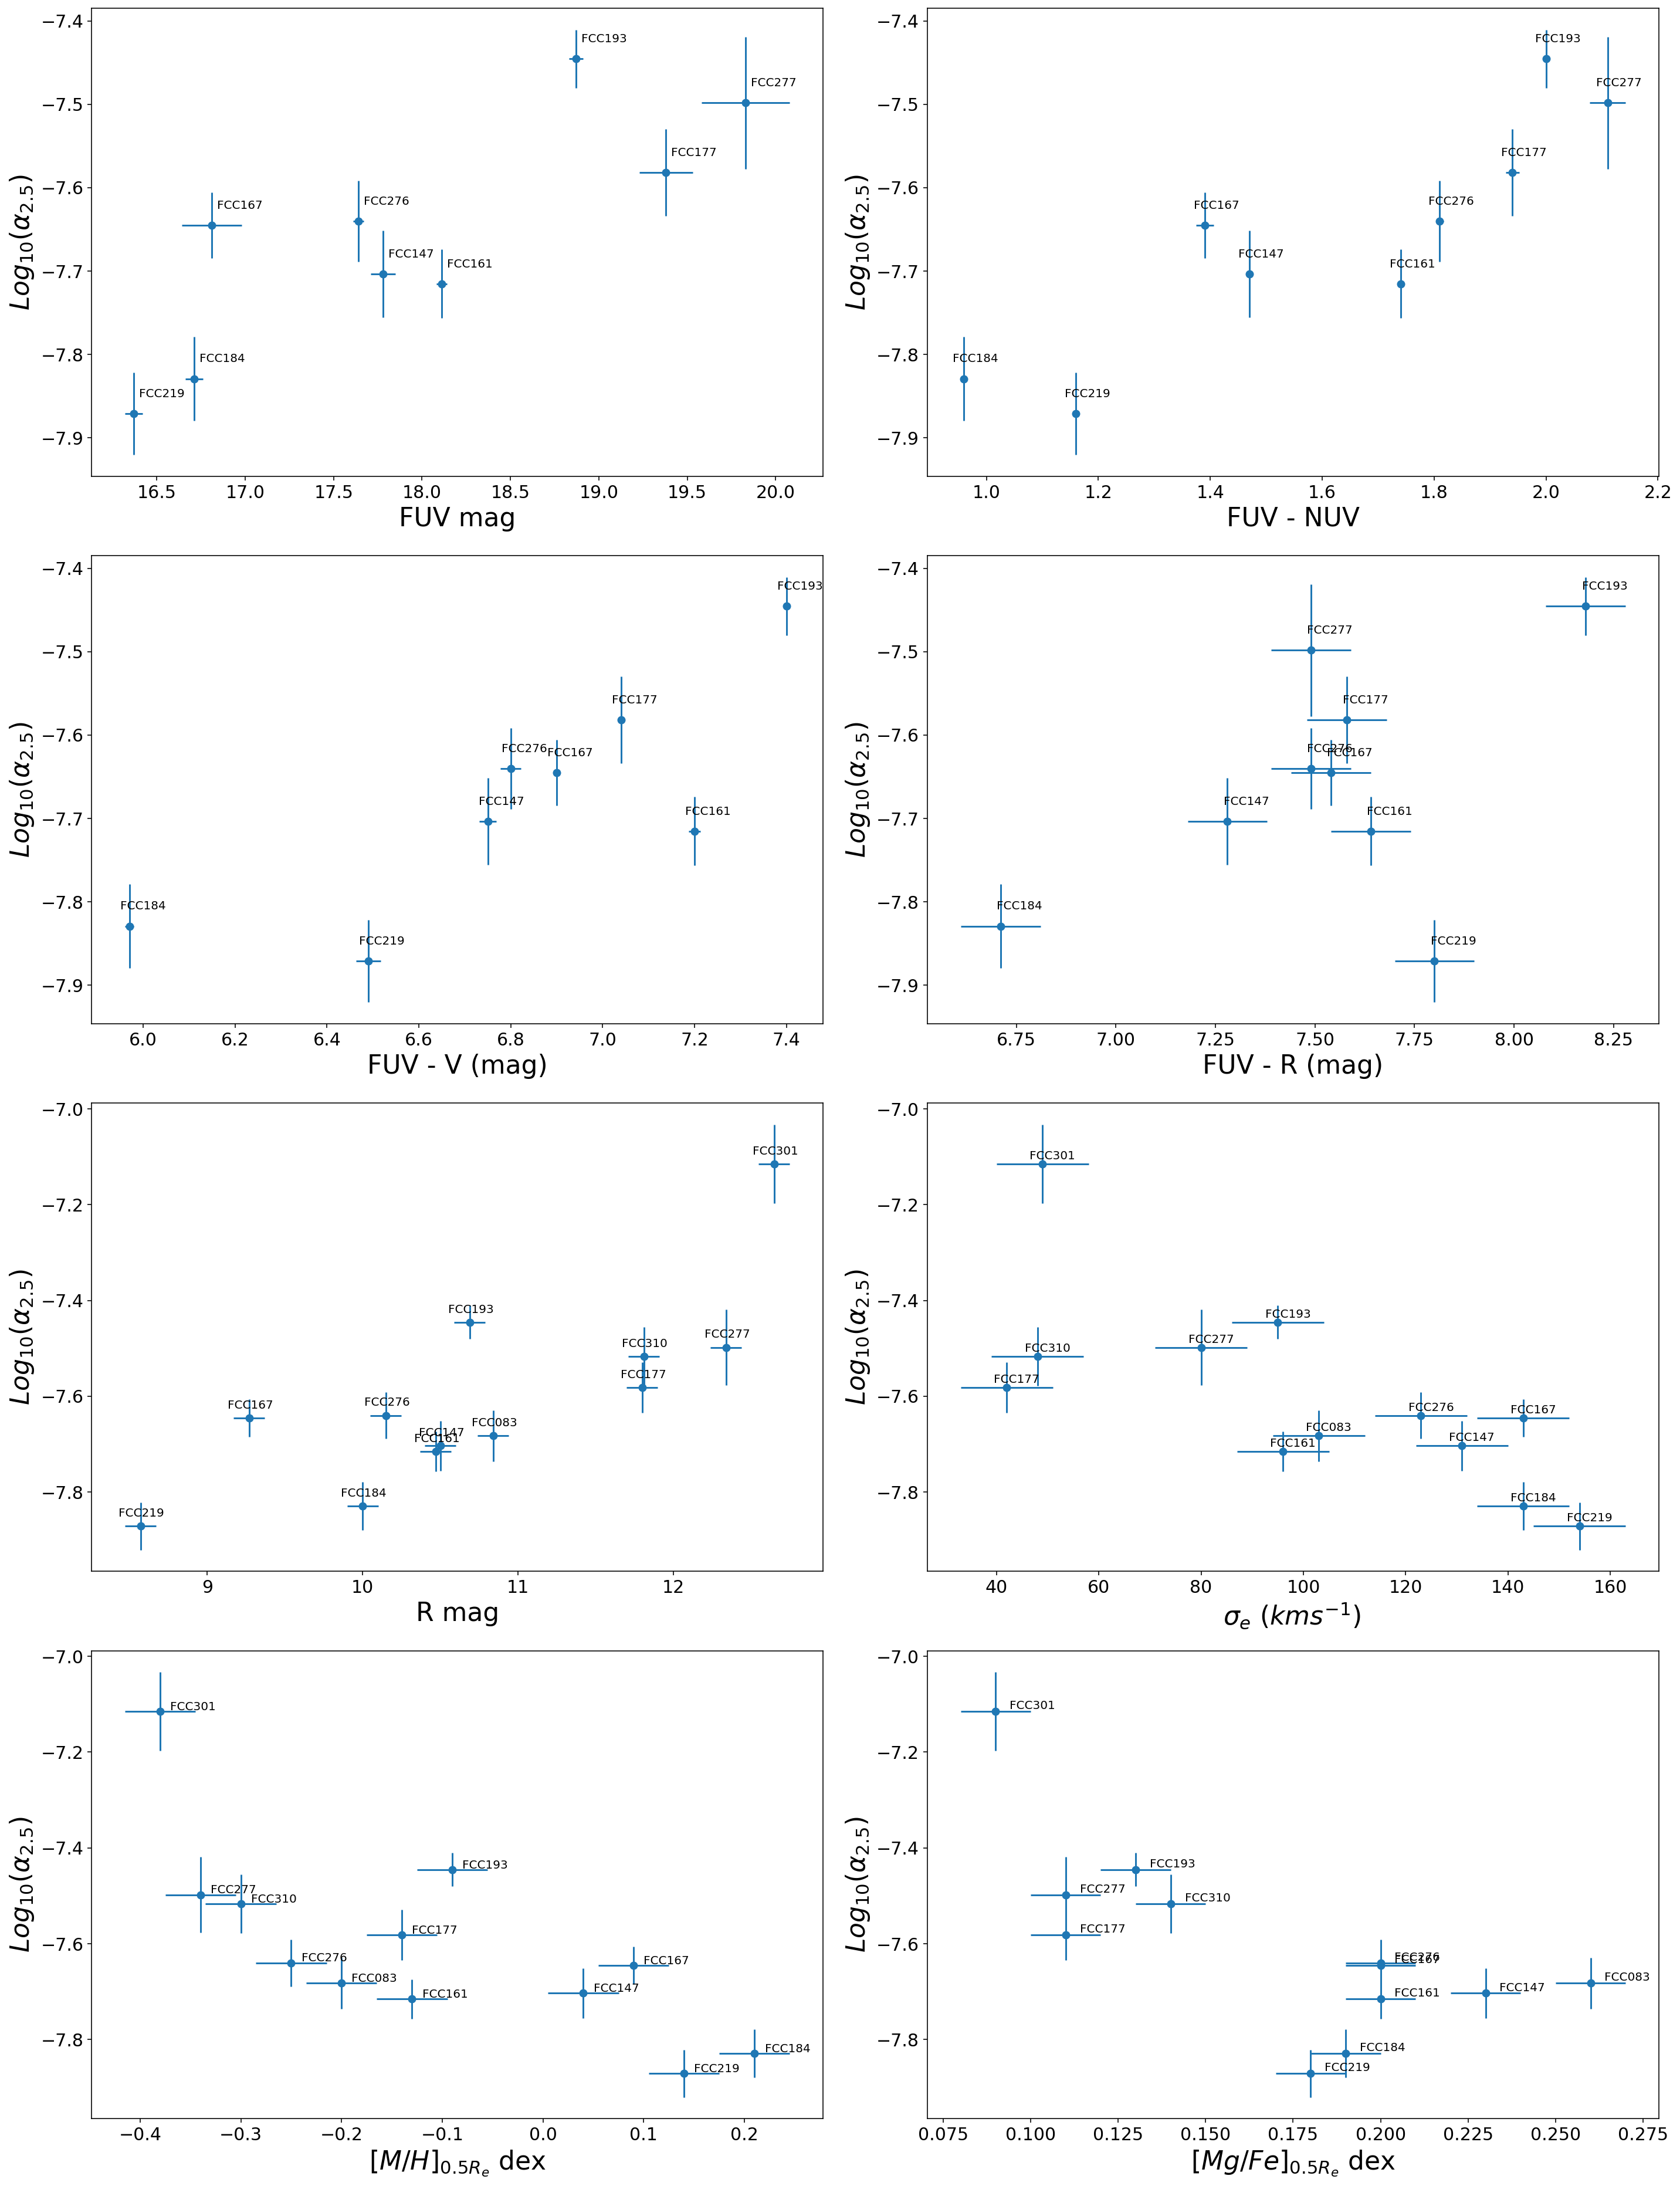

In [46]:
## Pandas version

f_size = 22
l_size = 15

plt.figure(figsize=(20,26))

ax1 = plt.subplot(4,2,1) # FUV
plt.scatter(galaxy_df["FUV"].loc[galaxy_df["PNe N"]>20], galaxy_df["alpha2.5"].loc[galaxy_df["PNe N"]>20])
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel("FUV mag", fontsize=f_size)
plt.errorbar(galaxy_df["FUV"].loc[galaxy_df["PNe N"]>20], galaxy_df["alpha2.5"].loc[galaxy_df["PNe N"]>20], xerr=galaxy_df["FUV err"].loc[galaxy_df["PNe N"]>20], yerr=galaxy_df["alpha2.5 err"].loc[galaxy_df["PNe N"]>20], ls="None")
plt.tick_params(labelsize=l_size)
#ax1.set_ylim(-8,-7)
#ax1 = plt.gca()
for i, name in enumerate(galaxy_df["Galaxy"].loc[galaxy_df["PNe N"]>20]):
    ax1.annotate(name, (galaxy_df["FUV"].loc[galaxy_df["Galaxy"]==name]+0.03, galaxy_df["alpha2.5"].loc[galaxy_df["Galaxy"]==name]+0.02), color="black", size=10)

# FUV - NUV
ax2 = plt.subplot(4,2,2) 
plt.scatter(galaxy_df["FUV-NUV"].loc[galaxy_df["PNe N"]>20], galaxy_df["alpha2.5"].loc[galaxy_df["PNe N"]>20])
plt.errorbar(galaxy_df["FUV-NUV"].loc[galaxy_df["PNe N"]>20], galaxy_df["alpha2.5"].loc[galaxy_df["PNe N"]>20], xerr=(galaxy_df["FUV err"].loc[galaxy_df["PNe N"]>20]**2+galaxy_df["NUV err"].loc[galaxy_df["PNe N"]>20]**2)**1/2, yerr=galaxy_df["alpha2.5 err"].loc[galaxy_df["PNe N"]>20], ls="None")
#plt.errorbar(B_FUV_m_V, Buzzoni_log_a-1, xerr=B_Vmag_err+B_FUV_err, yerr=0.08, c="r", ls="None", label=None)
plt.xlabel("FUV - NUV", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.tick_params(labelsize=l_size)
#plt.ylim(-8,-7)
for i, name in enumerate(galaxy_df["Galaxy"].loc[galaxy_df["PNe N"]>20]):
    ax2.annotate(name, (galaxy_df["FUV-NUV"].loc[galaxy_df["Galaxy"]==name]-0.02,  galaxy_df["alpha2.5"].loc[galaxy_df["Galaxy"]==name]+0.02), color="black", size=10)

# FUV - V
ax3 = plt.subplot(4,2,3) 
plt.scatter(galaxy_df["FUV-V"].loc[galaxy_df["PNe N"]>20], galaxy_df["alpha2.5"].loc[galaxy_df["PNe N"]>20], label="F3D")
#plt.scatter(B_FUV_m_V, Buzzoni_log_a-1, c="r", label=r"Buzzoni 2006 $\alpha$")
plt.errorbar(galaxy_df["FUV-V"].loc[galaxy_df["PNe N"]>20], galaxy_df["alpha2.5"].loc[galaxy_df["PNe N"]>20], xerr=(galaxy_df["NUV err"].loc[galaxy_df["PNe N"]>20]**2+galaxy_df["Vmag err"].loc[galaxy_df["PNe N"]>20]**2)**1/2, yerr=galaxy_df["alpha2.5 err"].loc[galaxy_df["PNe N"]>20], ls="None")
#plt.errorbar(B_FUV_m_V, Buzzoni_log_a-1, xerr=B_Vmag_err+B_FUV_err, yerr=0.08, c="r", ls="None", label=None)
plt.xlabel("FUV - V (mag)", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
#plt.legend(fontsize=l_size, loc=2)
#plt.xlim(4,)
ax3.tick_params(labelsize=l_size)
for i, name in enumerate(galaxy_df["Galaxy"].loc[galaxy_df["PNe N"]>20]):
    ax3.annotate(name, (galaxy_df["FUV-V"].loc[galaxy_df["Galaxy"]==name]-0.02,  galaxy_df["alpha2.5"].loc[galaxy_df["Galaxy"]==name]+0.02), color="black", size=10)

# FUV - R
ax4 = plt.subplot(4,2,4) 
plt.scatter(galaxy_df["FUV-R"].loc[galaxy_df["PNe N"]>20], galaxy_df["alpha2.5"].loc[galaxy_df["PNe N"]>20])
plt.errorbar(galaxy_df["FUV-R"].loc[galaxy_df["PNe N"]>20], galaxy_df["alpha2.5"].loc[galaxy_df["PNe N"]>20], xerr=0.1, yerr=galaxy_df["alpha2.5 err"].loc[galaxy_df["PNe N"]>20], ls="None")
plt.xlabel("FUV - R (mag)", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.tick_params(labelsize=l_size)
#plt.ylim(-8,-7)
for i, name in enumerate(galaxy_df["Galaxy"].loc[galaxy_df["PNe N"]>20]):
    ax4.annotate(name, (galaxy_df["FUV-R"].loc[galaxy_df["Galaxy"]==name]-0.01, galaxy_df["alpha2.5"].loc[galaxy_df["Galaxy"]==name]+0.02), color="black", size=10)
    
# Rmag vs alpha
ax5 = plt.subplot(4,2,5)
plt.scatter(galaxy_df["Rmag"].loc[galaxy_df["PNe N"]>20], galaxy_df["alpha2.5"].loc[galaxy_df["PNe N"]>20])
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel("R mag", fontsize=f_size)
plt.errorbar(galaxy_df["Rmag"].loc[galaxy_df["PNe N"]>20], galaxy_df["alpha2.5"].loc[galaxy_df["PNe N"]>20], xerr=0.1, yerr=galaxy_df["alpha2.5 err"].loc[galaxy_df["PNe N"]>20], ls="None")
plt.tick_params(labelsize=l_size)
#plt.ylim(-8,-7)
for i, name in enumerate(galaxy_df["Galaxy"].loc[galaxy_df["PNe N"]>20]):
    ax5.annotate(name, (galaxy_df["Rmag"].loc[galaxy_df["Galaxy"]==name]-0.14, galaxy_df["alpha2.5"].loc[galaxy_df["Galaxy"]==name]+0.02), color="black", size=10)
    
ax6 = plt.subplot(4,2,6)
plt.scatter(galaxy_df["sigma"].loc[galaxy_df["PNe N"]>20], galaxy_df["alpha2.5"].loc[galaxy_df["PNe N"]>20])
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel(r"$\sigma_{e} \ (km s^{-1})$ ", fontsize=f_size)
plt.errorbar(galaxy_df["sigma"].loc[galaxy_df["PNe N"]>20], galaxy_df["alpha2.5"].loc[galaxy_df["PNe N"]>20], xerr=9.0, yerr=galaxy_df["alpha2.5 err"].loc[galaxy_df["PNe N"]>20], ls="None")
plt.tick_params(labelsize=l_size)
for i, name in enumerate(galaxy_df["Galaxy"].loc[galaxy_df["PNe N"]>20]):
    ax6.annotate(name, (galaxy_df["sigma"].loc[galaxy_df["Galaxy"]==name]-2.5, galaxy_df["alpha2.5"].loc[galaxy_df["Galaxy"]==name]+0.01), color="black", size=10)
    
    
ax7 = plt.subplot(4,2,7) # M/H metallicity
plt.scatter(galaxy_df["M/H"].loc[galaxy_df["PNe N"]>20], galaxy_df["alpha2.5"].loc[galaxy_df["PNe N"]>20])
plt.errorbar(galaxy_df["M/H"].loc[galaxy_df["PNe N"]>20], galaxy_df["alpha2.5"].loc[galaxy_df["PNe N"]>20], xerr=0.035, yerr=galaxy_df["alpha2.5 err"].loc[galaxy_df["PNe N"]>20], ls="None")
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel(r"$[M/H]_{0.5R_{e}}$ dex", fontsize=f_size)
plt.tick_params(labelsize=l_size)
for i, name in enumerate(galaxy_df["Galaxy"].loc[galaxy_df["PNe N"]>20]):
    ax7.annotate(name, (galaxy_df["M/H"].loc[galaxy_df["Galaxy"]==name]+0.01, galaxy_df["alpha2.5"].loc[galaxy_df["Galaxy"]==name]+0.003), color="black", size=10)
    
ax8 = plt.subplot(4,2,8)
plt.scatter(galaxy_df["Mg/Fe"].loc[galaxy_df["PNe N"]>20], galaxy_df["alpha2.5"].loc[galaxy_df["PNe N"]>20])
plt.errorbar(galaxy_df["Mg/Fe"].loc[galaxy_df["PNe N"]>20], galaxy_df["alpha2.5"].loc[galaxy_df["PNe N"]>20], xerr=0.01, yerr=galaxy_df["alpha2.5 err"].loc[galaxy_df["PNe N"]>20], ls="None")
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel(r"$[Mg/Fe]_{0.5R_{e}}$ dex", fontsize=f_size)
plt.tick_params(labelsize=l_size)
for i, name in enumerate(galaxy_df["Galaxy"].loc[galaxy_df["PNe N"]>20]):
    ax8.annotate(name, (galaxy_df["Mg/Fe"].loc[galaxy_df["Galaxy"]==name]+0.004, galaxy_df["alpha2.5"].loc[galaxy_df["Galaxy"]==name]+0.005), color="black", size=10)
    
plt.tight_layout()

#plt.savefig("Plots/Pandas_alpha_comparison_plots.pdf", bbox_inches='tight')
plt.savefig("Plots/Pandas_PNLF_alpha_comparison_plots_filtered.png", bbox_inches='tight')
# plt.savefig("Plots/Pandas_PNLF_alpha_comparison_plots.png", bbox_inches='tight')
#plt.savefig("Plots/Pandas_lit_alpha_comparison_plots.png", bbox_inches='tight')


Text(0.5, 0, 'Fornax Galaxy Name')

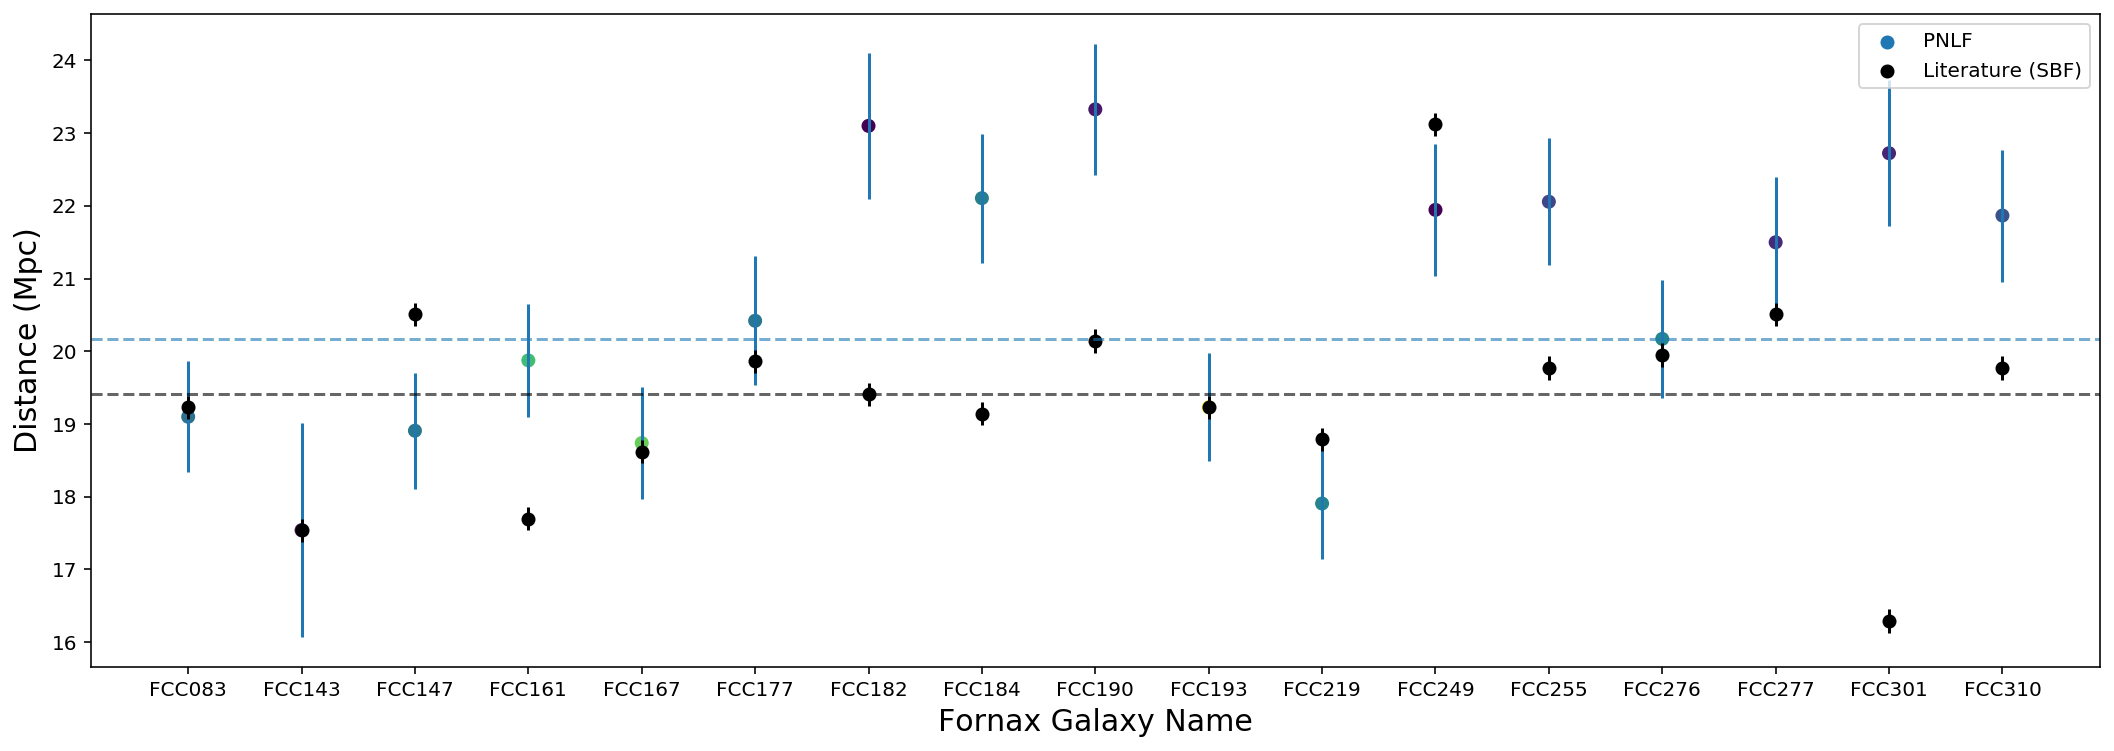

In [10]:
plt.figure(figsize=(18,6))
plt.scatter(galaxy_df["Galaxy"], galaxy_df["D PNLF"], label="PNLF", c=galaxy_df["PNe N"], zorder=0)
plt.scatter(galaxy_df["Galaxy"], galaxy_df["lit D"], label="Literature (SBF)", c="k")
plt.errorbar(galaxy_df["Galaxy"], galaxy_df["D PNLF"], yerr=galaxy_df["D PNLF err"], ls="None", zorder=1)
plt.errorbar(galaxy_df["Galaxy"], galaxy_df["lit D"], yerr=0.16, ls="None", c="k")
plt.axhline(galaxy_df["D PNLF"].loc[galaxy_df["PNe N"]>20].median(), ls="--", alpha=0.6)
plt.axhline(galaxy_df["lit D"].median(), c="k", ls="--", alpha=0.6)
plt.legend()
plt.ylabel("Distance (Mpc)", fontsize=15)
plt.xlabel("Fornax Galaxy Name", fontsize=15)
#plt.savefig("Plots/Distance_comp_lit.png", bbox_inches='tight')

Text(0.5, 0, 'NUV - R')

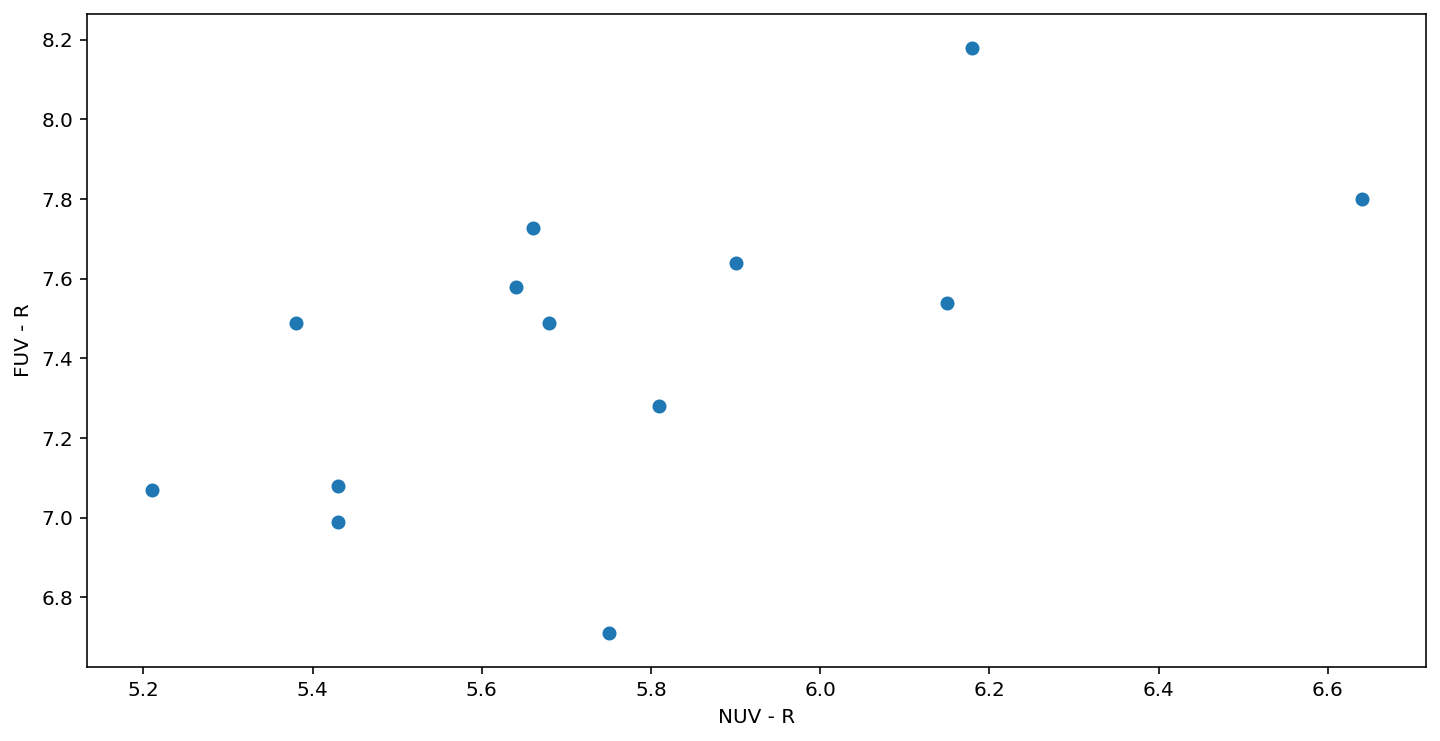

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(galaxy_df["NUV"] - galaxy_df["Rmag"], galaxy_df["FUV-R"])
plt.ylabel("FUV - R")
plt.xlabel("NUV - R")

Text(0.5, 0, 'FUV-NUV')

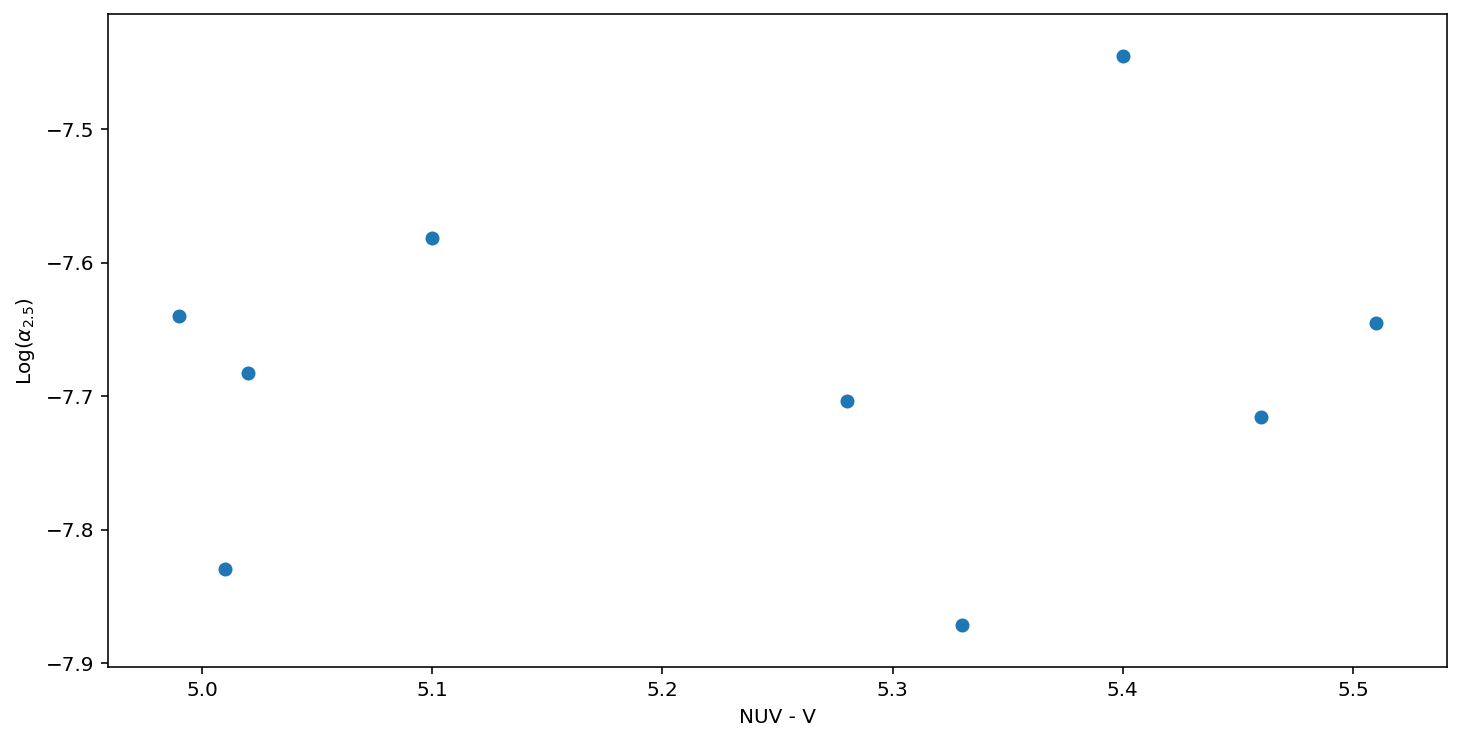

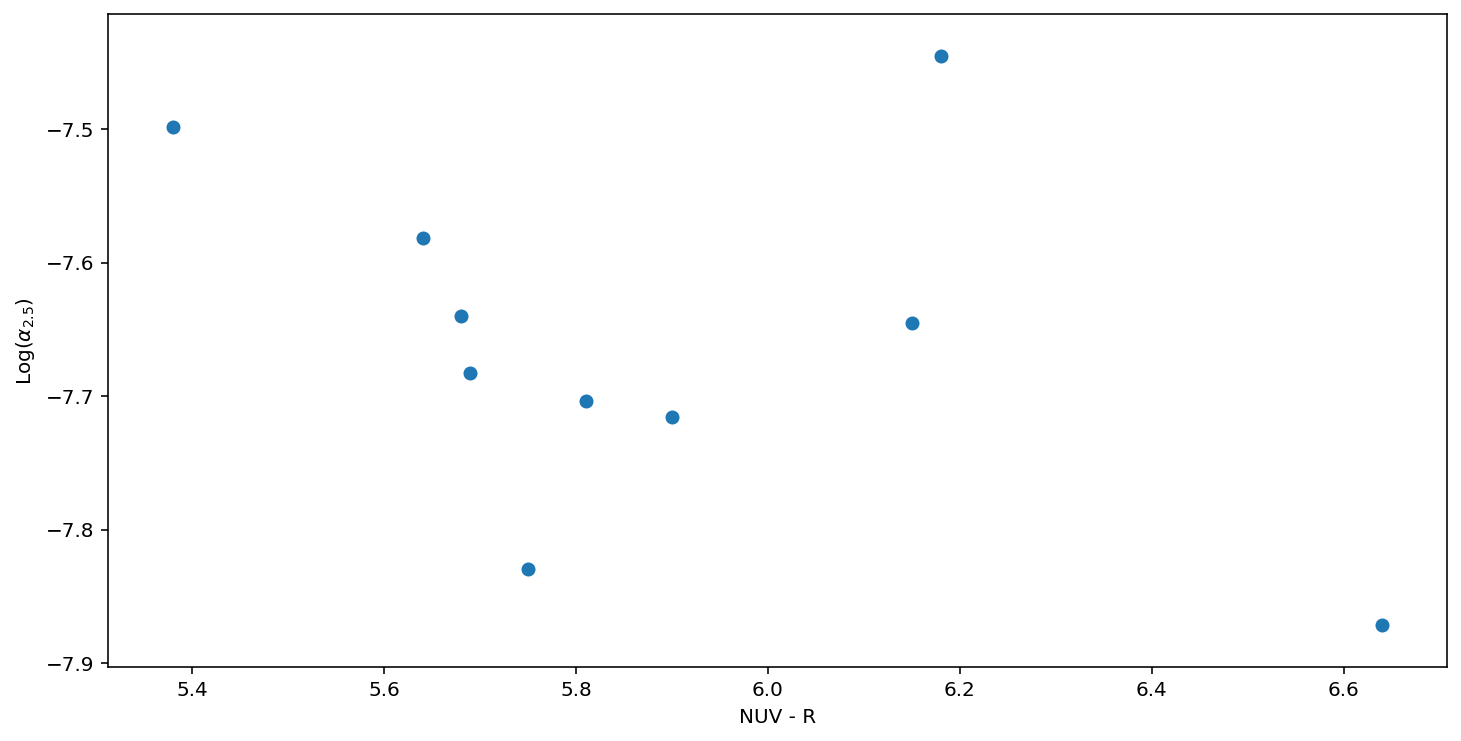

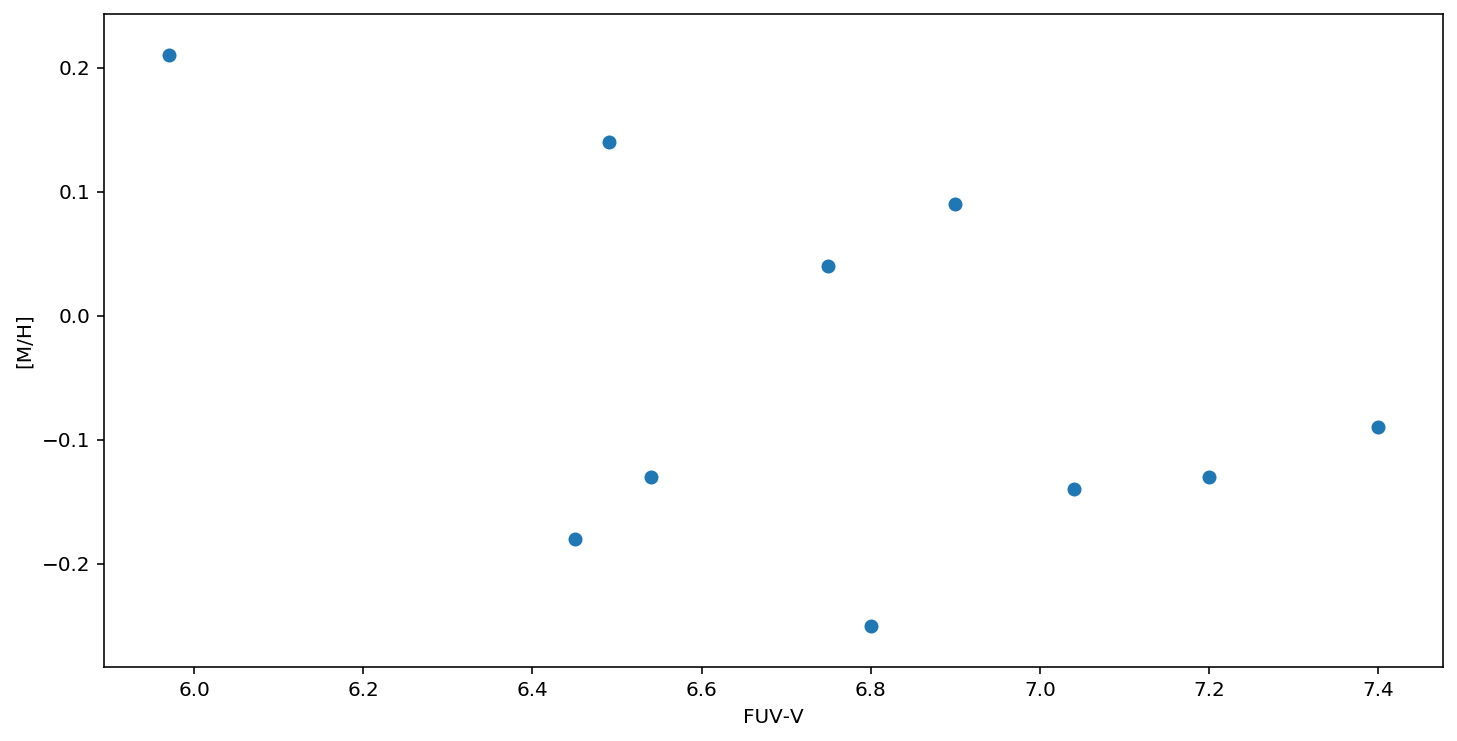

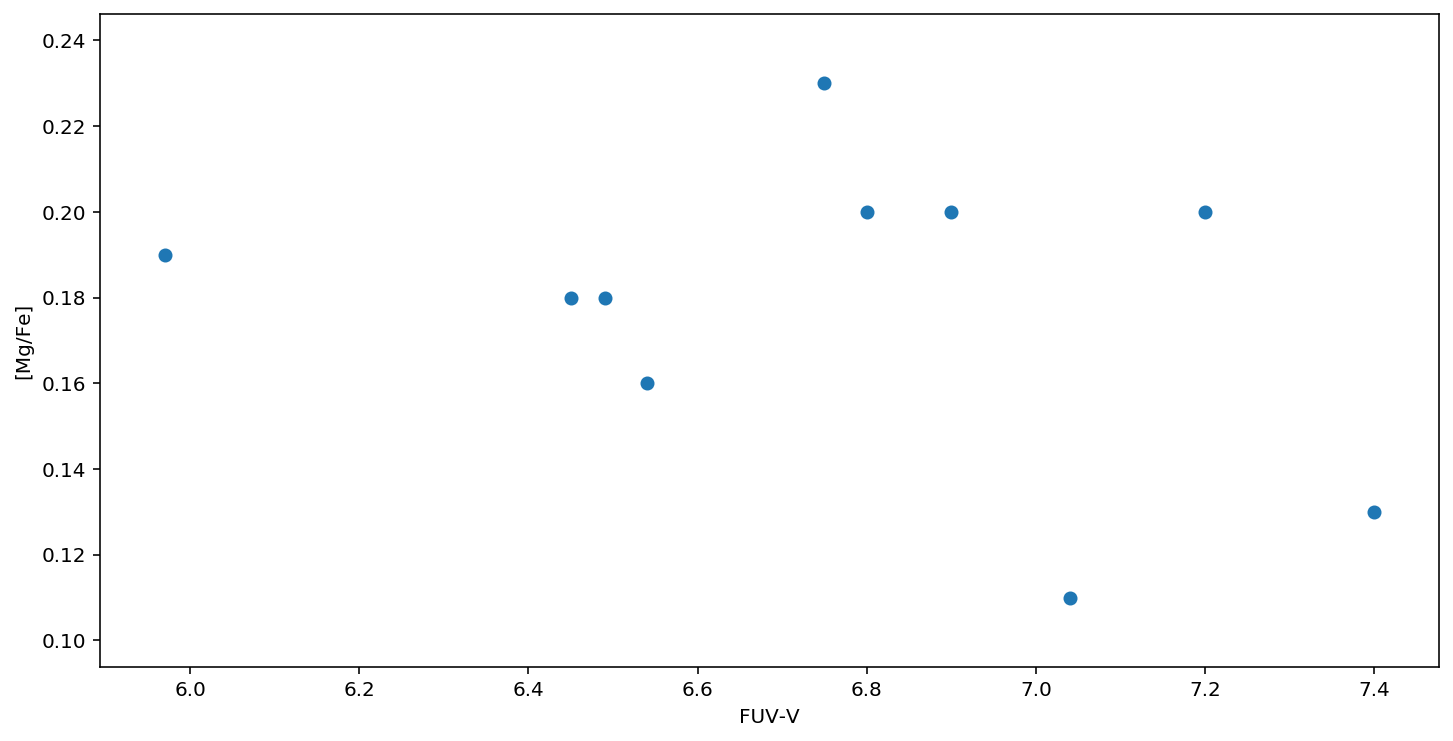

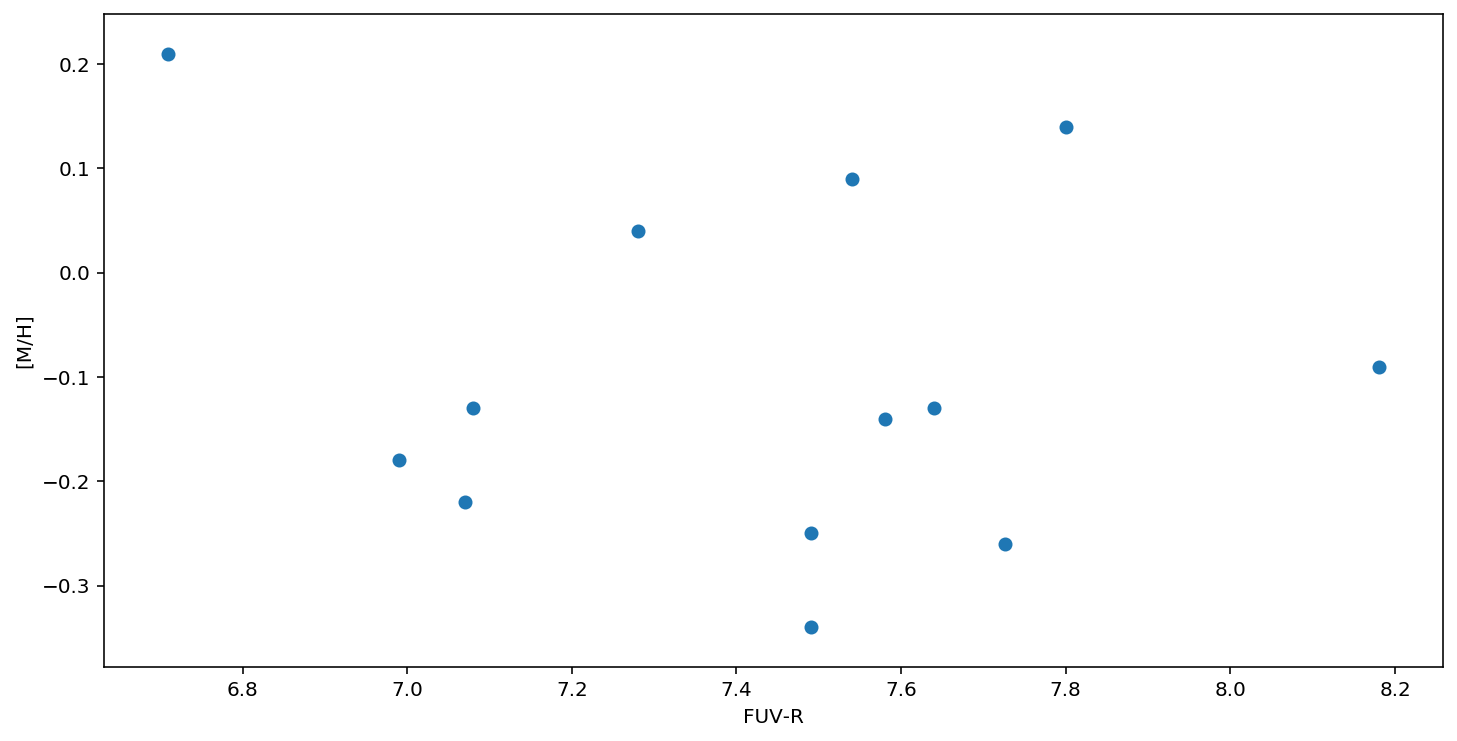

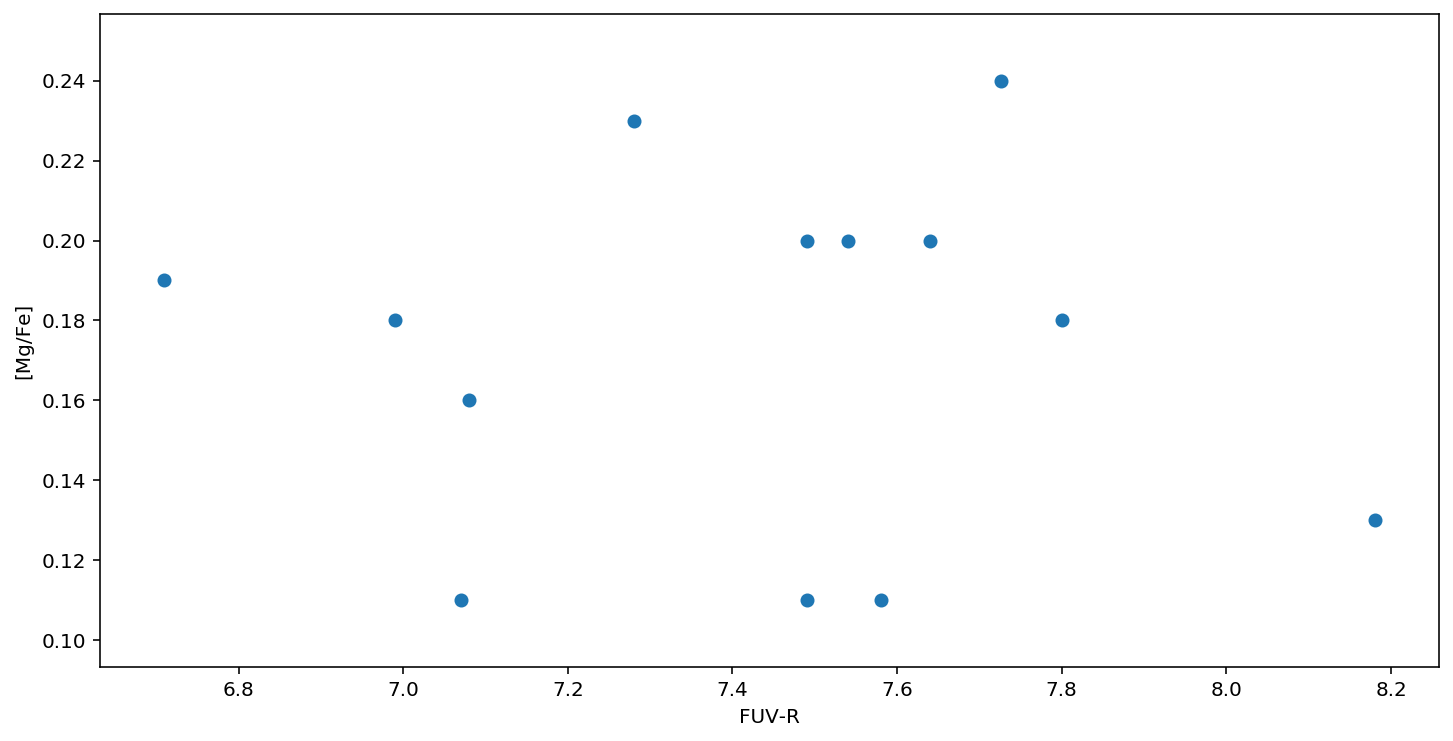

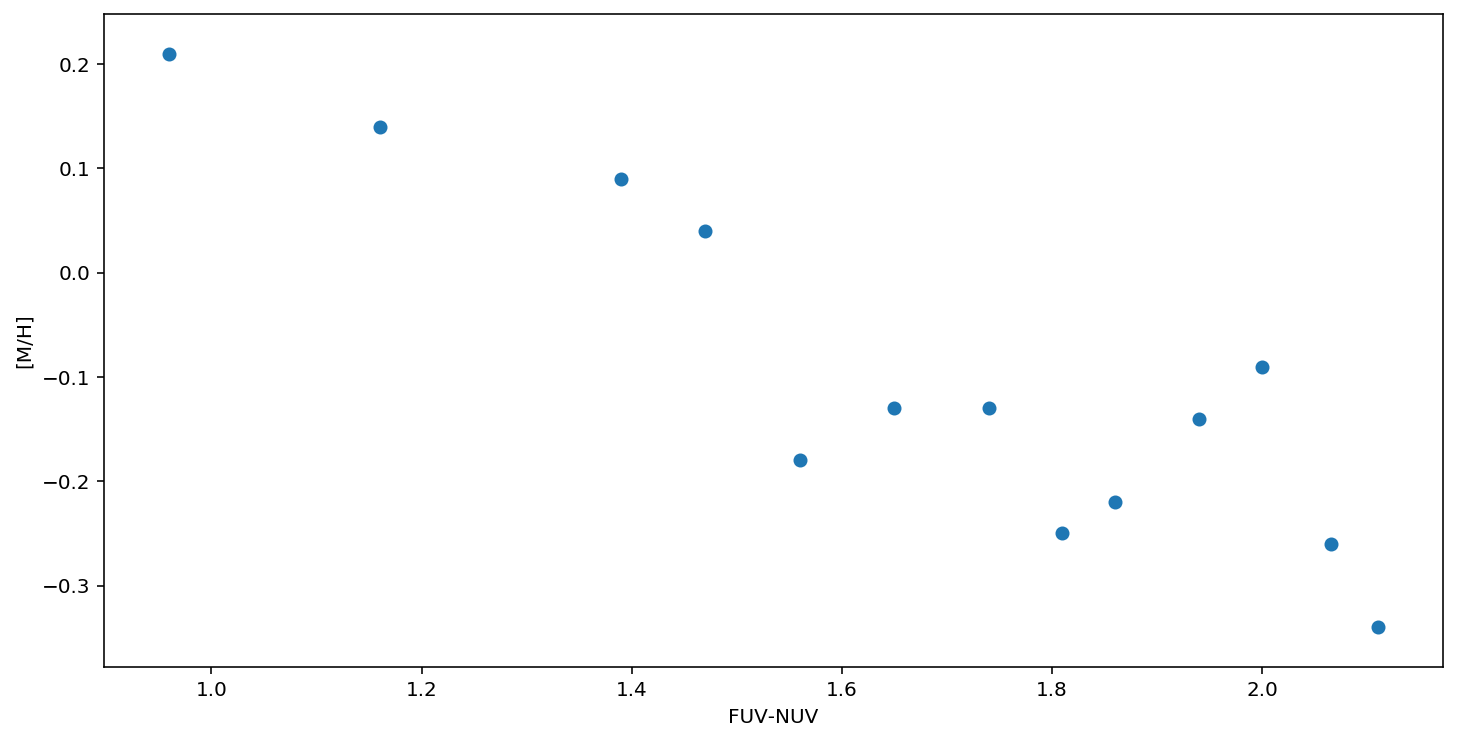

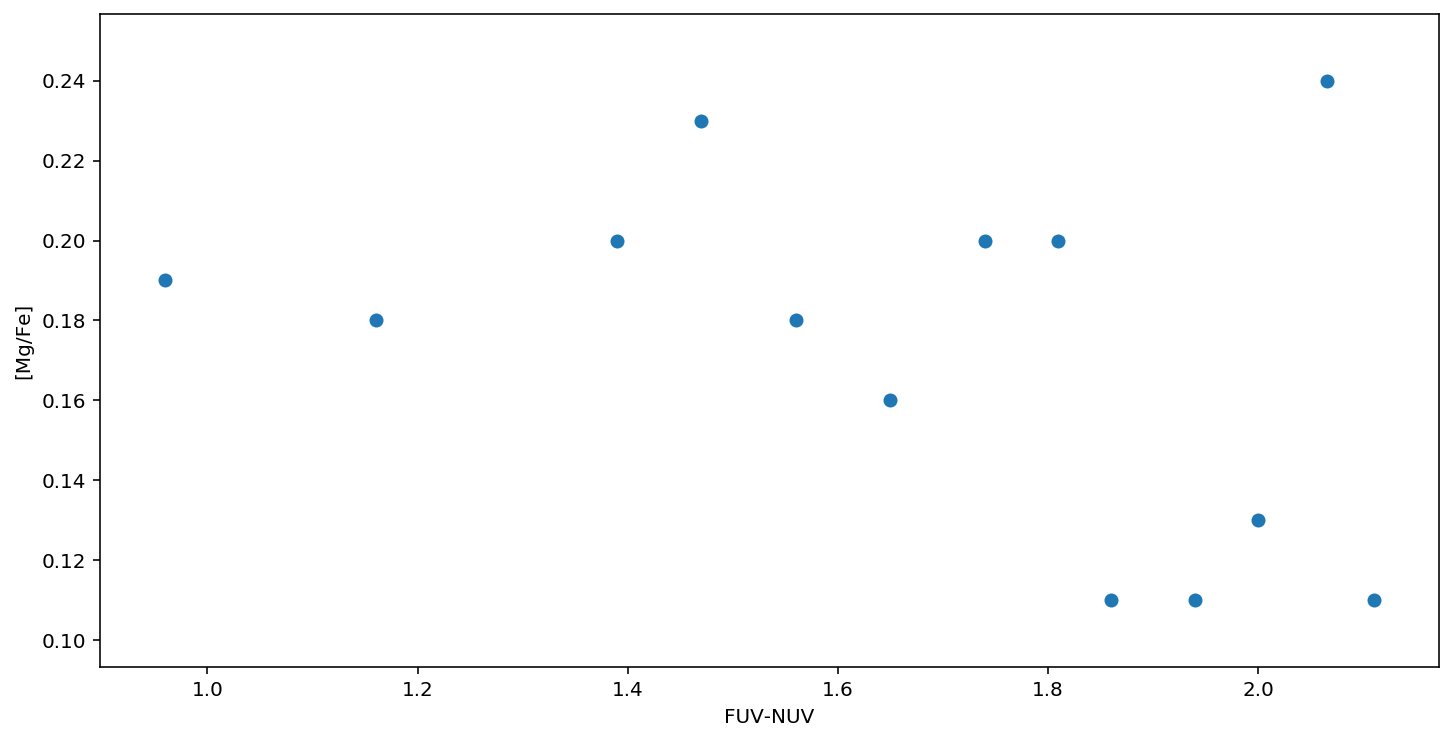

In [14]:
plt.figure(figsize=(12, 6))
plt.scatter(galaxy_df["NUV"].loc[galaxy_df["PNe N"]>20] - galaxy_df["Vmag"].loc[galaxy_df["PNe N"]>20], galaxy_df["alpha2.5"].loc[galaxy_df["PNe N"]>20])
plt.ylabel(r"Log($\alpha_{2.5}$)")
plt.xlabel("NUV - V")


plt.figure(figsize=(12, 6))
plt.scatter(galaxy_df["NUV"].loc[galaxy_df["PNe N"]>20] - galaxy_df["Rmag"].loc[galaxy_df["PNe N"]>20], galaxy_df["alpha2.5"].loc[galaxy_df["PNe N"]>20])
plt.ylabel(r"Log($\alpha_{2.5}$)")
plt.xlabel("NUV - R")

plt.figure(figsize=(12, 6))
plt.scatter(galaxy_df["FUV-V"], galaxy_df["M/H"])
plt.ylabel("[M/H]")
plt.xlabel("FUV-V")

plt.figure(figsize=(12, 6))
plt.scatter(galaxy_df["FUV-V"], galaxy_df["Mg/Fe"])
plt.ylabel("[Mg/Fe]")
plt.xlabel("FUV-V")

plt.figure(figsize=(12, 6))
plt.scatter(galaxy_df["FUV-R"], galaxy_df["M/H"])
plt.ylabel("[M/H]")
plt.xlabel("FUV-R")

plt.figure(figsize=(12, 6))
plt.scatter(galaxy_df["FUV-R"], galaxy_df["Mg/Fe"])
plt.ylabel("[Mg/Fe]")
plt.xlabel("FUV-R")

plt.figure(figsize=(12, 6))
plt.scatter(galaxy_df["FUV-NUV"], galaxy_df["M/H"])
plt.ylabel("[M/H]")
plt.xlabel("FUV-NUV")

plt.figure(figsize=(12, 6))
plt.scatter(galaxy_df["FUV-NUV"], galaxy_df["Mg/Fe"])
plt.ylabel("[Mg/Fe]")
plt.xlabel("FUV-NUV")

In [50]:
galaxy_df

Galaxy  D PNLF D PNLF err dM PNLF dM PNLF err  PNe N PNLF N    N err  \
0   FCC083    19.1     0.7636  31.405       0.087     58   98.1  12.8812   
1   FCC143   17.54      1.468   31.22       0.182     14   16.5  4.40981   
2   FCC147  18.908     0.7948  31.383       0.091     62  107.9  13.7033   
3   FCC161  19.875      0.774  31.492       0.085    101  166.6  16.5773   
4   FCC167  18.739      0.769  31.363      0.0891    111  326.5    30.99   
5   FCC177   20.42      0.889   31.55       0.095     61   88.6  11.3441   
6   FCC182    23.1      1.003  31.818       0.094      9   22.3  7.43333   
7   FCC184  22.106     0.8851  31.723       0.087     66  114.3  14.0694   
8   FCC190  23.327        0.9  31.839       0.084     17   32.6  7.90666   
9   FCC193   19.23       0.74   31.42       0.084    142  184.4  15.4745   
10  FCC219  17.907     0.7694  31.265       0.093     69  166.9  20.0924   
11  FCC249  21.945      0.904   31.71       0.089      9   33.5  11.1667   
12  FCC255  22.057      0.875  31.718       0.086     37   67.6  11.1134   
13  FCC276  20.171     0.8133  31.524       0.088     71  142.2   16.876   
14  FCC277  21.499      0.902  31.662       0.091     25   48.5      9.7   
15  FCC301  22.724     1.0056  31.782       0.096     23   59.9    12.49   
16  FCC310  21.867     0.9073  31.699        0.09     43   85.2  12.9929   

           Lbol     lit Lbol  alpha2.5  alpha2.5 err   age  lit D     FUV  \
0   4.72381e+09  4.85107e+09 -7.682624     -0.053580  13.2  19.23      --   
1           NaN          NaN       NaN           NaN  12.6  17.54   19.65   
2   5.45228e+09  6.13438e+09 -7.703556     -0.051924  13.5  20.51   17.78   
3   8.65215e+09  6.81548e+09 -7.715449     -0.041197  12.9   17.7   18.11   
4   1.44277e+10  1.43706e+10 -7.645314     -0.039381  13.5  18.62   16.81   
5   3.38218e+09          NaN -7.581763     -0.052323   9.8  19.86   19.38   
6   1.31524e+09  9.15469e+08 -7.770700     -0.124939  12.6  19.41   20.65   
7   7.71593e+09  5.78589e+09 -7.829342     -0.050415  13.2  19.14   16.71   
8   2.74524e+09  2.02912e+09 -7.925362     -0.094309  12.9  20.14   19.34   
9   5.14387e+09  5.36937e+09 -7.445529     -0.034996  11.7  19.23   18.87   
10   1.2406e+10  1.36828e+10 -7.871175     -0.049368  11.7  18.79   16.37   
11  3.81199e+09  3.34636e+09 -8.056107     -0.124939  13.5  23.12  19.796   
12          NaN          NaN       NaN           NaN   4.6  19.77     NaN   
13  6.21099e+09  6.03831e+09 -7.640261     -0.048705  13.8  19.95   17.64   
14  1.52723e+09  1.38381e+09 -7.498161     -0.079181  11.7  20.51   19.83   
15  7.80483e+08          NaN -7.114937     -0.082252  10.2  16.29     NaN   
16   2.8017e+09  2.27855e+09 -7.516983     -0.061640    12  19.77     NaN   

   FUV err    NUV NUV err   Vmag Vmag err   Rmag Rmag err   Bmag Bmag err  \
0       --  16.53     0.1  11.51     0.14  10.84      NaN  12.38      NaN   
1     0.05  18.09    0.04   13.2     0.08  12.66      NaN  14.05      NaN   
2     0.07  16.31    0.03  11.03     0.19   10.5      NaN  11.94      NaN   
3     0.03  16.37    0.02  10.91     0.16  10.47      NaN  11.79      NaN   
4     0.17  15.42    0.05   9.91      0.1   9.27      NaN  10.83      NaN   
5     0.15  17.44    0.04  12.34     0.07   11.8      NaN  13.23      NaN   
6     0.09  18.79    0.03     --     0.06  13.58      NaN  14.76      NaN   
7     0.05  15.75    0.07  10.74     0.12     10      NaN  11.72      NaN   
8     0.08  17.69    0.04   12.8     0.21  12.26      NaN  13.73      NaN   
9     0.04  16.87    0.02  11.47     0.12  10.69      NaN  12.38      NaN   
10    0.05  15.21    0.03   9.88     0.23   8.57      NaN  10.84      NaN   
11   0.162  17.73   0.051    NaN     0.08  12.07      NaN  13.56      NaN   
12     NaN    NaN     NaN    NaN      NaN  12.57      NaN  13.86      NaN   
13    0.03  15.83    0.11  10.84     0.18  10.15      NaN  11.74      NaN   
14    0.25  17.72    0.04     --     0.25  12.34      NaN   13.8      NaN   
15     NaN    Na

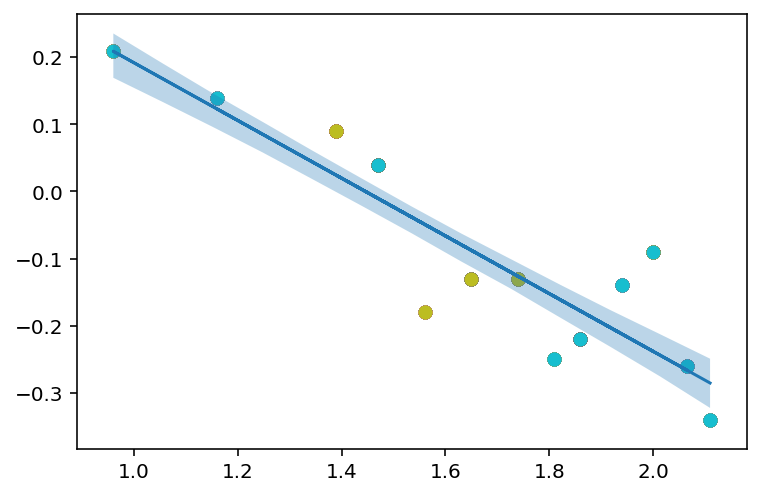

In [159]:
from astropy.stats import bootstrap
from astropy.utils import NumpyRNGContext
from scipy import stats


boot_1 = galaxy_df["FUV-NUV"].loc[pd.notnull(galaxy_df["FUV-NUV"])].values[1:]
boot_2 = galaxy_df["M/H"].loc[pd.notnull(galaxy_df["FUV-NUV"])].values[1:]
boot_arr = np.array([[i,j] for i,j in zip(boot_1, boot_2)])

num = 1000

with NumpyRNGContext(1):
    bootresult_1 = bootstrap(boot_arr, num) # FUV -NUV
#     bootresult_2 = bootstrap(boot_2, 1) # M/H

slope_list = np.ones(num)
intercept_list = np.ones(num)
std_err_list = np.ones(num)

for n in np.arange(num):
    plt.scatter(bootresult_1[n,:,0],bootresult_1[n,:,1])
    slope_list[n], intercept_list[n], r_value, p_value, std_err_list[n] = stats.linregress(bootresult_1[n,:,0],bootresult_1[n,:,1])
    #plt.plot(boot_1, slope_list[n]*boot_1+intercept_list[n], c="k", alpha=0.1)
    
med_slope = np.nanmedian(slope_list)
slope_16 = np.nanpercentile(slope_list, 16)
slope_84 = np.nanpercentile(slope_list, 84)


med_int = np.nanmedian(intercept_list)
int_16 = np.nanpercentile(intercept_list, 16)
int_84 = np.nanpercentile(intercept_list, 84)

std_err_med = np.nanmedian(std_err_list)
# plt.ylabel("M/H")
y = med_slope*boot_1 + med_int
plt.plot(boot_1, y)
x_axis = np.linspace(boot_1.min(), boot_1.max(), num=len(boot_1))

#plt.fill_between(x_axis, y_lo, y_up, alpha=0.5)

y_model = [np.array(s*x_axis + i, dtype=float) for s,i in zip(slope_list, intercept_list)]
med_y = np.array([np.nanmedian(y_model,axis=0) for m in y_model], dtype=float)
y_16 = np.array(np.nanpercentile(y_model, 16,axis=0) , dtype=float)
y_84 = np.array(np.nanpercentile(y_model, 84,axis=0) , dtype=float)

plt.fill_between(np.array(x_axis, dtype=float), y_16, y_84, alpha=0.3)


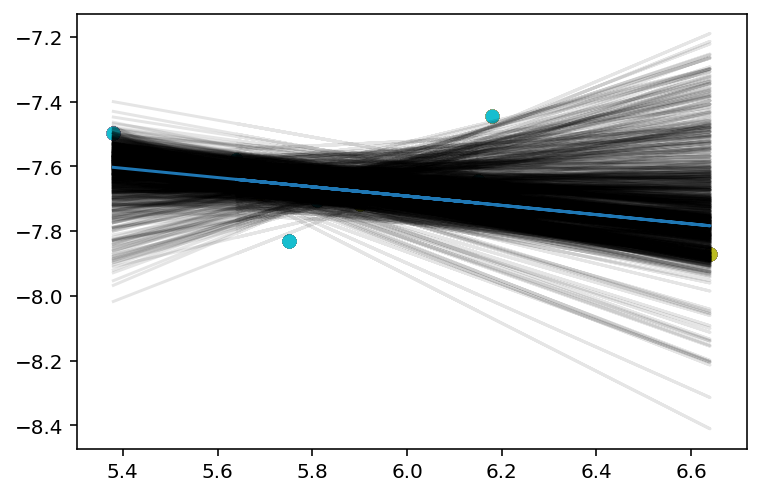

In [123]:
from astropy.stats import bootstrap
from astropy.utils import NumpyRNGContext

galaxy_df["NUV-R"] = galaxy_df["NUV"] - galaxy_df["Rmag"]


boot_1 = galaxy_df["NUV-R"].loc[pd.notnull(galaxy_df["NUV-R"]) & (galaxy_df["PNe N"]>20)].values
boot_2 = galaxy_df["alpha2.5"].loc[pd.notnull(galaxy_df["NUV-R"])& (galaxy_df["PNe N"]>20)].values
boot_arr = np.array([[i,j] for i,j in zip(boot_1, boot_2)])

num = 1000

with NumpyRNGContext(1):
    bootresult_1 = bootstrap(boot_arr, num) # FUV -NUV
#     bootresult_2 = bootstrap(boot_2, 1) # M/H

slope_list = np.ones(num)
intercept_list = np.ones(num)
std_err_list = np.ones(num)

for n in np.arange(num):
    plt.scatter(bootresult_1[n,:,0],bootresult_1[n,:,1])
    slope_list[n], intercept_list[n], r_value, p_value, std_err_list[n] = stats.linregress(bootresult_1[n,:,0],bootresult_1[n,:,1])
    plt.plot(boot_1, slope_list[n]*boot_1+intercept_list[n], c="k", alpha=0.1)
med_slope = np.nanmedian(slope_list)
slope_16 = np.nanpercentile(slope_list, 16)
slope_84 = np.nanpercentile(slope_list, 84)


med_int = np.nanmedian(intercept_list)
int_16 = np.nanpercentile(intercept_list, 16)
int_84 = np.nanpercentile(intercept_list, 84)

std_err_med = np.nanmedian(std_err_list)
# plt.ylabel("M/H")
y = med_slope*boot_1 + med_int
plt.plot(boot_1, y)
x_axis = np.linspace(boot_1.min(), boot_1.max(), num=len(boot_1))

y_up = np.array(slope_84*boot_1 + int_84, dtype=float)
y_lo = np.array(slope_16*boot_1 + int_16, dtype=float)

#plt.fill_between(x_axis, y_lo, y_up, alpha=0.5)



Text(0.5, 0, 'FUV-NUV')

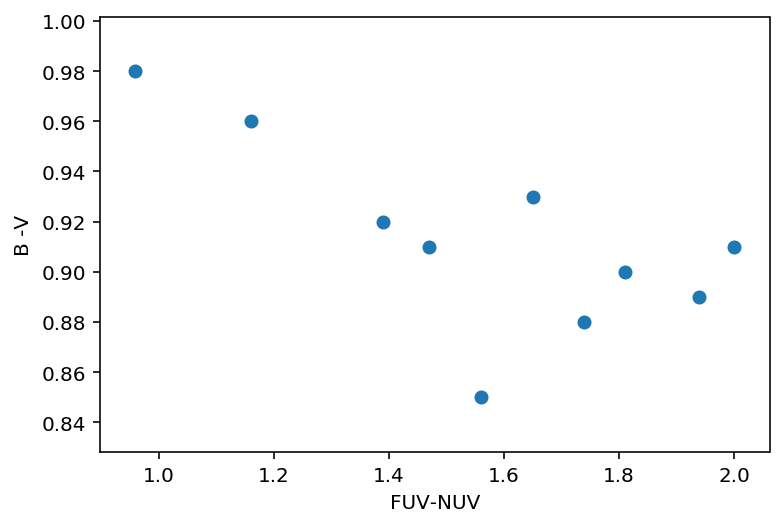

In [173]:
plt.scatter(galaxy_df["FUV-NUV"], galaxy_df["B-V"])
plt.ylabel("B -V")
plt.xlabel("FUV-NUV")

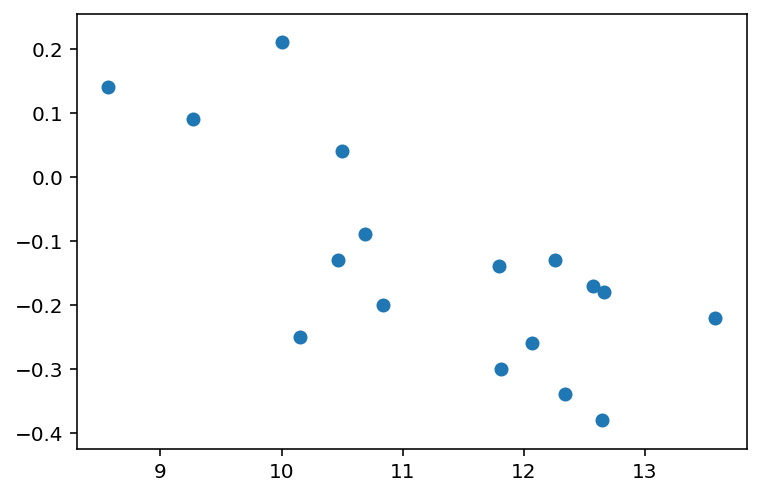

In [13]:
plt.scatter(galaxy_df["Rmag"], galaxy_df["M/H"])

In [43]:
pd.set_option('display.max_columns', 100)


In [33]:
stats.spearmanr(galaxy_df["alpha2.5"].loc[galaxy_df["PNe N"]>20].values, list(galaxy_df["FUV-NUV"].loc[galaxy_df["PNe N"]>20].values), nan_policy="omit")

SpearmanrResult(correlation=0.8571428571428571, pvalue=0.006530017254715304)